In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

from lonboard import Map, ScatterplotLayer
from functions import geo_to_h3, group_by_h3_cell, add_geometry, open_tif
from shapely.geometry import box

from rasterio.plot import plotting_extent
from rasterio.mask import mask
from rasterio.windows import from_bounds
import rasterio
import rasterio.features
from shapely.geometry import Point
from rasterio.transform import rowcol

import geopandas as gpd
from shapely.geometry import mapping, box, Polygon
import numpy as np

import matplotlib.pyplot as plt

In [2]:
raster_data, bounds, crs = open_tif("../data/data_layers/worldClim/clipped_wc2.1_30s_bio_1.tif")
reduced_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)


POE_TOT = gpd.read_file("../data/saved_df/POE_PROV.gpkg", layer="vue_pe_espece_tot")
print(f"crs: {POE_TOT.crs}")
POE_TOT['geometry'] = POE_TOT.geometry.to_crs(epsg=4326)
POE_TOT['geometry'] = POE_TOT.geometry.centroid

# # Create a bounding box from the reduced_extent
# bounding_box = box(reduced_extent[0], reduced_extent[2], reduced_extent[1], reduced_extent[3])

# # Filter POE_TOT to only keep geometries within the bounding box
# POE_TOT_reduced = POE_TOT[POE_TOT.geometry.within(bounding_box)]

crs: EPSG:32198


/tmp/ipykernel_164858/4071010441.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  POE_TOT['geometry'] = POE_TOT.geometry.centroid


In [3]:
def reduce_extend(raster_file):
    raster_data, bounds, crs = open_tif(raster_file)
    reduced_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
    print("Reduced extent:", reduced_extent)
    POE_TOT = gpd.read_file("../data/saved_df/POE_PROV.gpkg", layer="vue_pe_espece_tot")
    original_crs = POE_TOT.crs
    print("Original CRS:", original_crs)
    POE_TOT['geometry'] = POE_TOT.geometry.to_crs(crs)
    POE_TOT['geometry'] = POE_TOT.geometry.centroid

    # Create a bounding box from the reduced_extent
    bounding_box = box(reduced_extent[0], reduced_extent[2], reduced_extent[1], reduced_extent[3])

    # Filter POE_TOT to only keep geometries within the bounding box
    POE_TOT_reduced = POE_TOT[POE_TOT.geometry.within(bounding_box)]
    POE_TOT_reduced = POE_TOT_reduced.to_crs("EPSG:4326")
    return POE_TOT_reduced

In [4]:
POE_TOT_reduced = reduce_extend("../data/data_layers/predictors_100_QC/roche.tif")

Reduced extent: (-747653.4370235632, 276346.5629764368, 117557.86462470307, 948957.8646247031)
Original CRS: EPSG:32198


In [6]:
POE_TOT_reduced

OGC_FID      id_poe espece   rec no_prj no_viree no_poe  id_viree  \
0             1  9002600101    ACM   0.1  90026      001     01  90026001   
1             2  9002600101    ARN   0.1  90026      001     01  90026001   
2             3  9002600101    ASM   3.0  90026      001     01  90026001   
3             4  9002600101    BOP   0.2  90026      001     01  90026001   
4             5  9002600101    BOV   0.1  90026      001     01  90026001   
...         ...         ...    ...   ...    ...      ...    ...       ...   
868954   868955  0010302405    VAA  33.0  00103      024     05  00103024   
868955   868956  0010302405    VAU   0.1  00103      024     05  00103024   
868956   868957  0010302405    VAV   0.1  00103      024     05  00103024   
868957   868958  0010302405  RES_S  52.0  00103      024     05  00103024   
868958   868959  0010302405  CLA_S  88.0  00103      024     05  00103024   

       chainage feuillet   latitude  longitude  date_sond  \
0           100  31F14SE  45.819832 -77.019622 1990-06-13   
1           100  31F14SE  45.819832 -77.019622 1990-06-13   
2           100  31F14SE  45.819832 -77.019622 1990-06-13   
3           100  31F14SE  45.819832 -77.019622 1990-06-13   
4           100  31F14SE  45.819832 -77.019622 1990-06-13   
...         ...      ...        ...        ...        ...   
868954     1000  23D08NE  52.439195 -70.013634 2000-07-13   
868955     1000  23D08NE  52.439195 -70.013634 2000-07-13   
868956     1000  23D08NE  52.439195 -70.013634 2000-07-13   
868957     1000  23D08NE  52.439195 -70.013634 2000-07-13   
868958     1000  23D08NE  52.439195 -70.013634 2000-07-13   

                          geometry  
0       POINT (-77.01962 45.81983)  
1       POINT (-77.01962 45.81983)  
2       POINT (-77.01962 45.81983)  
3       POINT (-77.01962 45.81983)  
4       POINT (-77.01962 45.81983)  
...                            ...  
868954   POINT (-70.01363 52.4392)  
868955   POINT (-70.01363 52.4392)  
868956   POINT (-70.01363 52.4392)  
868957   POINT (-70.01363 52.4392)  
868958   POINT (-70.01363 52.4392)  

[773991 rows x 14 columns]

/tmp/ipykernel_164858/4110110698.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  POE_TOT['geometry'] = POE_TOT.geometry.centroid


POE_TOT CRS after conversion: EPSG:6624
POE_TOT bounds (EPSG:6624): x=[-660785.4571517224, -659706.0171409512], y=[240794.7018372301, 240959.66792636964]
Raster bounds (EPSG:6624): x=[-747653.4370235632, 276346.5629764368], y=[117557.86462470307, 948957.8646247031]


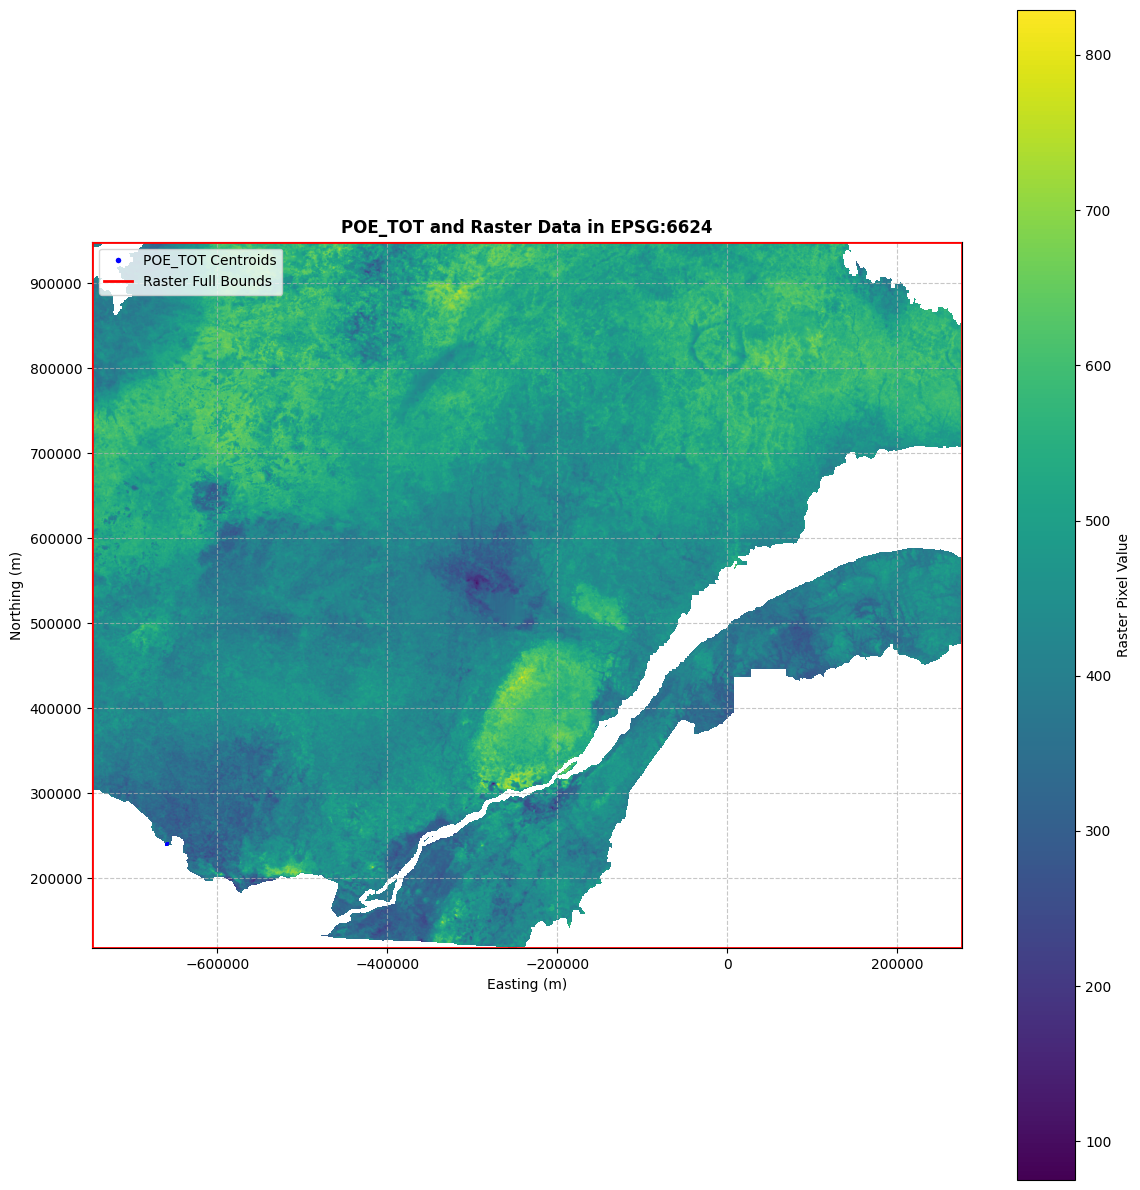

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import rasterio
import rasterio.plot # Import rasterio.plot for show
import numpy as np # Needed for nodata handling

# Define the path to your input raster
input_raster_path = "../data/data_layers/predictors_100_QC/sand.tif"

POE_TOT = POE_TOT_reduced.copy().iloc[:200]  # Use the reduced POE_TOT for plotting

# If POE_TOT.crs is None or incorrect, you might need to set it first
# e.g., if you know it's 4326: POE_TOT.set_crs('EPSG:4326', inplace=True)

POE_TOT['geometry'] = POE_TOT.geometry.centroid
POE_TOT['geometry'] = POE_TOT.geometry.to_crs('EPSG:6624')
print("POE_TOT CRS after conversion:", POE_TOT.crs)

# Get the bounds of the POE_TOT data in EPSG:6624
minx_poe, miny_poe, maxx_poe, maxy_poe = POE_TOT.total_bounds
print(f"POE_TOT bounds (EPSG:6624): x=[{minx_poe}, {maxx_poe}], y=[{miny_poe}, {maxy_poe}]")

# Open the raster to get its information and data
with rasterio.open(input_raster_path) as src:
    raster_crs = src.crs
    raster_bounds = src.bounds
    raster_transform = src.transform
    raster_nodata = src.nodata

    print(f"Raster bounds (EPSG:6624): x=[{raster_bounds.left}, {raster_bounds.right}], y=[{raster_bounds.bottom}, {raster_bounds.top}]")

    # Define the bounding box for plotting the full raster extent
    # This will be used to plot the red rectangle around the raster's full extent
    bounding_box_raster_full_extent = box(raster_bounds.left, raster_bounds.bottom, raster_bounds.right, raster_bounds.top)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(12, 12)) # Make it a bit larger for better visualization

    # 1. Plot the Raster Data
    # Read the first band (or choose a specific band to visualize)
    # Consider if you want to read the entire raster or a clipped portion for speed/memory.
    # For now, let's read the whole first band.
    raster_data = src.read(1)

    # Handle NoData values for visualization (make them transparent)
    if raster_nodata is not None:
        raster_data = np.where(raster_data == raster_nodata, np.nan, raster_data)

    # Plot the raster using rasterio.plot.show
    # Set zorder to a low value (e.g., 1) so it's at the back
    rasterio.plot.show(
        raster_data,
        transform=raster_transform,
        ax=ax,
        cmap='viridis', # Choose a suitable colormap for your data
        title="POE_TOT and Raster Data in EPSG:6624",
        zorder=1 # Plot at the lowest layer
    )
    # Add a colorbar for the raster data
    plt.colorbar(ax.images[0], ax=ax, label="Raster Pixel Value")


    # 2. Plot the POE_TOT points
    # Set zorder to a higher value (e.g., 2 or more) so they appear on top
    POE_TOT.plot(ax=ax, color='blue', markersize=1, label='POE_TOT Centroids', zorder=2)

    # 3. Plot the full raster extent bounding box (optional, but good for context)
    # Ensure this is plotted with a higher zorder than the raster data but lower than points if desired
    gpd.GeoSeries([bounding_box_raster_full_extent], crs=POE_TOT.crs).plot(
        ax=ax,
        color='none',
        edgecolor='red',
        linewidth=2,
        label='Raster Full Bounds',
        zorder=3 # On top of raster, potentially on top of points or similar to points
    )

    # Set plot labels and aspects
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_aspect('equal', adjustable='box') # Maintain aspect ratio
    plt.grid(True, linestyle='--', alpha=0.7) # Add a subtle grid

    # Adjust plot limits to focus on the area where both data and raster exist
    # This makes the plot more meaningful if the raster is very large
    min_x_lim = min(minx_poe, raster_bounds.left)
    max_x_lim = max(maxx_poe, raster_bounds.right)
    min_y_lim = min(miny_poe, raster_bounds.bottom)
    max_y_lim = max(maxy_poe, raster_bounds.top)

    # Add a small buffer to the limits for better visualization
    buffer_x = (max_x_lim - min_x_lim) * 0.05
    buffer_y = (max_y_lim - min_y_lim) * 0.05

    # ax.set_xlim(min_x_lim - buffer_x, max_x_lim + buffer_x)
    # ax.set_ylim(min_y_lim - buffer_y, max_y_lim + buffer_y)


    # Create a unified legend
    # Handle the UserWarning about PatchCollection instances for the legend
    # One way is to manually create proxy artists for the legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='POE_TOT Centroids'),
        Line2D([0], [0], color='red', lw=2, label='Raster Full Bounds')
    ]
    ax.legend(handles=legend_elements, loc='upper left')

    plt.tight_layout() # Adjust layout to prevent labels/titles from overlapping
    plt.show()

In [277]:
#(-831090.3709418251, 238609.6290581749, 1503984.5344915963, 2224684.5344915963)
bounding_box = box(-831090.3709418251, 1503984.5344915963, 238609.6290581749, 2224684.5344915963)
POE_TOT_reduced = POE_TOT[POE_TOT.geometry.within(bounding_box)]

In [278]:
POE_TOT_reduced

Empty GeoDataFrame
Columns: [OGC_FID, id_poe, espece, rec, no_prj, no_viree, no_poe, id_viree, chainage, feuillet, latitude, longitude, date_sond, geometry]
Index: []

In [1]:
POE_TOT_reduced = reduce_extend("../data/data_layers/predictors_100_QC/mhc.tif")

NameError: name 'reduce_extend' is not defined

In [272]:
POE_TOT_reduced

Empty GeoDataFrame
Columns: [OGC_FID, id_poe, espece, rec, no_prj, no_viree, no_poe, id_viree, chainage, feuillet, latitude, longitude, date_sond, geometry]
Index: []

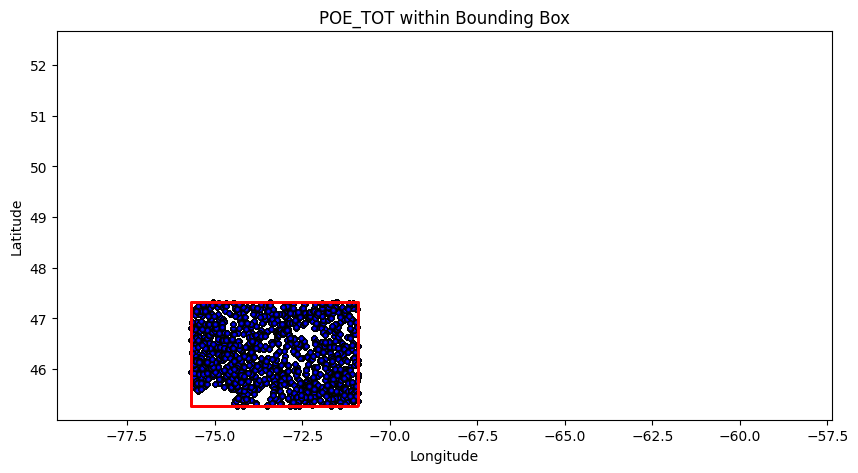

In [248]:
#compare bounding_box_gdf with POE_TOT bounding box
bounding_box_gdf = gpd.GeoDataFrame(geometry=[bounding_box], crs="EPSG:4326")
bounding_box_gdf = bounding_box_gdf.to_crs(POE_TOT_reduced.crs)

POE_TOT_bbox = POE_TOT.total_bounds

#plot the bounding box and POE_TOT_bbox
fig, ax = plt.subplots(figsize=(10, 10))
POE_TOT_reduced.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black', markersize=10)
bounding_box_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2)
ax.set_xlim(POE_TOT_bbox[0], POE_TOT_bbox[2])
ax.set_ylim(POE_TOT_bbox[1], POE_TOT_bbox[3])
ax.set_aspect('equal', adjustable='box')
bounding_box_gdf.boundary.plot(ax=ax, color='red', linewidth=2)
ax.set_title("POE_TOT within Bounding Box")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

the landuse file is too big to work with so i first cropped it to the area of interest
and then i  desampled it by a factor of 0.5

In [ ]:

# #clip a raster to the bounding box
# with rasterio.open("../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif") as src:
#     out_image, out_transform = mask(src, [mapping(bounding_box)], crop=True)
#     out_meta = src.meta.copy()
#     #save the clipped raster
#     out_meta.update({
#         "driver": "GTiff",
#         "height": out_image.shape[1],
#         "width": out_image.shape[2],
#         "transform": out_transform
#     })
#     with rasterio.open("../data/data_layers/landuse/utilisation_territoire_2020_clipped.tif", "w", **out_meta) as dest:
#         dest.write(out_image)

<Axes: xlabel='espece'>

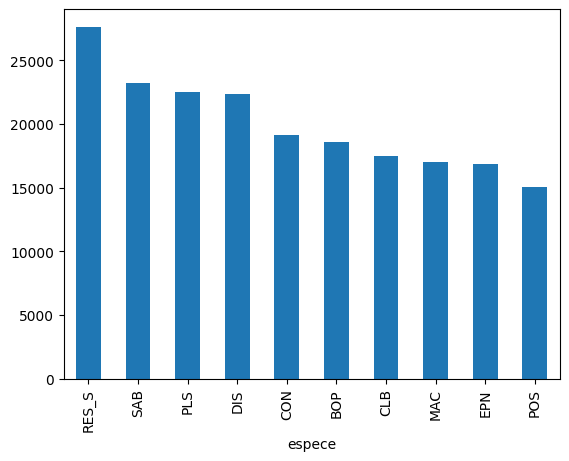

In [ ]:
#plot distribution ofPOE_TOT by 'espece'
#POE_TOT['espece'].value_counts().sort_values(ascending=False)[:10].plot(kind='bar')

### Extract location data from raster

In [316]:
def add_raster_values_to_geodf(raster_path, geodf, column_name='raster_value'):
    """
    Extract raster values at GeoDataFrame point geometries and add as a new column.
    
    Parameters:
    ----------
    raster_path : str
        Path to the raster file (.tif, etc)
    geodf : geopandas.GeoDataFrame
        GeoDataFrame with Point geometries
    column_name : str, optional
        Name for the new column(s) with raster values
        
    Returns:
    -------
    geopandas.GeoDataFrame
        Input GeoDataFrame with added raster value column(s)
    """
    # Open the raster
    with rasterio.open(raster_path) as src:
        
        # # Transform the GeoDataFrame to the raster's CRS if needed
        # if geodf.crs != src.crs:
        #     print(f"Transforming GeoDataFrame CRS from {geodf.crs} to {src.crs}.")
        #     geodf.to_crs(src.crs)
        
        # Check if we have a multi-band raster
        multi_band = src.count > 1
        
        # Create columns for each band if multi-band raster
        if multi_band:
            print("Multi-band raster detected.")
            column_names = [f"{column_name}_{i+1}" for i in range(src.count)]
            for col in column_names:
                geodf[col] = np.nan
        else:
            geodf[column_name] = np.nan
        
        # Extract the coordinates from the geometries
        for idx, geom in geodf.iterrows():
            # Check if the geometry is a Point or Polygon
            if geom.geometry.geom_type == 'Point':
                x, y = geom.geometry.x, geom.geometry.y
            elif geom.geometry.geom_type == 'Polygon':
                centroid = geom.geometry.centroid
                x, y = centroid.x, centroid.y
            else:
                print(f"Unsupported geometry type: {geom.geometry.geom_type}")
                continue
            
            # Convert coordinates to pixel indices
            row, col = rowcol(src.transform, x, y)
            
            # Check if the point is within the raster bounds
            if 0 <= row < src.height and 0 <= col < src.width:
                # For multi-band raster
                if multi_band:
                    for band in range(src.count):
                        value = src.read(band+1, window=((row, row+1), (col, col+1)))[0, 0]
                        # Handle nodata values
                        if value == src.nodata:
                            value = np.nan
                        geodf.at[idx, column_names[band]] = value
                # For single-band raster
                else:
                    value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                    # Handle nodata values
                    if value == src.nodata:
                        value = np.nan
                    geodf.at[idx, column_name] = value
        
        return geodf

In [317]:
# import os

# folder_path = '../data/data_layers'
# file_paths = []
# file_names = []
# for root, dirs, files in os.walk(folder_path):
#     for file in files:
#         full_path = os.path.join(root, file)
#         file_paths.append(full_path)
#         file_names.append(os.path.splitext(file)[0])
#take the first elem different elem of no_poe and create a df of 10 unique of those elem
# no_poe = POE_TOT['no_viree'].unique()
# unique_no_viree_df = POE_TOT_reduced.drop_duplicates(subset='no_viree').head(10)


# for i, file_path in enumerate(file_paths):
#     print(f"Processing {file_path}")
#     col_name = file_names[i]
#     add_raster_values_to_geodf(
#         raster_path=file_path,
#         geodf=POE_TOT,
#         column_name=col_name
#     )
#save to csv
# unique_no_viree_df.to_csv('POE_TOT_raster_values.csv', index=False)

Had issues with the landuse data since it was not in the same projection as the other data. I used the `gdalwarp` command to reproject the landuse data to match the other data. The command is as follows:

gdalwarp -s_srs EPSG:6624 -t_srs EPSG:4326 -co "COMPRESS=LZW" ../data/data_layers/predictors_100_QC.tif predictors_100_QC_reprojected.tif

In [318]:
!gdalwarp -s_srs EPSG:6624 -t_srs EPSG:4326 -co "COMPRESS=LZW" ../data/data_layers/predictors_100_QC.tif predictors_100_QC_reprojected.tif

Creating output file that is 26365P x 16048L.
Processing ../data/data_layers/predictors_100_QC.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image ../data/data_layers/predictors_100_QC.tif.
Copying nodata values from source ../data/data_layers/predictors_100_QC.tif to destination predictors_100_QC_reprojected.tif.
^C


### Extract h3 hex from location

In [813]:
POE_TOT_reduced.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
#generate h3 index
POE_TOT_reduced['h3_index'] = POE_TOT_reduced.geometry.apply(lambda point: geo_to_h3(point.y, point.x, 12))

#group by h3 index and species
processed_species = group_by_h3_cell(POE_TOT_reduced, h3_col='h3_index', species_col='espece')

# #add the hex geometry for each h3_cell
processed_species = gpd.GeoDataFrame(
    processed_species,
    geometry=processed_species.apply(lambda x: add_geometry({'h3_cell': x['h3_index']}), axis=1),
    crs=POE_TOT_reduced.crs
)

# raster_path = "../data/data_layers/soil_grid/Solonetz.tif"
# with rasterio.open(raster_path) as src:
#     raster_data = src.read(1)  # Read the first band of the raster
#     my_extent = rasterio.plot.plotting_extent(src)  # Get the extent of the raster
#     print(my_extent)

#     # Create a bounding box from the extent
#     bounding_box = box(reduced_extent[0], reduced_extent[2], reduced_extent[1], reduced_extent[3])

#     # Filter rows where geometry is completely inside the bounding box
#     processed_species = processed_species[processed_species.geometry.within(bounding_box)]

773991


/tmp/ipykernel_147232/2879823393.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  POE_TOT['geometry'] = POE_TOT.geometry.centroid


POE_TOT CRS after conversion: EPSG:6624
POE_TOT bounds (EPSG:6624): x=[-747651.8680760063, 276307.56202442135], y=[118119.78937973033, 942213.7268629428]
COUCOU:  (np.float64(-747651.8680760063), np.float64(118119.78937973024), np.float64(276307.5620244214), np.float64(942213.7268629428))


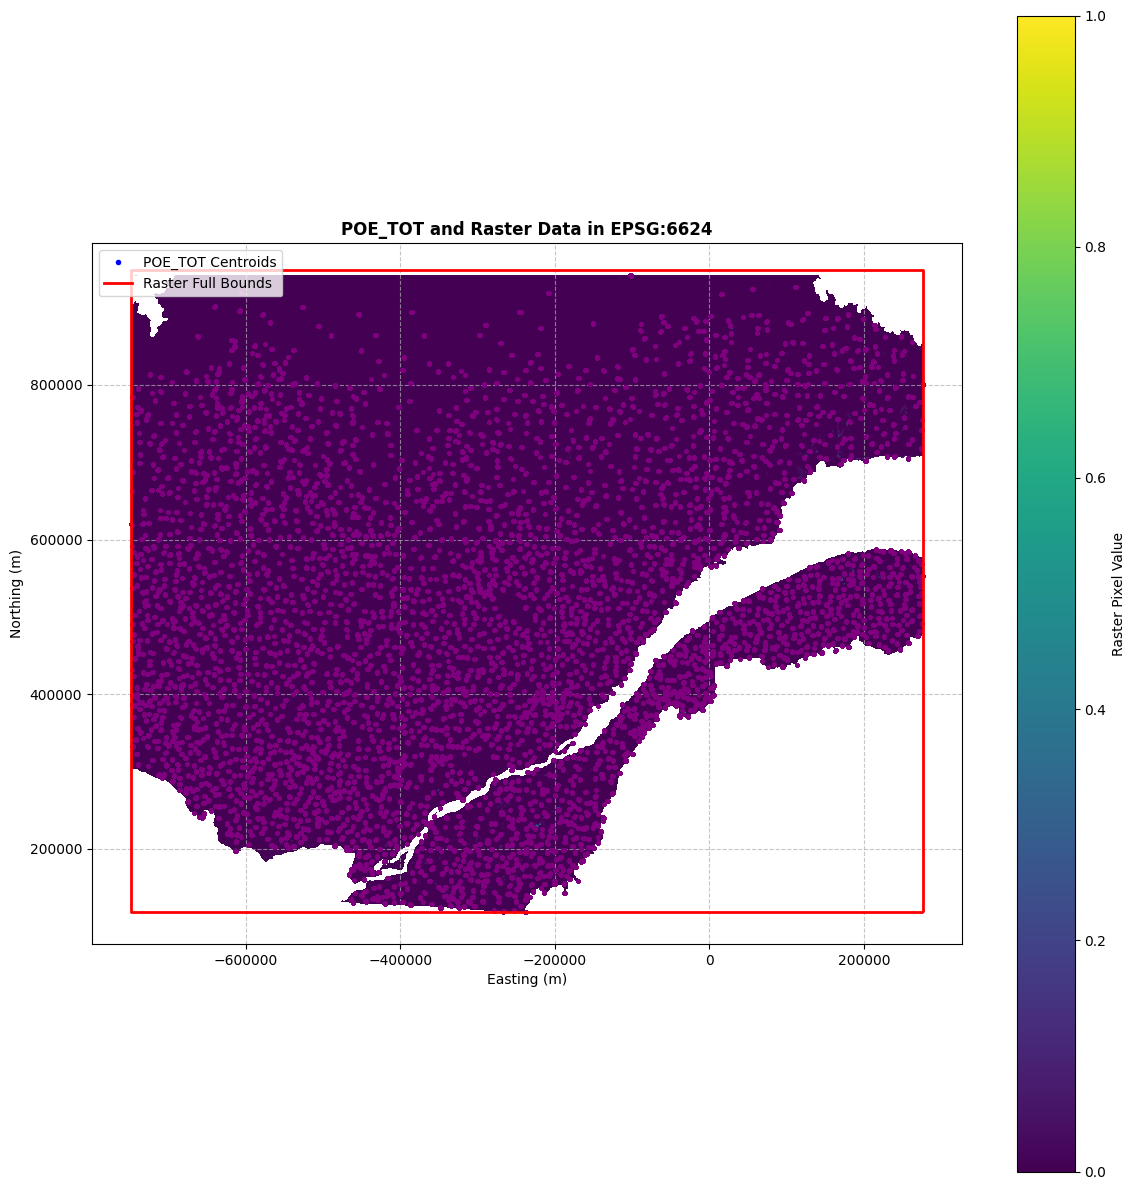

In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import rasterio
import rasterio.plot # Import rasterio.plot for show
import numpy as np # Needed for nodata handling

# Define the path to your input raster
input_raster_path = "../data/data_layers/predictors_100_QC/barren.tif"

POE_TOT = POE_TOT_reduced.copy()  # Use the reduced POE_TOT for plotting

# If POE_TOT.crs is None or incorrect, you might need to set it first
# e.g., if you know it's 4326: POE_TOT.set_crs('EPSG:4326', inplace=True)

POE_TOT['geometry'] = POE_TOT.geometry.centroid
POE_TOT['geometry'] = POE_TOT.geometry.to_crs('EPSG:6624')
print("POE_TOT CRS after conversion:", POE_TOT.crs)

# Get the bounds of the POE_TOT data in EPSG:6624
minx_poe, miny_poe, maxx_poe, maxy_poe = POE_TOT.total_bounds
print(f"POE_TOT bounds (EPSG:6624): x=[{minx_poe}, {maxx_poe}], y=[{miny_poe}, {maxy_poe}]")

# Open the raster to get its information and data
with rasterio.open(input_raster_path) as src:
    raster_crs = src.crs
    raster_transform = src.transform
    raster_nodata = src.nodata

    # Define the bounding box for plotting the full raster extent
    # This will be used to plot the red rectangle around the raster's full extent
    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(12, 12)) # Make it a bit larger for better visualization

    # 1. Plot the Raster Data
    # Read the first band (or choose a specific band to visualize)
    # Consider if you want to read the entire raster or a clipped portion for speed/memory.
    # For now, let's read the whole first band.
    # Calculate the window corresponding to the POE_TOT bounding box in raster coordinates

    # Use POE_TOT bounds (already in EPSG:6624) to create the window
    window = from_bounds(minx_poe, miny_poe, maxx_poe, maxy_poe, transform=src.transform)

    # Read only the data within the window
    raster_data = src.read(1, window=window)
    from rasterio.windows import bounds as window_bounds
    raster_bounds = window_bounds(window, src.transform)
    print("COUCOU: ", raster_bounds)
    # Update the transform for the windowed data
    window_transform = src.window_transform(window)
    raster_transform = window_transform

    # Handle NoData values for visualization (make them transparent)
    if raster_nodata is not None:
        raster_data = np.where(raster_data == raster_nodata, np.nan, raster_data)

    # Plot the raster using rasterio.plot.show
    # Set zorder to a low value (e.g., 1) so it's at the back
    rasterio.plot.show(
        raster_data,
        transform=raster_transform,
        ax=ax,
        cmap='viridis', # Choose a suitable colormap for your data
        title="POE_TOT and Raster Data in EPSG:6624",
        zorder=1 # Plot at the lowest layer
    )
    # Add a colorbar for the raster data
    plt.colorbar(ax.images[0], ax=ax, label="Raster Pixel Value")


    # 2. Plot the POE_TOT points
    # Set zorder to a higher value (e.g., 2 or more) so they appear on top
    POE_TOT.plot(ax=ax, color='purple', markersize=4, label='POE_TOT Centroids', zorder=2)

    # 3. Plot the full raster extent bounding box (optional, but good for context)
    # Ensure this is plotted with a higher zorder than the raster data but lower than points if desired
    gpd.GeoSeries([bounding_box_raster_full_extent], crs=POE_TOT.crs).plot(
        ax=ax,
        color='none',
        edgecolor='red',
        linewidth=2,
        label='Raster Full Bounds',
        zorder=3 # On top of raster, potentially on top of points or similar to points
    )

    # Set plot labels and aspects
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_aspect('equal', adjustable='box') # Maintain aspect ratio
    plt.grid(True, linestyle='--', alpha=0.7) # Add a subtle grid

    # Adjust plot limits to focus on the area where both data and raster exist
    # This makes the plot more meaningful if the raster is very large
    min_x_lim = min(minx_poe, raster_bounds[0])  # left
    max_x_lim = max(maxx_poe, raster_bounds[2])  # right
    min_y_lim = min(miny_poe, raster_bounds[1])  # bottom
    max_y_lim = max(maxy_poe, raster_bounds[3])  # top

    # Add a small buffer to the limits for better visualization
    buffer_x = (max_x_lim - min_x_lim) * 0.05
    buffer_y = (max_y_lim - min_y_lim) * 0.05

    ax.set_xlim(min_x_lim - buffer_x, max_x_lim + buffer_x)
    ax.set_ylim(min_y_lim - buffer_y, max_y_lim + buffer_y)


    # Create a unified legend
    # Handle the UserWarning about PatchCollection instances for the legend
    # One way is to manually create proxy artists for the legend
    from matplotlib.lines import Line2D
    from rasterio.windows import from_bounds
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='POE_TOT Centroids'),
        Line2D([0], [0], color='red', lw=2, label='Raster Full Bounds')
    ]
    ax.legend(handles=legend_elements, loc='upper left')

    plt.tight_layout() # Adjust layout to prevent labels/titles from overlapping
    plt.show()

In [734]:
processed_species.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
def get_clipped_bounds(out_image, out_transform):
    height, width = out_image.shape[-2:]
    left, top = rasterio.transform.xy(out_transform, 0, 0)
    right, bottom = rasterio.transform.xy(out_transform, height, width)
    return (left, bottom, right, top) 

def extract_raster_values_for_h3(geometry, raster_path):
    with rasterio.open(raster_path) as src:
        # Reproject geometry to match raster CRS
        h3_geometry = gpd.GeoSeries([geometry], crs="EPSG:4326")
        h3_geometry = h3_geometry.to_crs(src.crs)
        
        # Get raster resolution
        res_x, res_y = src.res
        
        # Check if hexagon is smaller than raster resolution
        hex_area = h3_geometry[0].area
        pixel_area = abs(res_x * res_y)
        
        if hex_area < pixel_area:
            # Hex is smaller than a pixel - use point sampling instead
            centroid = h3_geometry[0].centroid
            try:
                row, col = src.index(centroid.x, centroid.y)
                # Read single value - fixed parenthesis issue here
                value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                # Create a 1x1 array with the value
                out_image = np.array([[[value]]])
                # Create a transform for this single point
                left, top = src.xy(row, col)
                right, bottom = src.xy(row+1, col+1)
                out_transform = src.window_transform(((row, row+1), (col, col+1)))
                clipped_bounds = (left, bottom, right, top)
                return out_image, clipped_bounds
            except (IndexError, ValueError):
                raise ValueError("Hexagon centroid is outside raster bounds or could not be sampled")
        
        # Convert to GeoJSON
        geometry_proj = mapping(h3_geometry[0])
        
        # Create a bounding box from the raster bounds
        raster_bounds = box(*src.bounds)
        
        # Check overlap
        if not raster_bounds.intersects(h3_geometry[0]):
            raise ValueError("Geometry does not overlap the raster bounds.")
        
        try:
            # Mask the raster
            out_image, out_transform = mask(
                src, 
                [geometry_proj], 
                crop=True,
                filled=True,
                #nodata=np.nan
                nodata = src.nodata
            )
            
            # Check if we got all NaN values (might still happen)
            if np.all(np.isnan(out_image)):
                # Fall back to point sampling at centroid
                centroid = h3_geometry[0].centroid
                row, col = src.index(centroid.x, centroid.y)
                value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                out_image = np.array([[[value]]])
                left, top = src.xy(row, col)
                right, bottom = src.xy(row+1, col+1)
                out_transform = src.window_transform(((row, row+1), (col, col+1)))
            
            clipped_bounds = get_clipped_bounds(out_image, out_transform)
            return out_image, clipped_bounds
            
        except ValueError as e:
            if "Input shapes do not overlap raster" in str(e):
                raise ValueError("Geometry does not overlap the raster bounds.")
            raise

### Cutting data layers into hexagons

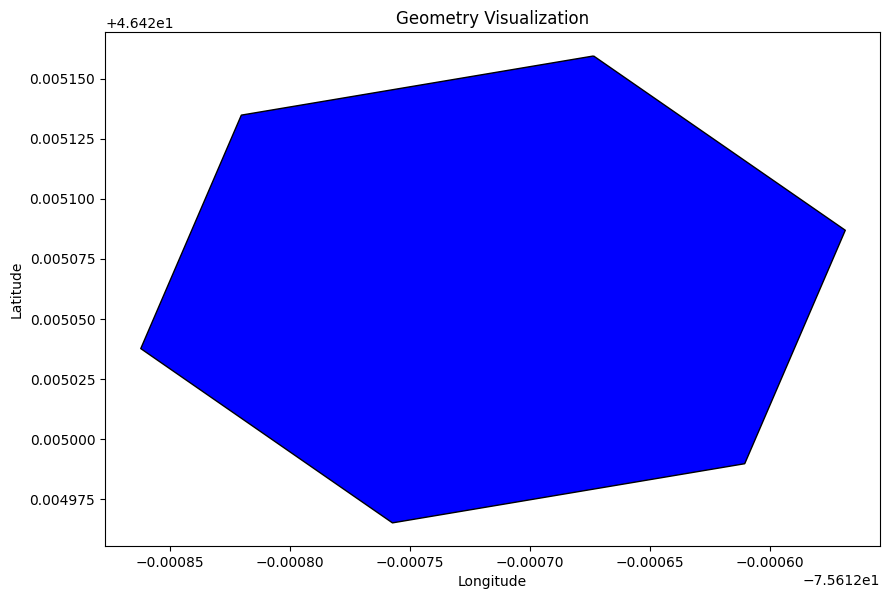

In [27]:
import matplotlib.pyplot as plt

# Select a row from processed_species
row_geometry = processed_species.iloc[0]['geometry']

# Plot the geometry
fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoSeries(row_geometry).plot(ax=ax, color='blue', edgecolor='black')
plt.title('Geometry Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

(-79.76666666666667, -57.099999999999994, 44.98333333333333, 62.58333333333333)


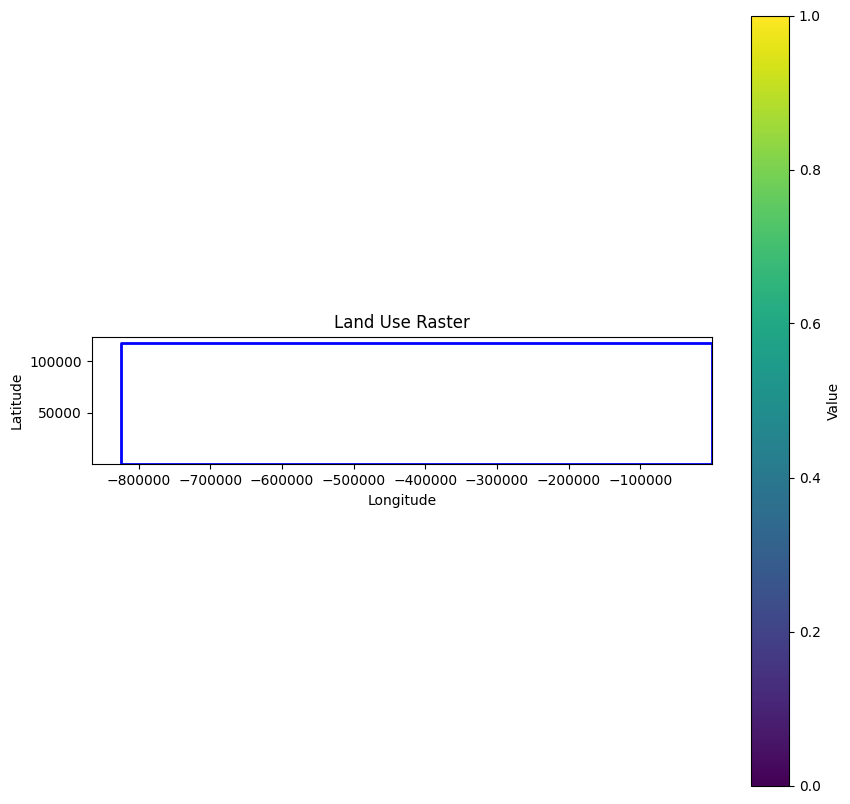

In [289]:
geom = processed_species['geometry']

# Open the raster file
#raster_path = "../data/data_layers/worldClim/clipped_wc2.1_30s_bio_1.tif"
#raster_path = "../data/data_layers/soil_grid/Solonetz.tif"
raster_path = "../data/data_layers/worldClim/clipped_wc2.1_30s_bio_1.tif"
#raster_path = "../data/data_layers/predictors_100_QC_alluvion.tif"
with rasterio.open(raster_path) as src:
    window = from_bounds(left = reduced_extent[0], bottom = reduced_extent[2], right=reduced_extent[1], top=reduced_extent[3], transform=src.transform)
    # Read the data within the window
    raster_data = src.read(1, window=window)  # Read the first band of the raster
    window_transform = src.window_transform(window)
    extent = rasterio.plot.plotting_extent(raster_data, window_transform)  # Get the extent of the raster
    print(extent)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', extent=extent)
# Plot the geometry on top of the raster
# Ensure geom contains individual geometries
if isinstance(geom, gpd.GeoSeries):
    geom_to_plot = geom
else:
    geom_to_plot = gpd.GeoSeries(geom)

# Plot the geometry on top of the raster
geom_to_plot.plot(ax=plt.gca(), color='red', edgecolor='black', alpha=0.5)

# Plot the bounding box on the figure
#bounding_box = box(reduced_extent[0], reduced_extent[2], reduced_extent[1], reduced_extent[3])
bounding_box = POE_TOT.total_bounds
#bounding_box = box(bounding_box[0], bounding_box[1], bounding_box[2], bounding_box[3])
bounding_box = box(bounding_box[0], bounding_box[1], -65, 52)
bounding_box_gdf = gpd.GeoDataFrame(geometry=[bounding_box], crs="EPSG:4326")
bounding_box_gdf.boundary.plot(ax=plt.gca(), color='blue', linewidth=2, label='Bounding Box')

# Add a colorbar
plt.colorbar(label='Value')
plt.title('Land Use Raster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [260]:
bounding_box.bounds

(-79.506411, 45.000945, -65.0, 52.0)

july 15: added a new fn to expand an hex to a square so i can feed squares to the cnn instead of hexagons. I hope it might help learning more important features that the hexagons edges

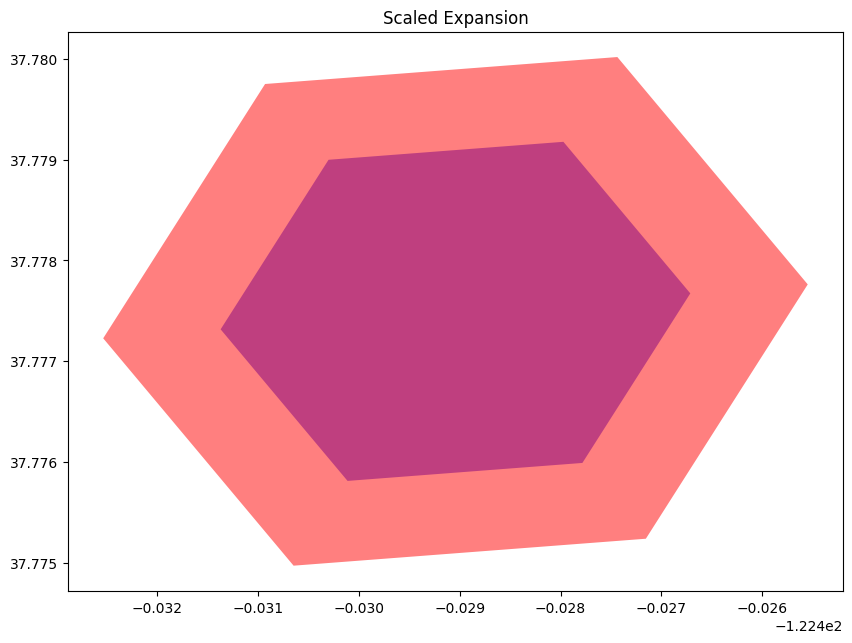

In [127]:
import matplotlib.pyplot as plt

import h3
import geopandas as gpd
from shapely.geometry import Polygon, Point
from shapely.affinity import scale

def expand_hexagon(h3_index, to_crs, expansion_factor):
    """
    Uniformly expands a hexagon by scaling from its centroid and reprojects to the target CRS.
    
    Args:
        h3_index: H3 hexagon index
        to_crs: Target CRS (e.g., 'EPSG:4326' or CRS object)
        expansion_factor: Multiplier for expansion (1.1 = 10% larger)
    
    Returns:
        Expanded Polygon geometry in the target CRS
    """
    # Get hexagon boundary as list of (lat,lng) points
    hex_boundary = h3.cell_to_boundary(h3_index)
    flipped = tuple(coord[::-1] for coord in hex_boundary)
    hex_poly = Polygon(flipped)

    # Create GeoSeries for reprojection
    hex_gs = gpd.GeoSeries([hex_poly], crs="EPSG:4326")
    hex_gs = hex_gs.to_crs(to_crs)
    hex_poly_proj = hex_gs.iloc[0]

    # Scale the polygon from its centroid
    expanded_poly = scale(hex_poly_proj, 
                         xfact=expansion_factor, 
                         yfact=expansion_factor, 
                         origin='centroid')
    return expanded_poly

def expand_hexagon_to_square(h3_index, to_crs, expansion_factor=1.0):
    """
    Transforms an H3 hexagon into its encompassing square bounding box,
    and then optionally expands that square from its centroid. Reprojects to the target CRS.

    Args:
        h3_index (str): H3 hexagon index.
        to_crs: Target CRS (e.g., 'EPSG:4326' or CRS object)
        expansion_factor (float): Multiplier for the side length of the bounding square.
                                  1.0 means the smallest square tightly bounding the hexagon.
                                  1.1 means 10% larger than the bounding square.

    Returns:
        shapely.geometry.Polygon: The expanded square geometry in the target CRS.
    """
    # Get hexagon boundary as list of (lat,lng) points
    hex_boundary = h3.cell_to_boundary(h3_index)
    flipped_coords = [(lon, lat) for lat, lon in hex_boundary]
    hex_poly = Polygon(flipped_coords)

    # Create GeoSeries for reprojection
    hex_gs = gpd.GeoSeries([hex_poly], crs="EPSG:4326")
    hex_gs = hex_gs.to_crs(to_crs)
    hex_poly_proj = hex_gs.iloc[0]

    # Get the bounding box of the projected hexagon
    minx, miny, maxx, maxy = hex_poly_proj.bounds
    side_length = max(maxx - minx, maxy - miny)
    expanded_side_length = side_length * expansion_factor

    centroid_x, centroid_y = hex_poly_proj.centroid.x, hex_poly_proj.centroid.y
    half_side = expanded_side_length / 2.0
    square_minx = centroid_x - half_side
    square_miny = centroid_y - half_side
    square_maxx = centroid_x + half_side
    square_maxy = centroid_y + half_side

    square_poly = Polygon([
        (square_minx, square_miny),
        (square_maxx, square_miny),
        (square_maxx, square_maxy),
        (square_minx, square_maxy),
        (square_minx, square_miny)
    ])
    return square_poly

def plot_hexagons(original, expanded, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    gpd.GeoSeries([original]).plot(ax=ax, color='blue', alpha=0.5)
    gpd.GeoSeries([expanded]).plot(ax=ax, color='red', alpha=0.5)
    plt.title(title)
    plt.show()

# Example visualization
hex_id = '89283082837ffff'
original_hex = h3.cell_to_boundary(hex_id)
original_hex = tuple(coord[::-1] for coord in original_hex)
# Create Shapely polygon
original_hex = Polygon(original_hex)

# Compare different methods
expanded_scale = expand_hexagon(hex_id, 'EPSG:4326', 1.5)

plot_hexagons(original_hex, expanded_scale, "Scaled Expansion")

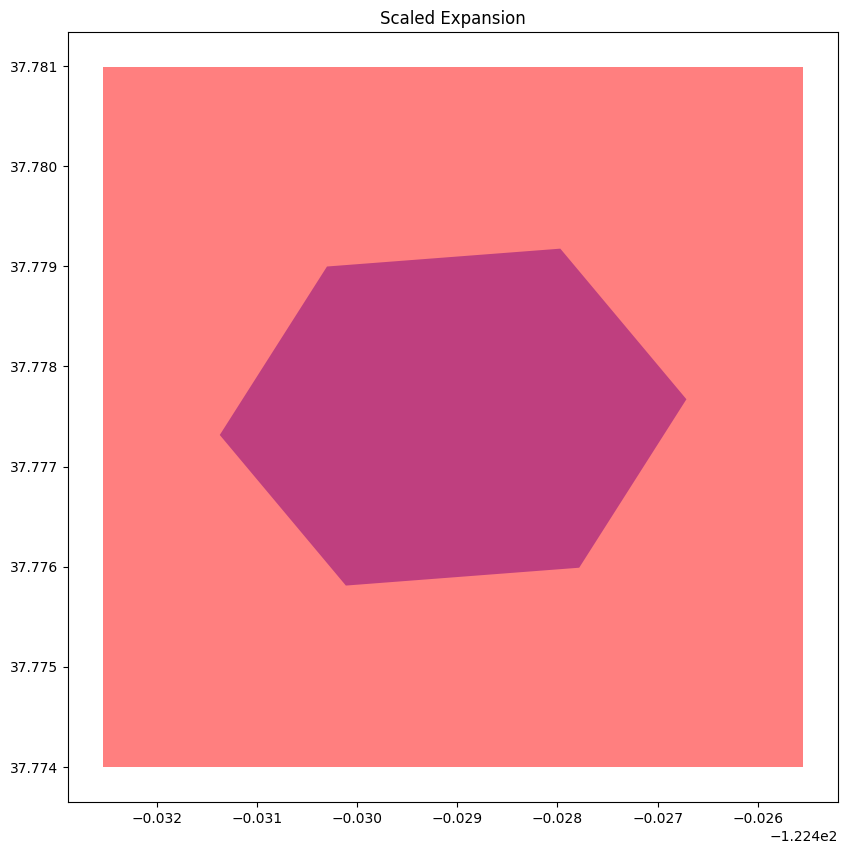

In [506]:
expanded_scale_square = expand_hexagon_to_square(hex_id,'EPSG:4326', 1.5)

plot_hexagons(original_hex, expanded_scale_square, "Scaled Expansion")

In [8]:
def vis_one_band_raster(out_images, clipped_bounds, side_by_side=False):
    """
    Visualize multiple single-band raster images.

    Parameters:
    ----------
    out_images : list of numpy.ndarray
        List of raster images to visualize.
    clipped_bounds : tuple
        Tuple containing the bounds (left, bottom, right, top) for the extent.
    side_by_side : bool, optional
        If True, plots the images side by side. Otherwise, overlays them.
    """
    left, bottom, right, top = clipped_bounds
    extent = (left, right, bottom, top)
    
    fig, axes = plt.subplots(1, len(out_images), figsize=(15, 10))
    for i, out_image in enumerate(out_images):
        ax = axes[i] if len(out_images) > 1 else axes
        im = ax.imshow(
            out_image, 
            cmap='viridis', 
            extent=extent
        )
        ax.set_title(f'Raster {i+1}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        #cbar = plt.colorbar(im, ax=ax, orientation='vertical')
        #cbar.set_label('Normalized Value')

    plt.show()
# Define a function to normalize each band using percentiles
def normalize_band(band, min_percentile=2, max_percentile=98):
    if band.size == 0:
        raise ValueError("Band is empty")
    vmin = np.percentile(band, min_percentile)  # Lower bound
    vmax = np.percentile(band, max_percentile)  # Upper bound
    band = np.clip(band, vmin, vmax)  # Clip values outside percentile range
    return (band - vmin) / (vmax - vmin)  # Normalize to [0, 1]

def vis_rgb_raster(out_image, clipped_bounds):
    # Access the elements of the tuple directly
    left, bottom, right, top = clipped_bounds
    plt.figure(figsize=(10, 10))
    extent = (left, right, bottom, top)
    
    rgb_image = np.stack([
            normalize_band(out_image[0]),  # Normalize Red
            normalize_band(out_image[1]),  # Normalize Green
            normalize_band(out_image[2])   # Normalize Blue
    ], axis=-1)
    plt.imshow(rgb_image, extent=extent)
    plt.title('RGB Composite')
    

POLYGON ((-74.89547259844491 47.09130063636324, -74.89562190735727 47.09127680950957, -74.89566602773687 47.091179322527566, -74.89556083971694 47.09110566254272, -74.8954115313614 47.091129489289074, -74.89536741046898 47.09122697612759, -74.89547259844491 47.09130063636324))


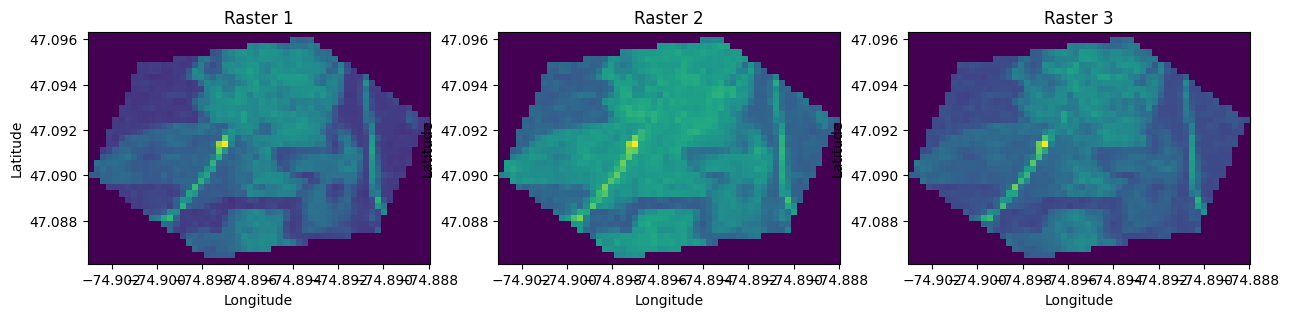

In [122]:
import matplotlib.pyplot as plt

geom = processed_species['geometry'].values[1040]
h3_cell = processed_species['h3_index'].values[1040]
expanded_geom = expand_hexagon(h3_cell, 50)  # Expand the hexagon by 10% of its size
#print(expanded_geom)
print(geom)
out_image, clipped_bounds = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif")
#out_image, clipped_bounds = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif")


# Plot the normalized data with color scale from 0 to 1
vis_one_band_raster(out_image, clipped_bounds)
# Plot the RGB composite
#vis_rgb_raster(out_image, clipped_bounds)

In [84]:
results = extract_raster_values_for_multiple_h3_chunked(
    geometries=expanded_geom,
    raster_path="../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif",
    #raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif",
    chunk_size_mb=5000  # Adjust based on your memory constraints
)

Raster size 72692.86 MB exceeds chunk size 5000 MB. Using chunked processing.


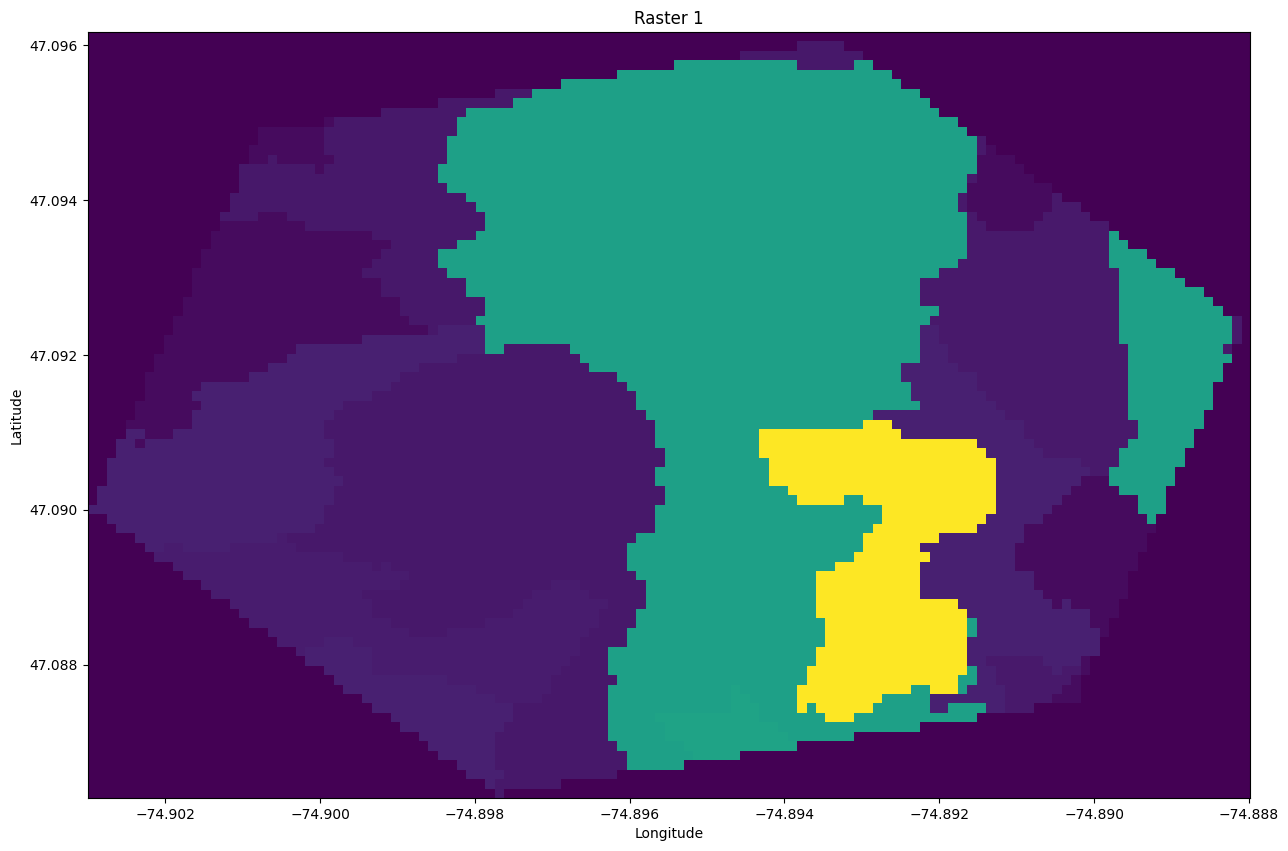

In [85]:
output, bounds = results[0]  # Assuming results is a list of tuples

vis_one_band_raster(output, bounds)

In [19]:
geom = processed_species.iloc[1000]
add_raster_values_to_geodf(
        raster_path="../data/data_layers/worldClim/clipped_wc2.1_30s_bio_1.tif",
        geodf=processed_species[1000:1001],
        column_name=col_name
)

NameError: name 'col_name' is not defined

In [380]:
# Calculate zonal statistics
from rasterstats import zonal_stats

stats = ['min', 'max', 'mean']
proc_spec = processed_species.copy()
z_stats = zonal_stats(
                vectors=expand_hexagon(proc_spec['h3_index'].values[1000:1001][0], 50),
                raster="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif",
                stats=stats,
                #layer=1,
                all_touched=False, 
                )

### Extracting zonal stats from hexagons


In [20]:
#read csv
import pandas as pd
land_use_labels = pd.read_csv('../data/misc/utilisation_territoire_labels.csv')

In [21]:
category_map = dict(zip(land_use_labels['CODE_UT'].astype(float), land_use_labels['Classe détaillée']))

In [274]:
proc_spec = processed_species.copy()
geom = proc_spec['geometry'].values[0:10]

In [ ]:
# # Calculate zonal statistics
# from rasterstats import zonal_stats


# #concat the category map with proc_spec
# z_stats = zonal_stats(
#         vectors=proc_spec['geometry'].values,
#         raster='../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif',
#         layer=1,
#         all_touched=False,
#         categorical=True,
#         category_map = category_map,    
#                 )
# # Convert to DataFrame
# z_stats_df = pd.DataFrame(z_stats)
# # Add the h3_index to the DataFrame
# z_stats_df['h3_index'] = proc_spec['h3_index'].values

# # #save to csv
# z_stats_df.to_csv('cat_zonal_stats_res_13.csv', index=False)

In [ ]:
# # Calculate zonal statistics
# from rasterstats import zonal_stats

# stats = ['mean', 'min', 'max']
# proc_spec = processed_species.copy()
# #remove utilisation_territoire_2020_reprojected from the list of file_paths
# file_paths_t = [f for f in file_paths if 'utilisation_territoire_2020_reprojected' not in f]
# for i, file_path in enumerate(file_paths_t):
#         col_name = file_names[i]
#         print(f"Processing {file_path}")
#         z_stats = zonal_stats(
#                         vectors=proc_spec['geometry'].values,
#                         raster=file_path,
#                         stats=stats,
#                         layer=1,
#                         all_touched=False,
#                 )
#         # Convert z_stats into a DataFrame
#         z_stats_df = pd.DataFrame(z_stats)

#         # Add the statistics to processed_species
#         proc_spec = proc_spec.iloc[:len(z_stats)].copy()  # Ensure lengths match
#         # Add mean, min, and max columns only if stats are available
#         proc_spec[f'{col_name}_mean'] = z_stats_df.get('mean', np.nan)
#         proc_spec[f'{col_name}_min'] = z_stats_df.get('min', np.nan)
#         proc_spec[f'{col_name}_max'] = z_stats_df.get('max', np.nan)
# #save df
# proc_spec.to_csv('zonal_stats_res_13.csv', index=False)

Processing ../data/data_layers/soil_grid/Umbrisols.tif
Processing ../data/data_layers/soil_grid/Chernozems.tif
Processing ../data/data_layers/soil_grid/Cryosols.tif
Processing ../data/data_layers/soil_grid/Regosols.tif
Processing ../data/data_layers/soil_grid/Gleysols.tif
Processing ../data/data_layers/soil_grid/Leptosols.tif
Processing ../data/data_layers/soil_grid/Gypsisols.tif
Processing ../data/data_layers/soil_grid/Solonchaks.tif
Processing ../data/data_layers/soil_grid/Nitisols.tif
Processing ../data/data_layers/soil_grid/Arenosols.tif
Processing ../data/data_layers/soil_grid/Andosols.tif
Processing ../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif
Processing ../data/data_layers/soil_grid/Ferralsols.tif
Processing ../data/data_layers/soil_grid/Phaeozems.tif
Processing ../data/data_layers/soil_grid/Vertisols.tif
Processing ../data/data_layers/soil_grid/Alisols.tif
Processing ../data/data_layers/soil_grid/Podzols.tif
Processing ../data/data_layers/soil_grid/Fluvisols.tif
Process

In [85]:
from rasterstats import zonal_stats
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import time

def get_centroid_value(geometry, raster_path):
    """Get raster value at geometry's centroid"""
    with rasterio.open(raster_path) as src:
        # Reproject geometry to match raster CRS
        geom = gpd.GeoSeries([geometry], crs=geometry.crs).to_crs(src.crs)[0]
        centroid = geom.centroid
        
        try:
            row, col = src.index(centroid.x, centroid.y)
            value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
            return value
        except (IndexError, ValueError):
            return np.nan
def get_centroid_values(geometries, raster_path):
    """Get raster values at geometries' centroids"""
    with rasterio.open(raster_path) as src:
        # Reproject geometries to match raster CRS
        geom_series = gpd.GeoSeries(geometries, crs=geometries.crs).to_crs(src.crs)
        values = []
        for geom in geom_series:
            centroid = geom.centroid
            try:
                row, col = src.index(centroid.x, centroid.y)
                value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                values.append(value)
            except (IndexError, ValueError):
                values.append(np.nan)
        return values

def should_use_centroid(geometries, raster_path, sample_size=5):
    """Check if we should use centroid sampling for this raster"""
    with rasterio.open(raster_path) as src:
        # Get raster resolution
        res_x, res_y = src.res
        pixel_area = abs(res_x * res_y)
        
        # Check sample of geometries
        sample_idx = np.random.choice(len(geometries), min(sample_size, len(geometries)), replace=False)
        sample_geoms = gpd.GeoSeries([geometries[i] for i in sample_idx], crs=geometries.crs).to_crs(src.crs)

        # Count how many are smaller than a pixel
        small_count = sum(1 for geom in sample_geoms if geom.area < pixel_area)
        return small_count / len(sample_geoms) > 0.8  # Use centroid if >80% are small

# Main processing function
def process_rasters(proc_spec, file_paths, file_names, category_map=None):
    # Prepare results storage
    continuous_data = {}
    categorical_data = {'h3_index': proc_spec['h3_index'].values}
    
    for i, file_path in enumerate(file_paths):
        col_name = file_names[i]
        #print(f"Processing {file_path}")
        
        # Special handling for categorical raster
        if 'utilisation_territoire' in file_path:
            if should_use_centroid(proc_spec['geometry'].values, file_path):
                # Centroid sampling for categorical data
                #values = [get_centroid_value(geom, file_path) for geom in proc_spec['geometry'].values]
                values = get_centroid_values(proc_spec['geometry'].values, file_path)
                categorical_data['landuse_value'] = values
                #categorical_data['landuse_method'] = ['centroid'] * len(values)
                
                # Map category numbers to names
                if category_map:
                    categorical_data['landuse_category'] = [
                        category_map.get(int(val), 'Unknown') if not np.isnan(val) else 'Unknown' 
                        for val in values
                    ]

            else:
                # Proper categorical zonal stats
                start = time.time()
                z_stats = zonal_stats(
                    vectors=proc_spec['geometry'].values,
                    raster=file_path,
                    categorical=True,
                    category_map=category_map,
                    all_touched=False
                )
                end = time.time()
                print(f"Zonal stats took {end - start:.2f} seconds")
                start = time.time()
                # Flatten categorical results
                for idx, stats in enumerate(z_stats):
                    for cat, count in stats.items():
                        if cat != 'h3_index':
                            col = f'landuse_{cat}'
                            if col not in categorical_data:
                                categorical_data[col] = [0] * len(z_stats)
                            categorical_data[col][idx] = count
                end = time.time()
                print(f"Flattening took {end - start:.2f} seconds")
                #categorical_data['landuse_method'] = ['zonal_stats'] * len(z_stats)
        else:
            # Continuous raster processing
            if should_use_centroid(proc_spec['geometry'].values, file_path):
                # Centroid sampling
                #values = [get_centroid_value(geom, file_path) for geom in proc_spec['geometry'].values]
                values = get_centroid_values(proc_spec['geometry'].values, file_path)
                continuous_data[f'{col_name}_value'] = values
                #continuous_data[f'{col_name}_method'] = ['centroid'] * len(values)
            else:
                # Zonal stats
                z_stats = zonal_stats(
                    vectors=proc_spec['geometry'].values,
                    raster=file_path,
                    stats=['mean', 'min', 'max'],
                    all_touched=False
                )
                
                continuous_data[f'{col_name}_value'] = [s.get('mean', np.nan) for s in z_stats]
                continuous_data[f'{col_name}_min'] = [s.get('min', np.nan) for s in z_stats]
                continuous_data[f'{col_name}_max'] = [s.get('max', np.nan) for s in z_stats]
    
    # Create final DataFrames
    continuous_df = gpd.GeoDataFrame(
        {**continuous_data, 'geometry': proc_spec['geometry'].values},
        crs=proc_spec.crs
    )
    continuous_df['h3_index'] = proc_spec['h3_index'].values
    
    categorical_df = pd.DataFrame(categorical_data)
    categorical_df['h3_index'] = proc_spec['h3_index'].values
    
    return continuous_df, categorical_df

In [89]:
#get all the files from ../data/data_layers/predictors_100_QC/
import os
folder_path = '../data/data_layers/predictors_100_QC_normalized/'
exclude = ['mhc', 'twi', 'combined_mask']
#folder_path = '../data/data_layers/worldClim/'
file_paths = []
file_names = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_name = os.path.splitext(file)[0]
        if(file_name in exclude):
            print("exluding")
            continue
        full_path = os.path.join(root, file)
        file_paths.append(full_path)
        file_names.append(os.path.splitext(file)[0])

exluding


In [84]:
processed_species

h3_index                                       species_list  \
0      8c0e412132debff  [BEG, LEG, DIS, POS, EPN, KAA, PTC, CLM, CON, ...   
1      8c0e412132eadff  [SPF, BEG, LEG, DIS, SPS, POS, EPN, RUC, CLM, ...   
2      8c0e412331045ff  [LYL, LEG, DIS, EPB, LYP, BOP, EPN, VAV, PTC, ...   
3      8c0e412331105ff  [RUI, LYL, LEG, DIS, EPB, LYP, BOP, EPN, VAV, ...   
4      8c0e41233843bff  [SPF, LEG, DIS, SPS, POS, EPN, KAA, VAV, PTC, ...   
...                ...                                                ...   
24955  8c2bb6d6d52b3ff  [PES, SPF, LEG, DIS, SPS, EPN, KAA, PTC, RUC, ...   
24956  8c2bb6d6d52c3ff  [PES, SPF, LEG, DIS, SPS, EPN, KAA, PTC, RUC, ...   
24957  8c2bb6d6dc163ff  [PES, SPF, LEG, DIS, SPS, EPN, KAA, PTC, AUR, ...   
24958  8c2bb6d6dc365ff  [SPF, LEG, SPS, EPN, KAA, PTC, CON, EQY, LYA, ...   
24959  8c2bb6d6dc8d9ff  [SPF, LEG, DIS, SPS, EPN, KAA, RUC, EQY, CLS, ...   

       species_count                                           geometry  \
0                 25  POLYGON ((-68.56565 51.9234, -68.56582 51.9233...   
1                 30  POLYGON ((-68.56283 51.92357, -68.563 51.92355...   
2                 39  POLYGON ((-68.47925 51.97735, -68.47941 51.977...   
3                 45  POLYGON ((-68.4816 51.97741, -68.48177 51.9773...   
4                 33  POLYGON ((-68.46858 51.9761, -68.46875 51.9760...   
...              ...                                                ...   
24955             29  POLYGON ((-77.61504 50.66755, -77.6152 50.6675...   
24956             33  POLYGON ((-77.61439 50.66841, -77.61455 50.668...   
24957             29  POLYGON ((-77.61145 50.6723, -77.61161 50.6722...   
24958             21  POLYGON ((-77.61039 50.67343, -77.61055 50.673...   
24959             28  POLYGON ((-77.61296 50.67044, -77.61312 50.670...   

                                          expanded_cells  
0      POLYGON ((-5647.544829591932 882170.6141373665...  
1      POLYGON ((-5455.011639203469 882188.7353444393...  
2      POLYGON ((253.005365818849 888213.2307860883, ...  
3      POLYGON ((92.51487885701681 888220.3304415558,...  
4      POLYGON ((980.7753838126332 888074.525047952, ...  
...                                                  ...  
24955  POLYGON ((-639863.7048803442 781836.5866301467...  
24956  POLYGON ((-639806.0470757738 781926.8174332724...  
24957  POLYGON ((-639546.5837988507 782332.8630732566...  
24958  POLYGON ((-639457.105576824 782448.2017063292,...  
24959  POLYGON ((-639677.8107817394 782139.8448432486...  

[24960 rows x 5 columns]

In [90]:
# Execute processing
continuous_results, categorical_results = process_rasters(
    proc_spec=processed_species.copy(),
    file_paths=file_paths,  # Include all file paths
    file_names=file_names,
    category_map=None
)
continuous_results

continuous_results.to_csv('../data/data_layers/model_inputs/cell_data/continuous_zonal_stats_res_12_pred_100_QC_normalized.csv', index=False)
# # Save results
# continuous_results.to_csv('continuous_zonal_stats_res_12.csv', index=False)
# categorical_results.to_csv('cat_zonal_stats_res_12.csv', index=False)

In [84]:
print(continuous_results.isna().sum().sort_values(ascending=True))


temperate_grass_value                                             0
mean_diurnal_air_temperature_range_value                          0
mean_daily_mean_air_temperatures_of_the_driest_quarter_value      0
marecage_value                                                    0
tourbiere_indifferenciee_value                                    0
                                                                 ..
eolien_value                                                      0
mean_monthly_precipitation_amount_of_the_coldest_quarter_value    0
glaciaire_value                                                   0
geometry                                                          0
h3_index                                                          0
Length: 69, dtype: int64


In [72]:
#display rows with nan values
nan_rows = continuous_results[continuous_results.isna().any(axis=1)]
print("Rows with NaN values in continuous results:")
print(nan_rows)

Rows with NaN values in continuous results:
Empty GeoDataFrame
Columns: [temperate_grass_value, mean_diurnal_air_temperature_range_value, mean_daily_mean_air_temperatures_of_the_driest_quarter_value, marecage_value, tourbiere_indifferenciee_value, mean_monthly_precipitation_amount_of_the_wettest_quarter_value, mean_monthly_precipitation_amount_of_the_warmest_quarter_value, precipitation_amount_of_the_driest_month_value, water_value, depot_value, tourbiere_minerotrophe_value, mean_daily_mean_air_temperatures_of_the_coldest_quarter_value, sand_value, lai_value, wetland_value, deciduous_value, marais_value, mean_daily_mean_air_temperatures_of_the_warmest_quarter_value, soil_organic_carbon_value, bulk_density_value, mean_daily_minimum_air_temperature_of_the_coldest_month_value, annual_range_of_air_temperature_value, clay_value, coniferous_value, mixed_value, silt_value, mean_annual_air_temperature_value, roche_value, precipitation_amount_of_the_wettest_month_value, taiga_value, glaciolacus

In [58]:
continuous_results.nunique()

temperate_grass_value                                              3200
mean_diurnal_air_temperature_range_value                           1286
mean_daily_mean_air_temperatures_of_the_driest_quarter_value       2790
marecage_value                                                     6203
tourbiere_indifferenciee_value                                      160
                                                                  ...  
eolien_value                                                         51
mean_monthly_precipitation_amount_of_the_coldest_quarter_value     8349
glaciaire_value                                                     539
geometry                                                          24933
h3_index                                                          24933
Length: 69, dtype: int64

In [65]:
#normalize the continuous results
def normalize_column(df, col_name):
    """Normalize a column in a DataFrame to range [0, 1]"""
    if col_name in df.columns:
        vmin = df[col_name].min()
        vmax = df[col_name].max()
        if(vmax == 1):
            print(f"Column {col_name} is already normalized, skipping")
            return df
        if vmax - vmin > 0:  # Avoid division by zero
            df[col_name] = (df[col_name] - vmin) / (vmax - vmin)
        else:
            print(f"Column {col_name} has no variation, dropping")
            #df[col_name] = 0.5  # If all values are the same, set to mid-point
            df.drop(columns=[col_name], inplace=True)
    return df
def normalize_continuous_data(df):
    """Normalize all continuous columns in a DataFrame"""
    for col in df.columns:
        if col.endswith('_value') or col.endswith('_mean') or col.endswith('_min') or col.endswith('_max'):
            df = normalize_column(df, col)
    return df

continuous_results = continuous_results[(continuous_results != -9999).all(axis=1)]
continuous_results_normalized = continuous_results.copy()
continuous_results_normalized = normalize_continuous_data(continuous_results_normalized)

Column temperate_grass_value is already normalized, skipping
Column marin_value has no variation, dropping
Column marecage_value is already normalized, skipping
Column tourbiere_indifferenciee_value is already normalized, skipping
Column water_value is already normalized, skipping
Column depot_value is already normalized, skipping
Column deciduous_value is already normalized, skipping
Column coniferous_value is already normalized, skipping
Column mixed_value is already normalized, skipping
Column roche_value is already normalized, skipping
Column glaciolacustre_value is already normalized, skipping
Column temperate_shrub_value is already normalized, skipping
Column snow_value has no variation, dropping
Column glaciomarin_value is already normalized, skipping
Column till_value is already normalized, skipping
Column cropland_value is already normalized, skipping
Column organique_value is already normalized, skipping
Column tourbiere_ombrotrophe_value is already normalized, skipping
Colum

In [72]:
#get stats for the continuous results
continuous_stats = continuous_results_normalized.describe().transpose()
continuous_stats['range'] = continuous_stats['max'] - continuous_stats['min']
continuous_stats = continuous_stats.sort_values(by='mean', ascending=False)
continuous_stats[45:]

count      mean       std  min  25%  50%  \
temperate_grass_value           24933.0  0.042499  0.139619  0.0  0.0  0.0   
tourbiere_boisee_value          24933.0  0.039991  0.151860  0.0  0.0  0.0   
quaternaire_value               24933.0  0.039203  0.189762  0.0  0.0  0.0   
water_value                     24933.0  0.030280  0.095261  0.0  0.0  0.0   
organique_value                 24933.0  0.025547  0.150347  0.0  0.0  0.0   
tourbiere_ombrotrophe_value     24933.0  0.014956  0.082029  0.0  0.0  0.0   
cropland_value                  24933.0  0.014874  0.082435  0.0  0.0  0.0   
alluvion_value                  24933.0  0.013771  0.109884  0.0  0.0  0.0   
depot_value                     24933.0  0.013083  0.107232  0.0  0.0  0.0   
urban_value                     24933.0  0.011308  0.044552  0.0  0.0  0.0   
tourbiere_minerotrophe_value    24933.0  0.007620  0.049815  0.0  0.0  0.0   
wetland_value                   24933.0  0.005743  0.038798  0.0  0.0  0.0   
marais_value                    24933.0  0.004501  0.038462  0.0  0.0  0.0   
lacustre_value                  24933.0  0.004241  0.054622  0.0  0.0  0.0   
eolien_value                    24933.0  0.003560  0.058015  0.0  0.0  0.0   
tourbiere_indifferenciee_value  24933.0  0.001980  0.032377  0.0  0.0  0.0   
taiga_value                     24933.0  0.001039  0.020446  0.0  0.0  0.0   
eau_peu_profonde_value          24933.0  0.000588  0.015830  0.0  0.0  0.0   
barren_value                    24933.0  0.000516  0.014259  0.0  0.0  0.0   
prairie_humide_value            24933.0  0.000378  0.014702  0.0  0.0  0.0   
polar_grass_value               24933.0  0.000204  0.011910  0.0  0.0  0.0   
indifferencie_value             24933.0  0.000122  0.008569  0.0  0.0  0.0   

                                75%  max  range  
temperate_grass_value           0.0  1.0    1.0  
tourbiere_boisee_value          0.0  1.0    1.0  
quaternaire_value               0.0  1.0    1.0  
water_value                     0.0  1.0    1.0  
organique_value                 0.0  1.0    1.0  
tourbiere_ombrotrophe_value     0.0  1.0    1.0  
cropland_value                  0.0  1.0    1.0  
alluvion_value                  0.0  1.0    1.0  
depot_value                     0.0  1.0    1.0  
urban_value                     0.0  1.0    1.0  
tourbiere_minerotrophe_value    0.0  1.0    1.0  
wetland_value                   0.0  1.0    1.0  
marais_value                    0.0  1.0    1.0  
lacustre_value                  0.0  1.0    1.0  
eolien_value                    0.0  1.0    1.0  
tourbiere_indifferenciee_value  0.0  1.0    1.0  
taiga_value                     0.0  1.0    1.0  
eau_peu_profonde_value          0.0  1.0    1.0  
barren_value                    0.0  1.0    1.0  
prairie_humide_value            0.0  1.0    1.0  
polar_grass_value               0.0  1.0    1.0  
indifferencie_value             0.0  1.0    1.0

In [73]:
continuous_results_normalized.to_csv('continuous_zonal_stats_res_12_normalized_predictors_100_QC.csv', index=False)

In [420]:
def post_process_continuous(continuous_df):
    """
    Simplifies continuous results DataFrame by removing redundant columns when 
    min, max and value (mean) are identical for the same raster.
    
    Parameters:
    -----------
    continuous_df : GeoDataFrame
        The continuous results DataFrame with columns in format:
        {raster_name}_value, {raster_name}_min, {raster_name}_max, etc.
    
    Returns:
    --------
    GeoDataFrame
        Simplified DataFrame with redundant columns removed
    """
    # Make a copy to avoid modifying the original
    df = continuous_df.copy()
    
    # Identify all unique raster base names
    columns = [col for col in df.columns if not col in ['geometry', 'h3_index']]
    raster_names = list(set([col.split('_')[0] for col in columns if '_value' in col or '_min' in col or '_max' in col]))
    
    columns_to_drop = []
    
    for raster in raster_names:
        value_col = f"{raster}_value"
        min_col = f"{raster}_min"
        max_col = f"{raster}_max"
        
        # Check if all three columns exist
        if all(col in df.columns for col in [value_col, min_col, max_col]):
            
            # Check if all values are identical across the three columns
            if (df[value_col] == df[min_col]).all() and (df[value_col] == df[max_col]).all():
                print(f"All values are identical for {raster}. Dropping min and max columns.")
                # Mark min and max columns for removal
                columns_to_drop.extend([min_col, max_col])
                
                # Update method column if exists
                method_col = f"{raster}_method"
                if method_col in df.columns:
                    df[method_col] = df[method_col].replace({'zonal_stats': 'single_value'})
    
    # Drop redundant columns
    df = df.drop(columns=columns_to_drop)
    
    return df
# Usage example:
simplified_df = post_process_continuous(continuous_results)
#simplified_df.to_csv('simplified_continuous_stats.csv', index=False)

#### Extracting zonal stats for regions

From my tests its useless to expand less than 10x since the raster resolution is pretty low

In [174]:
import numpy as np

# Create an array starting at 1.25 and multiply each term by 1.25 until it exceeds 5
factors = 1.25 * np.array([1.25**i for i in range(int(np.log(8/1.25)/np.log(1.25)) + 1)])
print(factors)


[1.25       1.5625     1.953125   2.44140625 3.05175781 3.81469727
 4.76837158 5.96046448 7.4505806 ]


In [176]:
for factor in factors:
    print(f"Processing with factor: {factor}")
    #Execute processing
    proc_spec = processed_species.copy()
    #15x is the minimum size to get zonal stats on gridsoil and satelitte data
    proc_spec['geometry'] = proc_spec['h3_index'].apply(lambda h3_index: expand_hexagon(h3_index, factor))

    continuous_results_x10, categorical_results_x10 = process_rasters(
        proc_spec=proc_spec.copy(),
        file_paths=file_paths,  # Include all file paths
        file_names=file_names,
        category_map=category_map
    )

    # Save results
    continuous_results_x10.to_csv(f'../data/misc/continuous_zonal_stats_res_12_x{factor}.csv', index=False)
    categorical_results_x10.to_csv(f'../data/misc/cat_zonal_stats_res_12.csv_x{factor}.csv', index=False)

Processing with factor: 1.25
Zonal stats took 15.87 seconds
Flattening took 0.00 seconds
Processing with factor: 1.5625
Zonal stats took 17.34 seconds
Flattening took 0.01 seconds
Processing with factor: 1.953125
Zonal stats took 19.35 seconds
Flattening took 0.00 seconds
Processing with factor: 2.44140625
Zonal stats took 21.41 seconds
Flattening took 0.00 seconds
Processing with factor: 3.0517578125
Zonal stats took 24.38 seconds
Flattening took 0.00 seconds
Processing with factor: 3.814697265625
Zonal stats took 27.99 seconds
Flattening took 0.00 seconds
Processing with factor: 4.76837158203125
Zonal stats took 32.38 seconds
Flattening took 0.01 seconds
Processing with factor: 5.9604644775390625
Zonal stats took 37.78 seconds
Flattening took 0.01 seconds
Processing with factor: 7.450580596923828
Zonal stats took 44.45 seconds
Flattening took 0.01 seconds


In [27]:
# Save results
continuous_results_x10.to_csv('continuous_zonal_stats_res_12_x10.csv', index=False)
categorical_results_x10.to_csv('cat_zonal_stats_res_12.csv_x10.csv', index=False)

In [439]:
continuous_results_x10

Umbrisols_value  Chernozems_value  Cryosols_value  Regosols_value  \
0                   0                 1               0               1   
1                   0                 1               0               1   
2                   0                 0               0               1   
3                   0                 0               0               1   
4                   0                 1               0               1   
...               ...               ...             ...             ...   
4615                0                 0               0               0   
4616                0                 0               0               0   
4617                0                 0               0               0   
4618                0                 0               0               0   
4619                0                 0               0               0   

      Gleysols_value  Leptosols_value  Gypsisols_value  Solonchaks_value  \
0                  8                0                0                 0   
1                 10                0                0                 0   
2                  9                0                0                 0   
3                 12                1                0                 0   
4                 17                1                0                 0   
...              ...              ...              ...               ...   
4615              14                0                0                 0   
4616              16                0                0                 0   
4617              14                0                0                 0   
4618              11                0                0                 0   
4619              19                0                0                 0   

      Nitisols_value  Arenosols_value  ...  clipped_wc2.1_30s_bio_14_value  \
0                  0                0  ...                        0.510417   
1                  0                0  ...                        0.510417   
2                  0                0  ...                        0.510417   
3                  0                0  ...                        0.510417   
4                  0                0  ...                        0.500000   
...              ...              ...  ...                             ...   
4615               0                0  ...                        0.531250   
4616               0                0  ...                        0.531250   
4617               0                0  ...                        0.531250   
4618               0                1  ...                        0.552083   
4619               0                1  ...                        0.541667   

      quebec_clipped_wc2.1_30s_elev_value  clipped_wc2.1_30s_bio_10_value  \
0                                     299                        0.820097   
1                                     289                        0.824960   
2                                     299                        0.820097   
3                                     310                        0.820097   
4                                     271                        0.824149   
...                                   ...                             ...   
4615                                  183                        0.812804   
4616                                  183                        0.812804   
4617                                  183                        0.812804   
4618                                  273                        0.803079   
4619                                  234                        0.807131   

      clipped_wc2.1_30s_bio_6_value  clipped_wc2.1_30s_bio_1_value  \
0                          0.350649                       0.783577   
1                          0.350649                       0.787039   
2                          0.350649                       0.783577   
3                          0.337662               

In [ ]:
# # Apply the expansion function to the h3_index column and update the geometry
# stats = ['mean', 'min', 'max']
# proc_spec = processed_species.copy()
# proc_spec['geometry'] = proc_spec['h3_index'].apply(lambda h3_index: expand_hexagon(h3_index, 10))

# #concat the category map with proc_spec
# z_stats = zonal_stats(
#         vectors=proc_spec['geometry'].values,
#         raster='../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif',
#         layer=1,
#         all_touched=True,
#         categorical=True,
#         category_map = category_map,    
#                 )
# # Convert to DataFrame
# z_stats_df = pd.DataFrame(z_stats)
# # Add the h3_index to the DataFrame
# z_stats_df['h3_index'] = proc_spec['h3_index'].values

# # #save to csv
# z_stats_df.to_csv('cat_zonal_stats_res_13_regions_x10.csv', index=False)

In [ ]:
# stats = ['mean', 'min', 'max']
# proc_spec = processed_species.copy()
# proc_spec['geometry'] = proc_spec['h3_index'].apply(lambda h3_index: expand_hexagon(h3_index, 10))
# #remove utilisation_territoire_2020_reprojected from the list of file_paths
# file_paths_t = [f for f in file_paths if 'utilisation_territoire_2020_reprojected' not in f]
# for i, file_path in enumerate(file_paths_t):
#         col_name = file_names[i]
#         print(f"Processing {file_path}")
#         z_stats = zonal_stats(
#                         vectors=proc_spec['geometry'].values,
#                         raster=file_path,
#                         stats=stats,
#                         layer=1,
#                         all_touched=True,
#                 )
#         # Convert z_stats into a DataFrame
#         z_stats_df = pd.DataFrame(z_stats)

#         # Add the statistics to processed_species
#         proc_spec = proc_spec.iloc[:len(z_stats)].copy()  # Ensure lengths match
#         # Add mean, min, and max columns only if stats are available
#         proc_spec[f'{col_name}_mean'] = z_stats_df.get('mean', np.nan)
#         proc_spec[f'{col_name}_min'] = z_stats_df.get('min', np.nan)
#         proc_spec[f'{col_name}_max'] = z_stats_df.get('max', np.nan)
# #save df
# proc_spec.to_csv('zonal_stats_res_13.csv_regions_x10', index=False)

Processing ../data/data_layers/soil_grid/Umbrisols.tif
Processing ../data/data_layers/soil_grid/Chernozems.tif
Processing ../data/data_layers/soil_grid/Cryosols.tif
Processing ../data/data_layers/soil_grid/Regosols.tif
Processing ../data/data_layers/soil_grid/Gleysols.tif
Processing ../data/data_layers/soil_grid/Leptosols.tif
Processing ../data/data_layers/soil_grid/Gypsisols.tif
Processing ../data/data_layers/soil_grid/Solonchaks.tif
Processing ../data/data_layers/soil_grid/Nitisols.tif
Processing ../data/data_layers/soil_grid/Arenosols.tif
Processing ../data/data_layers/soil_grid/Andosols.tif
Processing ../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif
Processing ../data/data_layers/soil_grid/Ferralsols.tif
Processing ../data/data_layers/soil_grid/Phaeozems.tif
Processing ../data/data_layers/soil_grid/Vertisols.tif
Processing ../data/data_layers/soil_grid/Alisols.tif
Processing ../data/data_layers/soil_grid/Podzols.tif
Processing ../data/data_layers/soil_grid/Fluvisols.tif
Process

### Preparing data for model


In [30]:
# Extract unique base column names by removing the suffix (_min, _max, _mean)
base_column_names = set(col.rsplit('_', 1)[0] for col in zonal_stats.columns if col.endswith(('_min', '_max', '_mean')))

# Initialize a dictionary to store the count of rows with differing values
diff_counts = {}

# Iterate over each base column name
for base_name in base_column_names:
    # Extract the min, max, and mean columns for the base name
    min_col = f"{base_name}_min"
    max_col = f"{base_name}_max"
    mean_col = f"{base_name}_mean"
    
    # Check if all three columns exist in the DataFrame
    if all(col in zonal_stats.columns for col in [min_col, max_col, mean_col]):
        # Count rows where the values are different
        diff_rows = zonal_stats[(zonal_stats[min_col] != zonal_stats[max_col]) | 
                                (zonal_stats[min_col] != zonal_stats[mean_col]) | 
                                (zonal_stats[max_col] != zonal_stats[mean_col])]
        diff_counts[base_name] = len(diff_rows)

# Display the results
for base_name, count in diff_counts.items():
    print(f"{base_name}: {count} rows have differing min, max, and mean values.")

In [135]:
from itertools import chain
from collections import Counter

# Extract species lists and flatten them while keeping words intact
all_species = list(chain.from_iterable(zonal_stats['species_list'].apply(lambda x: eval(x) if isinstance(x, str) else x)))

# Count the occurrences of each species
species_counts = Counter(all_species)

# Convert the counts to a DataFrame for easier plotting
species_counts_df = pd.DataFrame.from_dict(species_counts, orient='index', columns=['count'])

In [136]:
species_counts_df.sort_values(by='count', ascending=False).head(20)

count
RES_S   4245
FEU_S   4230
SAB     3937
ERR     3372
DRS     3349
FEU_R   3061
MAC     3013
DIS     2971
CAX     2890
BOJ     2705
ARN     2692
CLB     2687
ERS     2621
ERE     2603
TRB     2337
PLS     2293
BOP     2283
COC     2250
POS     2235
ERP     2070

trying to find species that are not in all hexagons. The species ERP and POS are good candidates because they are in approximately 50% of the hexagons. So ill use them to prototype

In [ ]:
# #creating a df with a the h3_index and if the species ERP is present or not
# erp_present = zonal_stats[['species_list', 'h3_index']].copy()
# erp_present['ERP'] = erp_present['species_list'].apply(lambda x: 1 if 'ERP' in eval(x) else 0)

# pos_present = zonal_stats[['species_list', 'h3_index']].copy()
# pos_present['POS'] = pos_present['species_list'].apply(lambda x: 1 if 'POS' in eval(x) else 0)

In [32]:
#feature selection
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def create_target_species_df(species_name, location_zonal_stats):
    df_present = location_zonal_stats[['species_list', 'h3_index']].copy()
    # Use single brackets to get the Series and apply to each list directly
    df_present[species_name] = df_present['species_list'].apply(lambda x: 1 if species_name in x else 0)
    return df_present

def merge_data_inputs(df, location_zonal_stats, cat_location_zonal_stats=None, area_zonal_stats=None, cat_area_zonal_stats=None):

    merged_df = df.merge(location_zonal_stats, on='h3_index', how='left')
    # Merge the result with cat_zonal_stats
    if cat_location_zonal_stats is not None:
        merged_df = merged_df.merge(cat_location_zonal_stats, on='h3_index', how='left')
    if area_zonal_stats is not None and cat_area_zonal_stats is not None:
        merged_df = merged_df.merge(area_zonal_stats, on='h3_index', how='left')
        # Merge the result with cat_zonal_stats_x15
        merged_df = merged_df.merge(cat_area_zonal_stats, on='h3_index', how='left')

    merged_df.drop(columns=['species_list_x', 'species_list_y', 'h3_index'], inplace=True)
    # Display the merged DataFrame
    #check nan
    if merged_df.isnull().values.any():
        #display the rows with NaN values
        nan_rows = merged_df[merged_df.isna().any(axis=1)]
        display(nan_rows)
        print("Warning: Merged DataFrame contains NaN values. Replacing with 0.")
        print(f"Count of NaN values: {merged_df.isnull().sum().sum()}")
        #show columns with NaN values
        print("Columns with NaN values:")
        print(merged_df.columns[merged_df.isnull().any()].tolist())
        merged_df.replace(np.nan, 0, inplace=True)
    return merged_df

In [7]:

def select_features(merged_df, target, features, model):
    # Select features and target variable
    X = merged_df[features]
    y = merged_df[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # First train a model to get feature importances

    model.fit(X_train, y_train)

    # Create selector and transform - preserving feature names
    selector = SelectFromModel(model, prefit=True, threshold='median')

    # # Get selected features
    # selected_features = X_train.columns[selector.get_support()]

    # # Filter datasets using the selected features
    # X_train_selected = X_train[selected_features]
    # X_test_selected = X_test[selected_features]

    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    return X_train_selected, X_test_selected, y_train, y_test

In [8]:
def get_feature_importance_for_species(target, cont_zonal_stats_path, cat_zonal_stats_path, remove_landuse=False, treshold = None):
    model = xgb.XGBClassifier(random_state=42)

    # Load df
    location_zonal_stats = pd.read_csv(cont_zonal_stats_path)
    location_zonal_stats_numeric_columns = location_zonal_stats.select_dtypes(include=['float64', 'int64']).columns
    location_zonal_stats[location_zonal_stats_numeric_columns] = location_zonal_stats[location_zonal_stats_numeric_columns].apply(
        lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
    )
    # Merge zonal_stats with processed_species using h3_index
    location_zonal_stats = location_zonal_stats.merge(
        processed_species[['h3_index', 'species_list']],
        on='h3_index',
        how='left'
    )

    # Use the provided target argument
    features = create_target_species_df(target, location_zonal_stats)
    if(cat_zonal_stats_path is not None):
        cat_location_zonal_stats = pd.read_csv(cat_zonal_stats_path)
        merged_df_without_region = merge_data_inputs(features, location_zonal_stats, cat_location_zonal_stats)
    else:
        merged_df_without_region = merge_data_inputs(features, location_zonal_stats, cat_location_zonal_stats=None)

    feature_cols = [col for col in merged_df_without_region.columns if col not in ['geometry', 'h3_index', target]]

    # X_train_selected, X_test_selected, y_train, y_test = select_features(
    #     merged_df=merged_df_without_region,
    #     target=target,
    #     features=feature_cols,
    #     model=model
    # )
    #print(X_train_selected.columns)

    excluded_from_features = [target, 'h3_index', 'geometry', 'geometry_x', 'geometry_y', 'species_list']
    final_feature_cols = []
    for col in merged_df_without_region.columns:
        if col not in excluded_from_features:
            if pd.api.types.is_numeric_dtype(merged_df_without_region[col]) or pd.api.types.is_bool_dtype(merged_df_without_region[col]):
                final_feature_cols.append(col)
            else:
                print(f"Skipping non-numeric/non-boolean column '{col}' with dtype '{merged_df_without_region[col].dtype}' from features.")

    X = merged_df_without_region[final_feature_cols]
    y = merged_df_without_region[target]
    # Fit the model on the selected features
    model.fit(X, y)
    # Get the mask of selected features
    selector = SelectFromModel(model, prefit=True, threshold='median')
    selected_mask = selector.get_support()
    selected_feature_names = [feature for feature, selected in zip(final_feature_cols, selected_mask) if selected]

    # Get feature importances for selected features
    importances = model.feature_importances_
    print(f"length of importances: {len(importances)}")
    print(f"length of selected_feature_names: {len(selected_feature_names)}")
    full_importance_df = pd.DataFrame({
        'feature_name': X.columns, # Use X.columns, which has length 74
        'importance': importances # This also has length 74
    })

    # 2. Use the 'selected_mask' to filter this DataFrame.
    #    The mask aligns perfectly with the rows of full_importance_df.
    feature_importance_df = full_importance_df[selected_mask].copy()

    # Sort by importance descending
    if remove_landuse:
        feature_importance_df = feature_importance_df[~feature_importance_df['feature_name'].str.contains('landuse')]
    feature_importance_df['feature_name'] = feature_importance_df['feature_name'].str.replace('_value', '', regex=False)
    if treshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df['importance'] > treshold]
    return feature_importance_df.sort_values(by='importance', ascending=False)


In [92]:
cont_zonal_stats_path = '../data/misc/continuous_zonal_stats_res_12.csv'
#cont_zonal_stats_path = '../data/misc/continuous_zonal_stats_res_12_normalized_predictors_100_QC.csv'
cat_zonal_stats_path = '../data/misc/cat_zonal_stats_res_12.csv'
#cat_zonal_stats_path = None
feature_importance_df = get_feature_importance_for_species('ERP', cont_zonal_stats_path, cat_zonal_stats_path = cat_zonal_stats_path, remove_landuse=True, treshold=0.01)

Count of NaN values: 380
length of importances: 405
length of selected_feature_names: 405


Count of NaN values: 380
length of importances: 405
length of selected_feature_names: 405


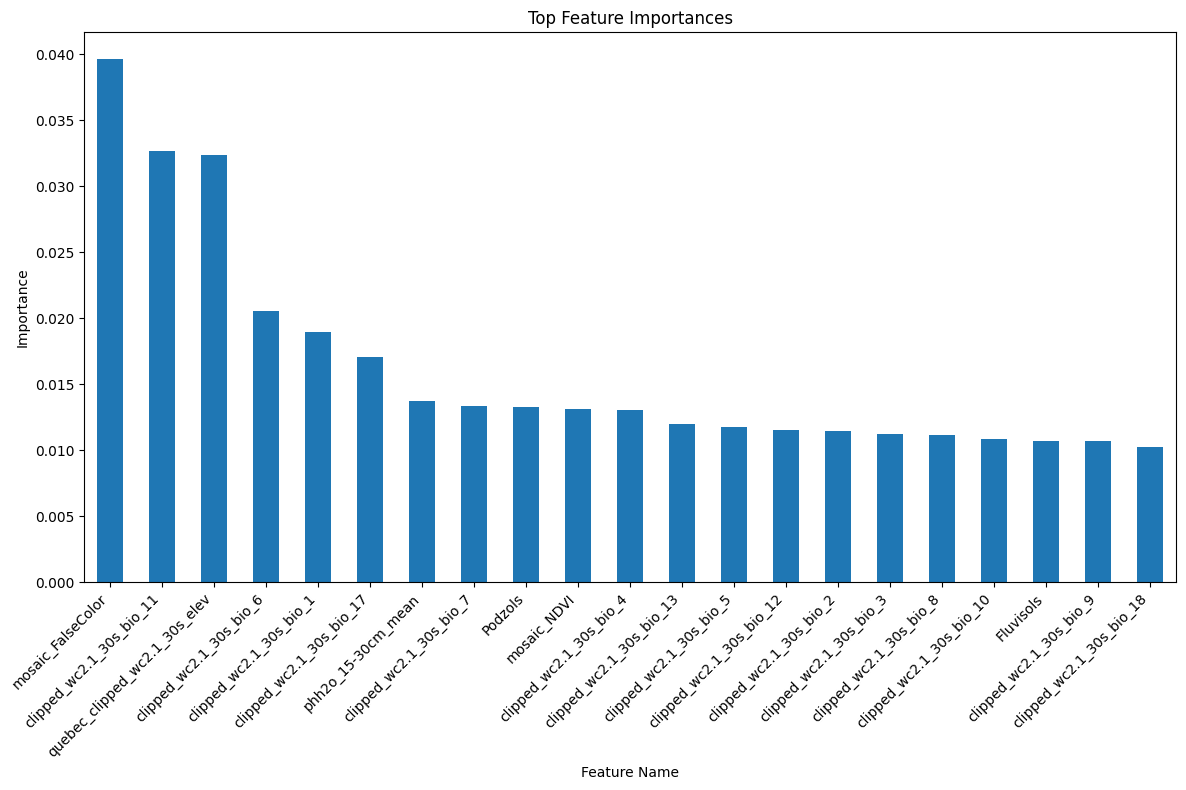

In [93]:
import pandas as pd

# Construct a DataFrame with feature names and their importances

feature_importance_df = get_feature_importance_for_species('ERP', cont_zonal_stats_path, cat_zonal_stats_path, remove_landuse=True, treshold=0.01)
# Plot the top_n features using the DataFrame
plt.figure(figsize=(12, 8))
feature_importance_df.head(25).plot(
    kind='bar',
    x='feature_name',
    y='importance',
    legend=False,
    ax=plt.gca()
)
plt.title("Top Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature Name")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [42]:
feature_importance_df[feature_importance_df['importance'] < 0.01].sort_values(by='importance', ascending=False)

feature_name  importance
38   landuse_Pruche du Canada associée à des feuill...    0.009724
39   landuse_Bouleau blanc associé à du sapin baumi...    0.009663
40                      clipped_wc2.1_30s_bio_15_value    0.009653
41                              mosaic_stretched_value    0.009133
42                                      Luvisols_value    0.008979
..                                                 ...         ...
191                                       landuse_6503    0.000000
190                                       landuse_6629    0.000000
189  landuse_Bouleau gris associé à des résineux to...    0.000000
188                                     Nitisols_value    0.000000
197                                  Kastanozems_value    0.000000

[367 rows x 2 columns]

In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    #print("Model R^2 Score:", model.score(X_test, y_test))
    # Calculate accuracy
    accuracy = accuracy_score(y_test, np.round(y_pred))
    #print("Accuracy:", accuracy)
    train_accuracy = model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    return (accuracy, train_accuracy)

In [11]:
def evaluate_species(species_name, location_zonal_stats, cat_location_zonal_stats, area_zonal_stats = None, cat_area_zonal_stats = None):# Define the target variable and features
    target = species_name  # Replace with the actual target column if different
    features = create_target_species_df(target, location_zonal_stats)

    model = xgb.XGBClassifier(
        objective='binary:logistic',  # or 'multi:softmax' for multiclass
        n_estimators=75,
        max_depth=4,
        learning_rate=0.1,
        random_state=42,
        colsample_bytree=0.7,
        subsample=0.4,
    )
    
    accuracy_with_region = None
    if area_zonal_stats is not None and cat_area_zonal_stats is not None:
        merged_df_with_region = merge_data_inputs(features, location_zonal_stats, cat_location_zonal_stats, area_zonal_stats, cat_area_zonal_stats)
        features_with_region = merged_df_with_region.select_dtypes(include=['float64', 'int64']).columns.drop(target)
        X_train_selected_with_region, X_test_selected_with_region, y_train_with_region, y_test_with_region = select_features(merged_df_with_region, target, features_with_region)
        accuracy_with_region, train_accuracy_with_region = evaluate_model(model, X_train_selected_with_region, y_train_with_region, X_test_selected_with_region, y_test_with_region)

    merged_df_without_region = merge_data_inputs(features,location_zonal_stats, cat_location_zonal_stats)
    features_without_region = merged_df_without_region.select_dtypes(include=['float64', 'int64']).columns.drop(target)
    X_train_selected_without_region, X_test_selected_without_region, y_train_without_region, y_test_without_region = select_features(merged_df_without_region, target, features_without_region)
    accuracy_without_region, train_accuracy_without_region = evaluate_model(model, X_train_selected_without_region, y_train_without_region, X_test_selected_without_region, y_test_without_region)
    
    return (accuracy_with_region, accuracy_without_region)

In [ ]:
#load df
location_zonal_stats = pd.read_csv('../data/misc/continuous_zonal_stats_res_12.csv')
cat_location_zonal_stats = pd.read_csv('../data/misc/cat_zonal_stats_res_12.csv')
location_zonal_stats_numeric_columns = location_zonal_stats.select_dtypes(include=['float64', 'int64']).columns
location_zonal_stats[location_zonal_stats_numeric_columns] = location_zonal_stats[location_zonal_stats_numeric_columns].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
)
#merge zonal_stats with processed_species using h3_index
location_zonal_stats = location_zonal_stats.merge(
    processed_species[['h3_index', 'species_list']],
    on='h3_index',
    how='left'
)


def load_data_by_factor(factor):
        zonal_stats_x15 = pd.read_csv(f'../data/misc/continuous_zonal_stats_res_12_x{factor}.csv')
        cat_zonal_stats_x15 = pd.read_csv(f'../data/misc/cat_zonal_stats_res_12.csv_x{factor}.csv')

        # Normalize all numeric columns in zonal_stats between 0 and 1

        zonal_stats_x15_numeric_columns = zonal_stats_x15.select_dtypes(include=['float64', 'int64']).columns


        zonal_stats_x15[zonal_stats_x15_numeric_columns] = zonal_stats_x15[zonal_stats_x15_numeric_columns].apply(
            lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
        )
        return zonal_stats_x15, cat_zonal_stats_x15

In [17]:
import numpy as np

# Create an array starting at 1.25 and multiply each term by 1.25 until it exceeds 5
factors = 1.25 * np.array([1.25**i for i in range(int(np.log(8/1.25)/np.log(1.25)) + 1)])
print(factors)


#species_to_test = species_counts_df.sort_values(by='count', ascending=False).head(15).index.to_list()
species_to_test = ['ERS']
results = pd.DataFrame(columns=['Species', 'Accuracy', 'factor'])
for species in species_to_test:
    accuracy_with_region, accuracy_without_region = evaluate_species(species,location_zonal_stats, cat_location_zonal_stats)
    results = pd.concat([results, pd.DataFrame({
        'Species': [species],
        'Accuracy': [accuracy_without_region],
        'factor': [0]
    })], ignore_index=True)
    for factor in factors:
        area_zonal_stats, cat_area_zonal_stats = load_data_by_factor(factor)
        print(f"Processing {species} with factor: {factor}")
        accuracy_with_region, accuracy_without_region = evaluate_species(species,location_zonal_stats, cat_location_zonal_stats, area_zonal_stats, cat_area_zonal_stats)
        results = pd.concat([results, pd.DataFrame({
            'Species': [species],
            'Accuracy': [accuracy_with_region],
            'factor': [factor]
        })], ignore_index=True)

[1.25       1.5625     1.953125   2.44140625 3.05175781 3.81469727
 4.76837158 5.96046448 7.4505806 ]


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/tmp/ipykernel_8756/2058199435.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


Processing ERS with factor: 1.25


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 1.5625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 1.953125


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 2.44140625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 3.0517578125


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 3.814697265625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 4.76837158203125


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 5.9604644775390625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 7.450580596923828


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [18]:
# Select the row with the best accuracy for each species
best_accuracy_per_species = results.loc[results.groupby('Species')['Accuracy'].idxmax()]

# Ensure there is a row with factor == 0 for each species
accuracy_at_factor_0 = results[results['factor'] == 0].set_index('Species')['Accuracy']

# Calculate the difference between the best accuracy and the accuracy where factor == 0 for each species
best_accuracy_per_species['Accuracy_Difference'] = best_accuracy_per_species['Accuracy'] - best_accuracy_per_species['Species'].map(accuracy_at_factor_0)

# Display the result
best_accuracy_per_species

Species  Accuracy    factor  Accuracy_Difference
5     ERS   0.83658  3.051758             0.017316

In [19]:
results

Species  Accuracy    factor
0     ERS  0.819264         0
1     ERS  0.816017      1.25
2     ERS  0.831169    1.5625
3     ERS  0.819264  1.953125
4     ERS  0.834416  2.441406
5     ERS  0.836580  3.051758
6     ERS  0.834416  3.814697
7     ERS  0.824675  4.768372
8     ERS  0.832251  5.960464
9     ERS  0.834416  7.450581

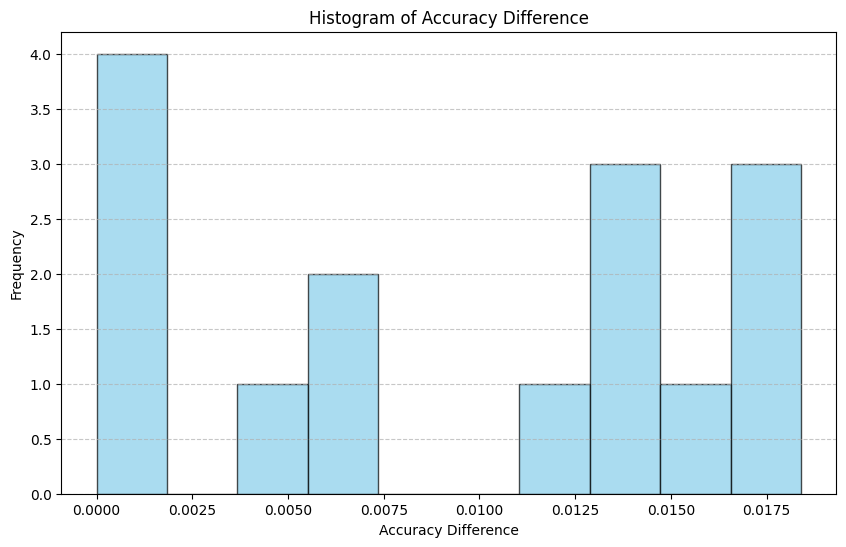

In [215]:
import matplotlib.pyplot as plt

# Plot Accuracy Difference as a histogram
plt.figure(figsize=(10, 6))
plt.hist(best_accuracy_per_species['Accuracy_Difference'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels, title, and grid
plt.xlabel('Accuracy Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Accuracy Difference')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


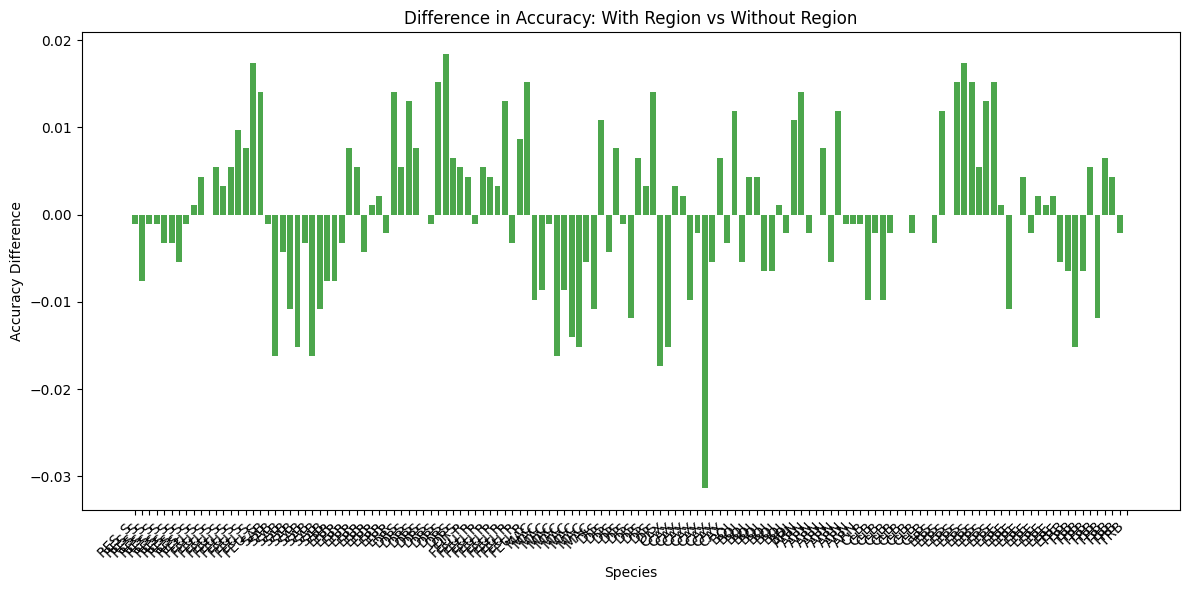

In [204]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the difference
results['Accuracy_Difference'] = results['Accuracy_With_Region'] - results['Accuracy_Without_Region']

# Set the positions of the bars
indices = np.arange(len(results))

# Plot the difference
plt.figure(figsize=(12, 6))
plt.bar(indices, results['Accuracy_Difference'], color='green', alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Species')
plt.ylabel('Accuracy Difference')
plt.title('Difference in Accuracy: With Region vs Without Region')
plt.xticks(indices, results['Species'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56       244
           1       0.84      0.88      0.86       680

    accuracy                           0.78       924
   macro avg       0.72      0.70      0.71       924
weighted avg       0.77      0.78      0.78       924

[[126 118]
 [ 82 598]]


## Implementing 3D CNN

### Extracting data from hexagons

In [11]:
import rasterio
import geopandas as gpd
import numpy as np
from shapely.geometry import box, mapping
from rasterio.mask import mask
from rasterio.windows import Window
from rtree import index
import math

def extract_raster_values_for_multiple_h3_chunked(geometries, raster_path, chunk_size_mb=512):
    """
    Extract raster values for H3 geometries using chunked processing for large rasters.
    
    Parameters:
    -----------
    geometries : list
        List of H3 geometries
    raster_path : str
        Path to raster file
    chunk_size_mb : int
        Target chunk size in MB (default 512MB)
    
    Returns:
    --------
    list : Results for each geometry (out_image, clipped_bounds)
    """
    with rasterio.open(raster_path) as src:
        # Check if we need chunking
        raster_size_mb = (src.width * src.height * src.count * 
                         np.dtype(src.dtypes[0]).itemsize) / (1024 * 1024)
        print(f"Raster size: {raster_size_mb:.2f} MB, Chunk size: {chunk_size_mb} MB")
        if raster_size_mb <= chunk_size_mb:
            # Small raster - use original function
            return _extract_raster_values_original(geometries, src)
        
        # Large raster - use chunked processing
        else:
            print(f"Raster size {raster_size_mb:.2f} MB exceeds chunk size {chunk_size_mb} MB. Using chunked processing.")
            return _extract_raster_values_chunked(geometries, src, chunk_size_mb)

def _extract_raster_values_original(geometries, src):
    """Original function logic for small rasters"""
    # Reproject all geometries to match raster CRS
    h3_geometries = gpd.GeoSeries(geometries, crs="EPSG:4326")
    h3_geometries = h3_geometries.to_crs(src.crs)

    # Get raster resolution
    res_x, res_y = src.res
    pixel_area = abs(res_x * res_y)

    results = []

    for geometry in h3_geometries:
        # Check if hexagon is smaller than raster resolution
        hex_area = geometry.area

        if hex_area < pixel_area:
            # Hex is smaller than a pixel - use point sampling instead
            centroid = geometry.centroid
            try:
                row, col = src.index(centroid.x, centroid.y)
                value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                out_image = np.array([[[value]]])
                left, top = src.xy(row, col)
                right, bottom = src.xy(row + 1, col + 1)
                clipped_bounds = (left, bottom, right, top)
                results.append((out_image, clipped_bounds))
            except (IndexError, ValueError):
                results.append((None, None))
            continue

        # Convert to GeoJSON
        geometry_proj = mapping(geometry)

        # Create a bounding box from the raster bounds
        raster_bounds = box(*src.bounds)

        # Check overlap
        if not raster_bounds.intersects(geometry):
            results.append((None, None))
            continue

        try:
            # Mask the raster
            out_image, out_transform = mask(
                src,
                [geometry_proj],
                crop=True,
                filled=True,
                nodata=src.nodata
            )

            # Check if we got all NaN values
            if np.all(np.isnan(out_image)):
                centroid = geometry.centroid
                row, col = src.index(centroid.x, centroid.y)
                value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                out_image = np.array([[[value]]])
                left, top = src.xy(row, col)
                right, bottom = src.xy(row + 1, col + 1)
                out_transform = src.window_transform(((row, row + 1), (col, col + 1)))

            clipped_bounds = get_clipped_bounds(out_image, out_transform)
            results.append((out_image, clipped_bounds))

        except ValueError as e:
            if "Input shapes do not overlap raster" in str(e):
                results.append((None, None))
            else:
                raise

    return results

def _extract_raster_values_chunked(geometries, src, chunk_size_mb):
    """Chunked processing for large rasters"""
    # Reproject all geometries to match raster CRS
    h3_geometries = gpd.GeoSeries(geometries, crs="EPSG:4326")
    h3_geometries = h3_geometries.to_crs(src.crs)
    
    # Get raster resolution
    res_x, res_y = src.res
    pixel_area = abs(res_x * res_y)
    
    # Calculate chunk dimensions
    bytes_per_pixel = np.dtype(src.dtypes[0]).itemsize * src.count
    target_pixels = (chunk_size_mb * 1024 * 1024) // bytes_per_pixel
    
    # Calculate square-ish chunks
    chunk_size = int(math.sqrt(target_pixels))
    chunk_rows = min(chunk_size, src.height)
    chunk_cols = min(chunk_size, src.width)
    
    # Create spatial index for geometries
    spatial_idx = index.Index()
    for i, geom in enumerate(h3_geometries):
        spatial_idx.insert(i, geom.bounds)
    
    # Initialize results
    results = [None] * len(h3_geometries)
    processed = set()
    
    # Process chunks
    for row_start in range(0, src.height, chunk_rows):
        for col_start in range(0, src.width, chunk_cols):
            row_end = min(row_start + chunk_rows, src.height)
            col_end = min(col_start + chunk_cols, src.width)
            
            # Create window for this chunk
            window = Window(col_start, row_start, col_end - col_start, row_end - row_start)
            
            # Get chunk bounds in geographic coordinates
            chunk_transform = src.window_transform(window)
            chunk_bounds = rasterio.windows.bounds(window, src.transform)
            chunk_geom = box(*chunk_bounds)
            
            # Add buffer to ensure geometries on edges are fully contained
            # Buffer size based on max possible H3 cell size in the area
            buffer_size = max(abs(res_x), abs(res_y)) * 10  # Adjust multiplier as needed
            buffered_chunk = chunk_geom.buffer(buffer_size)
            
            # Find geometries that intersect with this buffered chunk
            potential_indices = list(spatial_idx.intersection(buffered_chunk.bounds))
            
            if not potential_indices:
                continue
            
            # Filter to geometries that are fully contained in the buffered chunk
            # or haven't been processed yet
            chunk_geometries = []
            chunk_indices = []
            
            for idx in potential_indices:
                if idx in processed:
                    continue
                
                geom = h3_geometries.iloc[idx]
                
                # Check if geometry is fully contained in buffered chunk
                # or if its centroid is in the original (non-buffered) chunk
                if buffered_chunk.contains(geom) or chunk_geom.contains(geom.centroid):
                    chunk_geometries.append((idx, geom))
                    chunk_indices.append(idx)
            
            if not chunk_geometries:
                continue
            
            # Read this chunk
            try:
                chunk_data = src.read(window=window)
                
                # Create a temporary raster-like object for this chunk
                chunk_profile = src.profile.copy()
                chunk_profile.update({
                    'height': window.height,
                    'width': window.width,
                    'transform': chunk_transform
                })
                
                # Process geometries in this chunk
                for idx, geometry in chunk_geometries:
                    if idx in processed:
                        continue
                    
                    result = _process_single_geometry(
                        geometry, chunk_data, chunk_transform, 
                        src.nodata, pixel_area, chunk_bounds
                    )
                    
                    results[idx] = result
                    processed.add(idx)
                    
            except Exception as e:
                print(f"Error processing chunk at ({row_start}, {col_start}): {e}")
                continue
    
    # Handle any unprocessed geometries (fallback to point sampling)
    for i, geom in enumerate(h3_geometries):
        if i not in processed:
            try:
                centroid = geom.centroid
                row, col = src.index(centroid.x, centroid.y)
                if 0 <= row < src.height and 0 <= col < src.width:
                    value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                    out_image = np.array([[[value]]])
                    left, top = src.xy(row, col)
                    right, bottom = src.xy(row + 1, col + 1)
                    clipped_bounds = (left, bottom, right, top)
                    results[i] = (out_image, clipped_bounds)
                else:
                    results[i] = (None, None)
            except:
                results[i] = (None, None)
    
    return results

def _process_single_geometry(geometry, chunk_data, chunk_transform, nodata, pixel_area, chunk_bounds):
    """Process a single geometry against chunk data"""
    hex_area = geometry.area
    
    # Check if hexagon is smaller than raster resolution
    if hex_area < pixel_area:
        # Use point sampling
        centroid = geometry.centroid
        try:
            # Convert centroid to chunk pixel coordinates
            col, row = ~chunk_transform * (centroid.x, centroid.y)
            row, col = int(row), int(col)
            
            if 0 <= row < chunk_data.shape[1] and 0 <= col < chunk_data.shape[2]:
                value = chunk_data[0, row, col]
                out_image = np.array([[[value]]])
                # Convert back to geographic coordinates
                x, y = chunk_transform * (col, row)
                x2, y2 = chunk_transform * (col + 1, row + 1)
                clipped_bounds = (min(x, x2), min(y, y2), max(x, x2), max(y, y2))
                return (out_image, clipped_bounds)
            else:
                return (None, None)
        except:
            return (None, None)
    
    # Create chunk bounds box for intersection check
    chunk_box = box(*chunk_bounds)
    
    # Check overlap
    if not chunk_box.intersects(geometry):
        return (None, None)
    
    try:
        # For chunked processing, we need to create a temporary in-memory raster
        # This is a simplified approach - you might want to use rasterio.MemoryFile for more complex cases
        from rasterio.mask import mask
        from rasterio import MemoryFile
        
        # Create temporary memory file with chunk data
        with MemoryFile() as memfile:
            with memfile.open(
                driver='GTiff',
                height=chunk_data.shape[1],
                width=chunk_data.shape[2],
                count=chunk_data.shape[0],
                dtype=chunk_data.dtype,
                crs=None,  # Will be handled by transform
                transform=chunk_transform,
                nodata=nodata
            ) as temp_src:
                temp_src.write(chunk_data)
                
                # Now apply mask
                geometry_proj = mapping(geometry)
                out_image, out_transform = mask(
                    temp_src,
                    [geometry_proj],
                    crop=True,
                    filled=True,
                    nodata=nodata
                )
                
                # Check if we got all NaN values
                if np.all(np.isnan(out_image)) or np.all(out_image == nodata):
                    # Fallback to centroid sampling
                    centroid = geometry.centroid
                    col, row = ~chunk_transform * (centroid.x, centroid.y)
                    row, col = int(row), int(col)
                    
                    if 0 <= row < chunk_data.shape[1] and 0 <= col < chunk_data.shape[2]:
                        value = chunk_data[0, row, col]
                        out_image = np.array([[[value]]])
                        x, y = chunk_transform * (col, row)
                        x2, y2 = chunk_transform * (col + 1, row + 1)
                        out_transform = rasterio.transform.from_bounds(
                            min(x, x2), min(y, y2), max(x, x2), max(y, y2), 1, 1
                        )
                
                clipped_bounds = get_clipped_bounds(out_image, out_transform)
                return (out_image, clipped_bounds)
                
    except ValueError as e:
        if "Input shapes do not overlap raster" in str(e):
            return (None, None)
        else:
            raise
    except Exception:
        return (None, None)

def get_clipped_bounds(out_image, out_transform):
    """Helper function to get bounds from image and transform"""
    height, width = out_image.shape[1], out_image.shape[2]
    left, top = out_transform * (0, 0)
    right, bottom = out_transform * (width, height)
    return (left, bottom, right, top)



In [ ]:
upscale_factor = 2
bounding_box = bounding_box
with rasterio.open("../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif") as src:

    data = src.read(1, window=Window(
        bounding_box[0] // upscale_factor, 
        bounding_box[1] // upscale_factor, 
        (bounding_box[2] - bounding_box[0]) // upscale_factor, 
        (bounding_box[3] - bounding_box[1]) // upscale_factor
    ))


In [ ]:
# Example usage:
h3_cells = processed_species['h3_index'].values
expanded_cells = [expand_hexagon(h3_cell, 50) for h3_cell in h3_cells]
results = extract_raster_values_for_multiple_h3_chunked(
    geometries=expanded_cells,
    raster_path="../data/data_layers/landuse/utilisation_territoire_2020_clipped.tif",
    #raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif",
    chunk_size_mb=5000  # Adjust based on your memory constraints
)

Raster size: 1254.00 MB, Chunk size: 5000 MB


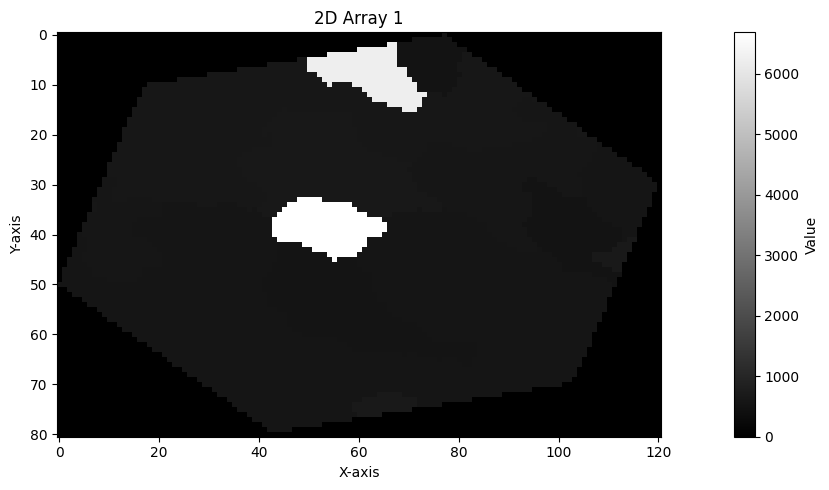

In [20]:
output, bounds = results[3]
visualize_2d_array([output[0]])

In [542]:
processed_species.geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [36]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import box, mapping
from rasterio.mask import mask
from rasterio.features import rasterize

def extract_raster_values_for_multiple_h3(geometries, raster_path):
    """
    Extract raster values for multiple geometries using precise rasterization-based masking.
    Assumes input geometries are in the same CRS as the raster.
    """
    with rasterio.open(raster_path) as src:
        h3_geometries = gpd.GeoSeries(geometries, crs=src.crs)
        res_x, res_y = src.res
        pixel_area = abs(res_x * res_y)

        results = []
        raster_bounds_poly = box(*src.bounds)

        for i, geometry in enumerate(h3_geometries):
            if not geometry.within(raster_bounds_poly):
                print("Warning: Geometry is NOT entirely within the raster bounds.")
            
            hex_area = geometry.area

            if hex_area < pixel_area:
                centroid = geometry.centroid
                try:
                    row, col = src.index(centroid.x, centroid.y)
                    value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                    out_image = np.array([[[value]]])
                    left, top = src.xy(row, col)
                    right, bottom = src.xy(row + 1, col + 1)
                    clipped_bounds = (left, bottom, right, top)
                    results.append((out_image, clipped_bounds))
                except (IndexError, ValueError):
                    results.append((None, None))
                continue

            geometry_proj = mapping(geometry)

            try:
                out_image, out_transform = mask(
                    src,
                    [geometry_proj],
                    crop=True,
                    filled=False,
                    nodata=src.nodata
                )

                valid_mask = ~out_image.mask[0]
                if not np.any(valid_mask):
                    centroid = geometry.centroid
                    row, col = src.index(centroid.x, centroid.y)
                    value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                    out_image = np.array([[[value]]])
                    left, top = src.xy(row, col)
                    right, bottom = src.xy(row + 1, col + 1)
                    clipped_bounds = (left, bottom, right, top)
                    results.append((out_image, clipped_bounds))
                    continue

                # Find valid pixel bounding box
                rows = np.any(valid_mask, axis=1)
                cols = np.any(valid_mask, axis=0)
                row_start, row_end = np.where(rows)[0][[0, -1]]
                col_start, col_end = np.where(cols)[0][[0, -1]]

                out_image_cropped = out_image.data[0][row_start:row_end+1, col_start:col_end+1]
                out_image_cropped = np.expand_dims(out_image_cropped, axis=0)

                window = ((row_start, row_end + 1), (col_start, col_end + 1))
                cropped_transform = rasterio.windows.transform(window, out_transform)

                # Rasterize the geometry to create a binary mask
                mask_shape = out_image_cropped.shape[1:]
                geometry_mask = rasterize(
                    [(geometry, 1)],
                    out_shape=mask_shape,
                    transform=cropped_transform,
                    fill=0,
                    dtype='uint8'
                )

                # Apply the rasterized mask
                out_image_cropped[0] *= geometry_mask

                # Calculate bounds
                left, top = cropped_transform * (0, 0)
                right, bottom = cropped_transform * (out_image_cropped.shape[2], out_image_cropped.shape[1])
                clipped_bounds = (left, bottom, right, top)

                results.append((out_image_cropped, clipped_bounds))

            except ValueError as e:
                if "Input shapes do not overlap raster" in str(e):
                    results.append((None, None))
                else:
                    raise

        return results

Output shape: (1, 22, 22), Bounds: (127846.5629764368, 524257.86462470307, 130046.5629764368, 526457.8646247031)
Output shape: (1, 22, 22), Bounds: (127646.5629764368, 524357.8646247031, 129846.5629764368, 526557.8646247031)
Output shape: (1, 22, 22), Bounds: (127346.5629764368, 524357.8646247031, 129546.5629764368, 526557.8646247031)
Output shape: (1, 22, 22), Bounds: (123046.5629764368, 533457.8646247031, 125246.5629764368, 535657.8646247031)


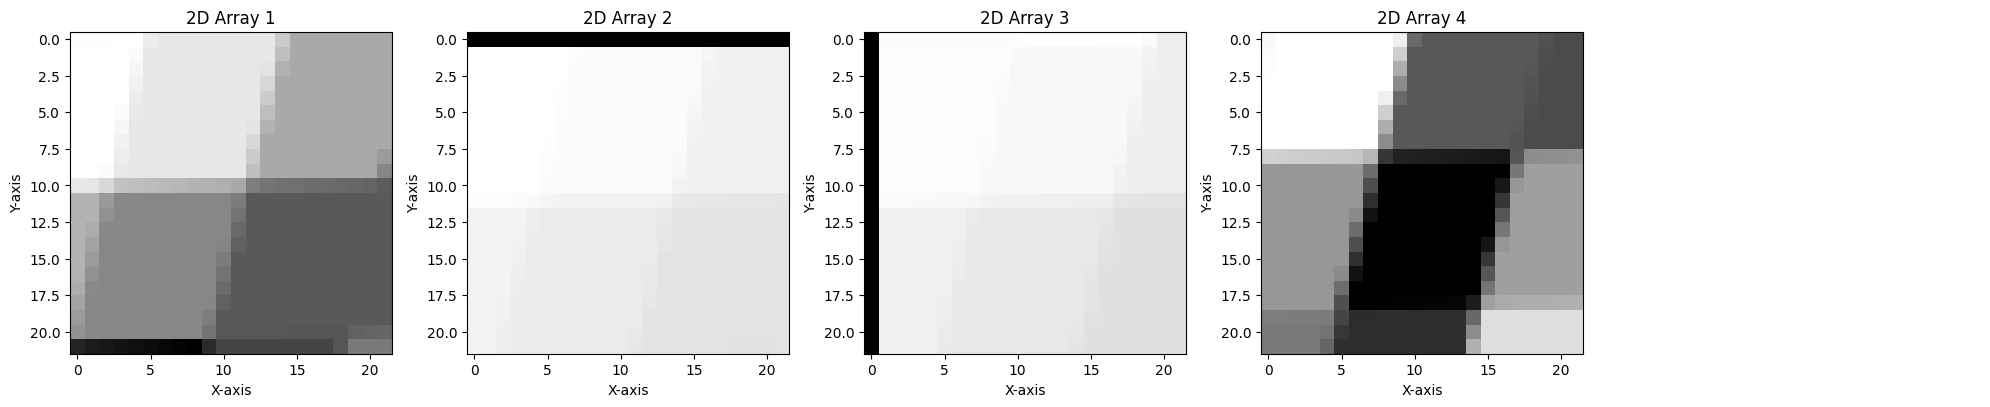

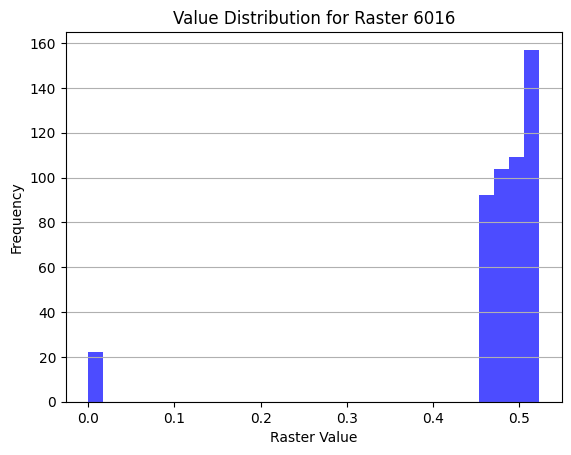

In [30]:
# geom = processed_species.h3_index.iloc[100]
# geom = expand_hexagon_to_square(geom, 'EPSG:6624', 100)
geom = processed_species_ok.expanded_cells.values
raster = '../data/data_layers/predictors_100_QC/sand_normalized.tif'
r = extract_raster_values_for_multiple_h3(geom[6015:6019], raster)
#print all shapes
for output, bounds in r:
    if output is not None:
        print(f"Output shape: {output.shape}, Bounds: {bounds}")
    else:
        print("No valid output for this geometry.")
visualize_2d_array([output[0] for output, bounds in r if output is not None], plots_per_row=5)

#show value distribution
import matplotlib.pyplot as plt

# Plot the distribution of values for the second output
if r[1][0] is not None:
    # Use .flatten() to get all values as 1D array, and filter out nodata if needed
    arr = r[1][0].flatten()
    plt.hist(arr, bins=30, color='blue', alpha=0.7)
    plt.title('Value Distribution for Raster 6016')
    plt.xlabel('Raster Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

Output shape: (1, 23, 23), Bounds: (np.float64(144346.5629764368), np.float64(452657.86462470307), np.float64(146646.5629764368), np.float64(454957.86462470307))
Output shape: (1, 23, 23), Bounds: (np.float64(144246.5629764368), np.float64(452457.86462470307), np.float64(146546.5629764368), np.float64(454757.86462470307))
Output shape: (1, 23, 23), Bounds: (np.float64(144446.5629764368), np.float64(452757.86462470307), np.float64(146746.5629764368), np.float64(455057.86462470307))
Output shape: (1, 23, 23), Bounds: (np.float64(144546.5629764368), np.float64(452957.86462470307), np.float64(146846.5629764368), np.float64(455257.86462470307))
Output shape: (1, 23, 23), Bounds: (np.float64(144046.5629764368), np.float64(452257.86462470307), np.float64(146346.5629764368), np.float64(454557.86462470307))
Output shape: (1, 23, 23), Bounds: (np.float64(144046.5629764368), np.float64(452157.86462470307), np.float64(146346.5629764368), np.float64(454457.86462470307))
Output shape: (1, 23, 23), B

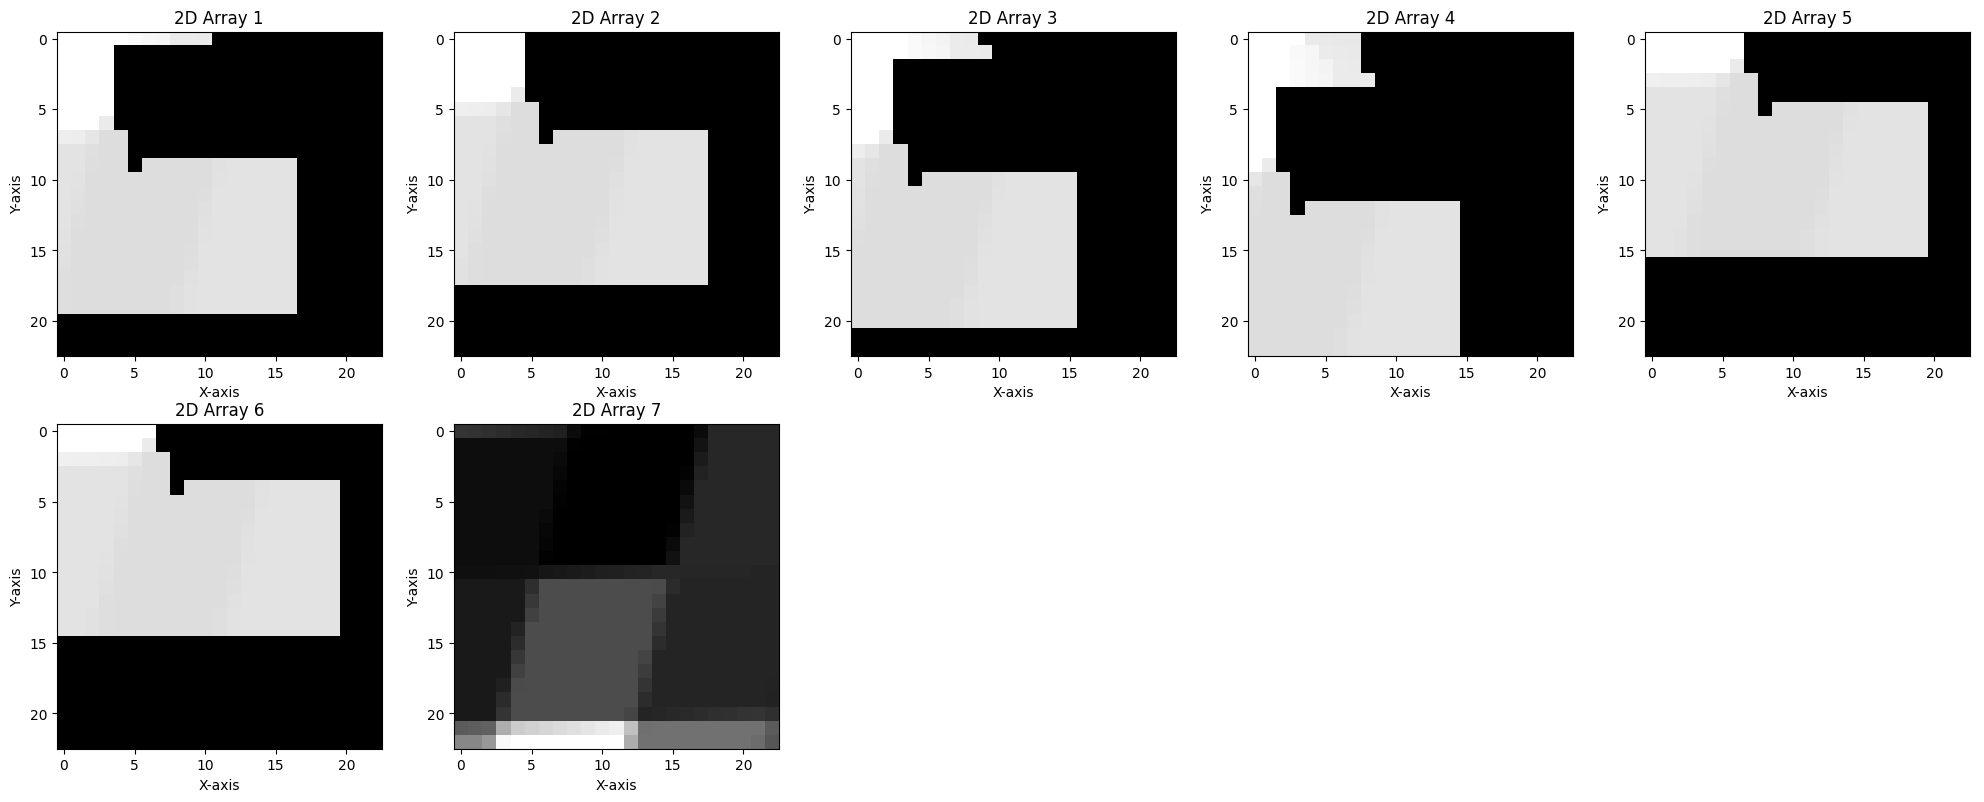

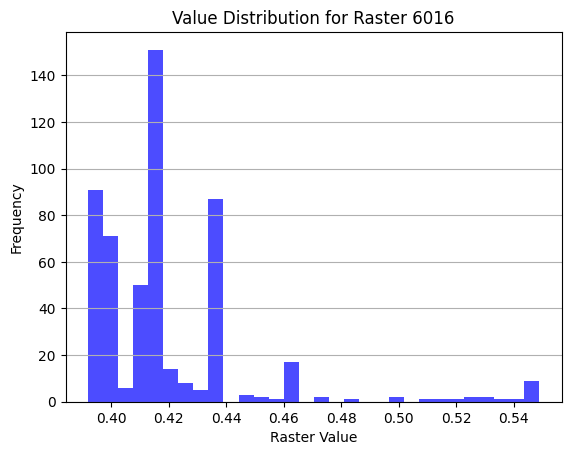

In [48]:
# geom = processed_species.h3_index.iloc[100]
# geom = expand_hexagon_to_square(geom, 'EPSG:6624', 100)
geom = processed_species_ok.expanded_cells.values
raster = '../data/data_layers/predictors_100_QC_normalized/sand.tif'
r = extract_raster_values_for_multiple_h3(geom[6045:6052], raster)
#print all shapes
for output, bounds in r:
    if output is not None:
        print(f"Output shape: {output.shape}, Bounds: {bounds}")
    else:
        print("No valid output for this geometry.")
visualize_2d_array([output[0] for output, bounds in r if output is not None], plots_per_row=5)

#show value distribution
import matplotlib.pyplot as plt

# Plot the distribution of values for the second output
if r[6][0] is not None:
    # Use .flatten() to get all values as 1D array, and filter out nodata if needed
    arr = r[6][0].flatten()
    plt.hist(arr, bins=30, color='blue', alpha=0.7)
    plt.title('Value Distribution for Raster 6016')
    plt.xlabel('Raster Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

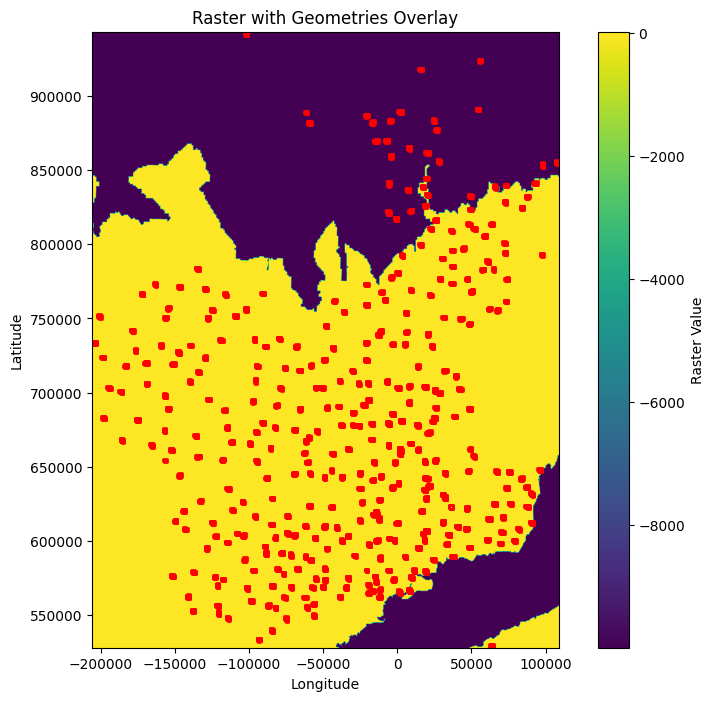

In [ ]:
from shapely.geometry import box
import rasterio
import geopandas as gpd

geom = processed_species_ok.expanded_cells.values[0:2000]
raster = '../data/data_layers/predictors_100_QC/twi.tif'

import matplotlib.pyplot as plt

# Calculate the bounding box that covers all geometries in geom
all_bounds = [g.bounds for g in geom]
minx = min(b[0] for b in all_bounds)
miny = min(b[1] for b in all_bounds)
maxx = max(b[2] for b in all_bounds)
maxy = max(b[3] for b in all_bounds)
bbox = box(minx, miny, maxx, maxy)
# Open the raster and read the window corresponding to the bounding box
with rasterio.open(raster) as src:
    window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, transform=src.transform)
    raster_data = src.read(1, window=window)
    window_transform = src.window_transform(window)
    extent = rasterio.plot.plotting_extent(raster_data, window_transform)

# Plot the raster and overlay the geometries
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(raster_data, extent=extent, cmap='viridis')
gpd.GeoSeries(list(geom)).plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
plt.colorbar(im, ax=ax, label='Raster Value')
ax.set_title("Raster with Geometries Overlay")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Normalizing data
For the satelitte images, the resolution of hexagons are 73x110

For the landuse data, the resolution of hexagons are 161x241

For the climate data, the resolution of hexagons are 

Could be an interesting idea to test if a FCN produces better results since it can take multiple resolutions as input.

In [13]:
import numpy as np
from skimage.transform import resize

def resize_raster(input_raster, target_shape):
    """
    Resize the raster input_raster to the target shape using interpolation.   
    
    Parameters:
    - input_raster: The input raster array to be resized.
    - target_shape: The desired shape (height, width) for the output raster.
    
    Returns:
    - resized_image: The resized raster array.
    """
    print(f"Resizing raster from shape {input_raster.shape} to target shape {target_shape}")
    # Assuming `output` is a 2D or 3D numpy array
    if len(input_raster.shape) == 2:
        # For single band raster
        print(f"Resizing single band raster with shape {input_raster.shape}")
        resized_image = resize(input_raster, target_shape, order=1, anti_aliasing=True, mode='wrap')  # bilinear
    elif len(input_raster.shape) == 3:
        # For multi-band raster
        print("coucou")
        resized_image = np.stack([
            resize(band, target_shape, order=1, anti_aliasing=True, mode='edge') for band in input_raster
        ], axis=-1)
    else:
        raise ValueError("Unsupported output shape: {}".format(input_raster.shape))
    return resized_image

def visualize_2d_array(arrays, plots_per_row=5):
    num_arrays = len(arrays)
    num_rows = int(np.ceil(num_arrays / plots_per_row))
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 4, num_rows * 4))
    axes = np.array(axes).reshape(num_rows, plots_per_row)
    for idx, array in enumerate(arrays):
        row = idx // plots_per_row
        col = idx % plots_per_row
        ax = axes[row, col]
        im = ax.imshow(array, cmap='gray')
        ax.set_title(f'2D Array {idx+1}')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        #fig.colorbar(im, ax=ax, orientation='vertical', label='Value')
    # Hide any unused subplots
    for idx in range(num_arrays, num_rows * plots_per_row):
        row = idx // plots_per_row
        col = idx % plots_per_row
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()



Resizing raster from shape (12, 13) to target shape (73, 110)
Resizing single band raster with shape (12, 13)


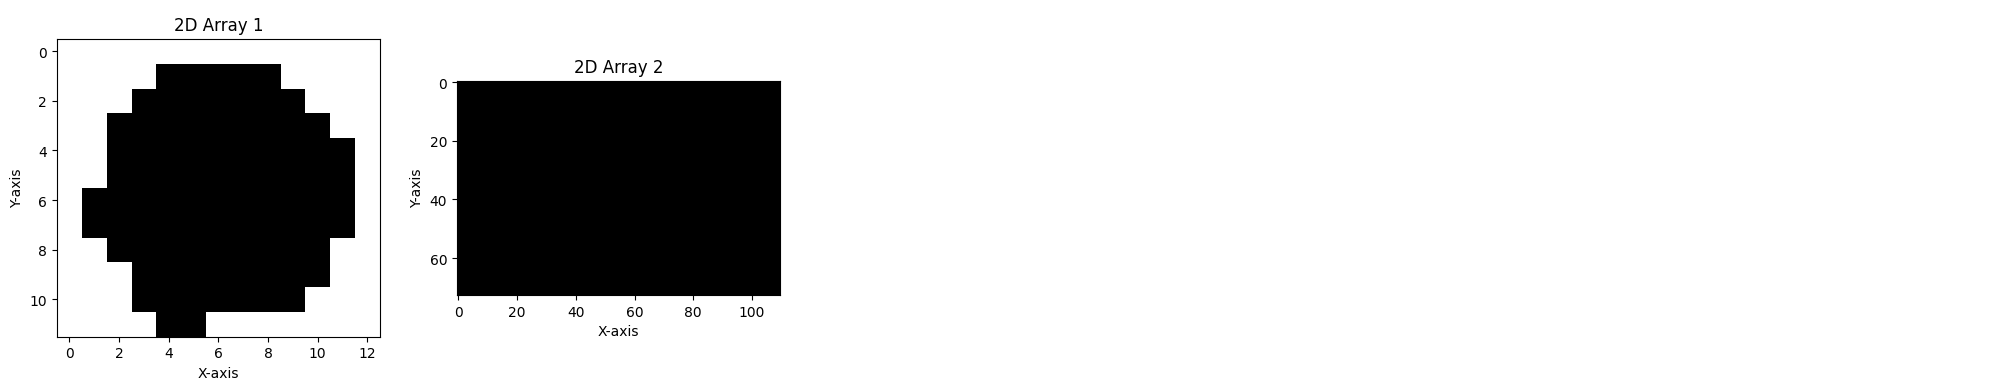

In [289]:
h3_cells = processed_species['h3_index'].values[:10]
expanded_cells = [expand_hexagon(h3_cell, 50) for h3_cell in h3_cells]

rgb_raster = extract_raster_values_for_multiple_h3(
        geometries=expanded_cells,
        raster_path="../data/data_layers/predictors_100_QC/alluvion.tif",
        #raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif"
    )
output, bounds = rgb_raster[0]
 
target_shape = (73, 110)
resized_image = resize_raster(output[0], target_shape)  # Resize to 100x100 pixels
visualize_2d_array([output[0], resized_image])

This is bad i dont want to resize and loose informations like that.

Original shape: (109, 164)
Resized shape: (73, 110)


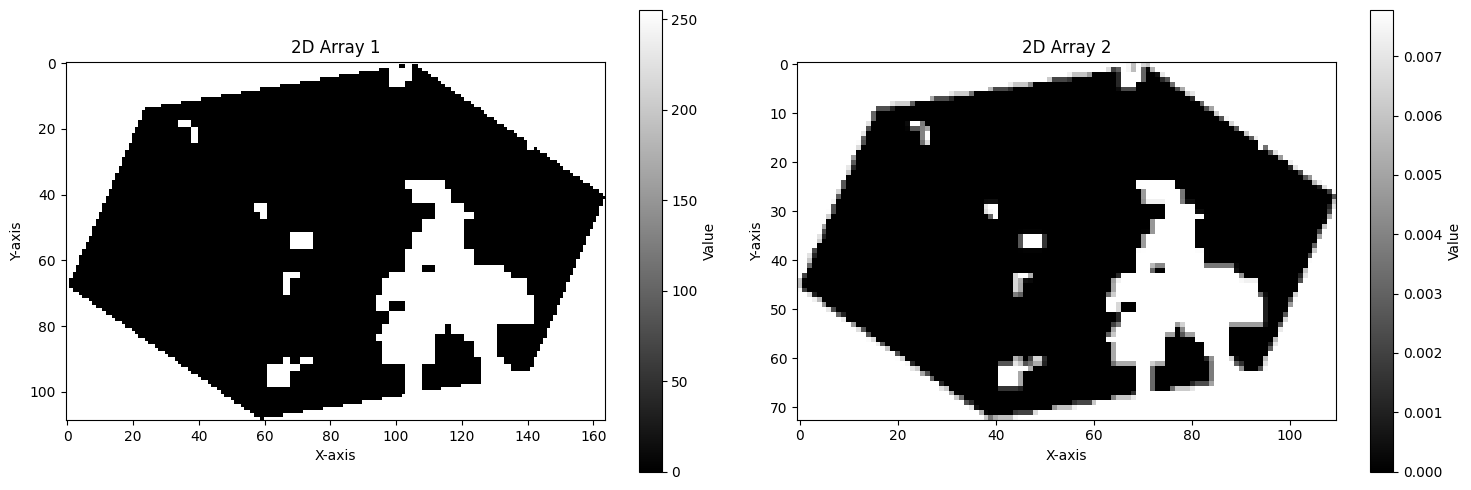

In [119]:
import numpy as np
from skimage.transform import resize

output, bounds = rgb_raster[4]
output = output[0]  # Assuming the first band is what you want to visualize
# Assuming `image` is your input array (73x110 or 161x241)
original_shape = output.shape
target_shape = (73, 110)  # or (73, 110) for downsampling

# Resize using interpolation (options: 'nearest', 'bilinear', 'bicubic', 'lanczos')
resized_image = resize(output, target_shape, order=1, anti_aliasing=True, mode='edge')  # bicubic

# For remote sensing, 'bilinear' (order=1) or 'bicubic' (order=3) are common
print("Original shape:", original_shape)
print("Resized shape:", resized_image.shape)
visualize_2d_array([output, resized_image])

In [14]:
def extract_all_bands_for_geom(geometries, to_squares=False):
    """
    Extract all bands for the given geometries from the remote sensing data.
    Remote sensing data includes RGB, False Color, and SWIR bands.
    Extracted bands: B4, B3, B2 (RGB), B8 (False Color), B11 (SWIR).
    """
    rgb_raster = extract_raster_values_for_multiple_h3(
        geometries=geometries,
        raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif"
    )
    false_color_raster = extract_raster_values_for_multiple_h3(
        geometries=geometries,
        raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_FalseColor.tif"
    )
    swir_raster = extract_raster_values_for_multiple_h3(
        geometries=geometries,
        raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_SWIR.tif"
    )
    results = []
    for i, (rgb_output, bounds) in enumerate(rgb_raster):
        B4, B3, B2 = rgb_output
        B8 = false_color_raster[i][0][0]
        B11 = swir_raster[i][0][0]
        results.append(np.stack([B4, B3, B2, B8, B11]))
        print(f"Shape of extracted bands for geometry {i}: {results[-1].shape}")

    target_shape = tuple(np.max([band.shape for band in results], axis=0))
    #for squares i dont want any padding for now so i prefer cropping
    if to_squares:
        target_shape =  tuple(np.min([band.shape for band in results], axis=0))
    results = np.array([pad_or_crop_to_shape(band, target_shape) for band in results])
    return results

def extract_all_bands_for_uni_band(geometries, raster_paths):
    extracted_bands = []
    for raster_i, raster_path in enumerate(raster_paths):
        print(f"Processing raster {raster_i + 1}/{len(raster_paths)}: {raster_path}")
        raster_values = extract_raster_values_for_multiple_h3(
            geometries=geometries,
            raster_path=raster_path
        )
        extracted_bands.append([])
        for i, (output, bounds) in enumerate(raster_values):
            if output is not None:
                extracted_bands[raster_i].append(output[0])  # Assuming single band output
            else:
                extracted_bands.append(None)
    return extracted_bands
from collections import Counter
import numpy as np

def extract_resize_for_other_data(geometries, raster_paths, target_shape=(73, 110)):
    extracted_bands = extract_all_bands_for_uni_band(geometries, raster_paths)
    # extracted_bands: list of [band][cell][x, y]
    num_bands = len(extracted_bands)
    num_cells = len(extracted_bands[0]) if num_bands > 0 else 0

    band_shapes = []
    cell_band_indices = []  # (band_idx, cell_idx)

    for band_idx, band_list in enumerate(extracted_bands):
        for cell_idx, band in enumerate(band_list):
            if band is not None:
                shape = tuple(int(dim) for dim in np.array(band).shape)
                band_shapes.append(shape)
                cell_band_indices.append((band_idx, cell_idx))

    # Normalize all shapes to Python tuples of ints
    normalized_shapes = [tuple(int(s) for s in shape) for shape in band_shapes]
    shape_array = np.array(normalized_shapes)
    min_shape = tuple(np.min(shape_array, axis=0).tolist())
    max_shape = tuple(np.max(shape_array, axis=0).tolist())
    print("Minimum shape of extracted bands:", min_shape)
    print("Maximum shape of extracted bands:", max_shape)

    # Find indices that match the normalized min_shape exactly
    indices_with_min_shape = [
        (band_idx, cell_idx)
        for (band_idx, cell_idx), shape in zip(cell_band_indices, normalized_shapes)
        if shape == min_shape
    ]

    print(f"Found {len(indices_with_min_shape)} cells with the minimal shape:")
    for band_idx, cell_idx in indices_with_min_shape[:10]:  # Only print first 10
        print(f" - Band {band_idx}, Cell {cell_idx}")

    # Find all bands/cells with any dimension smaller than 17
    indices_with_small_shape = [
        (band_idx, cell_idx, shape)
        for (band_idx, cell_idx), shape in zip(cell_band_indices, normalized_shapes)
        if any(dim < 17 for dim in shape)
    ]
    print(f"Found {len(indices_with_small_shape)} bands/cells with a shape smaller than 17 in any dimension:")
    for band_idx, cell_idx, shape in indices_with_small_shape[:10]:  # Only print first 10
        print(f" - Band {band_idx}, Cell {cell_idx}, Shape: {shape}")

    # Use min_shape as the resizing target (or switch to target_shape)
    resize_shape = min_shape  # ← you could change this to target_shape

    # Resize and stack all cell bands
    resized_bands_per_cell = []
    for cell_idx in range(num_cells):
        cell_bands = []
        for band_idx in range(num_bands):
            band = extracted_bands[band_idx]
            hex_band = band[cell_idx] if band is not None else None
            resized = pad_or_crop_to_shape(hex_band, resize_shape) if hex_band is not None else np.full(resize_shape, np.nan)
            cell_bands.append(resized)
        cell_bands = np.stack(cell_bands, axis=0)  # (bands, x, y)
        resized_bands_per_cell.append(cell_bands)

    resized_bands = np.stack(resized_bands_per_cell, axis=0)  # (cell, bands, x, y)
    return resized_bands


import numpy as np

import numpy as np

def pad_or_crop_to_shape(array, target_shape, pad_value=0):
    """
    Pads or crops a 2D or 3D array to the target shape, centering the content.

    Parameters:
    ----------
    array : numpy.ndarray
        The input array to be padded or cropped.
    target_shape : tuple
        The target shape (height, width[, depth]).
    pad_value : scalar
        The value to use for padding (default is 0).

    Returns:
    -------
    numpy.ndarray
        The array padded or cropped to the target shape, with content centered.
    """
    current_shape = array.shape

    # Support only 2D or 3D arrays
    ndim = array.ndim
    if ndim not in [2, 3]:
        raise ValueError("Only 2D or 3D arrays are supported.")

    # If input is a MaskedArray, convert it to a regular array first, filling masked values
    if isinstance(array, np.ma.MaskedArray):
        array = array.filled(pad_value)

    # If already the target shape, just return a copy
    if current_shape == target_shape:
        return array.copy()

    # First, crop if necessary
    cropped = array
    crop_slices = []
    for i in range(ndim):
        diff = current_shape[i] - target_shape[i]
        if diff > 0:
            start = diff // 2
            end = start + target_shape[i]
            crop_slices.append(slice(start, end))
        else:
            crop_slices.append(slice(0, current_shape[i]))
    cropped = cropped[tuple(crop_slices)]

    # Then, pad if necessary
    cropped_shape = cropped.shape
    pad_width = []
    for i in range(ndim):
        diff = target_shape[i] - cropped_shape[i]
        if diff > 0:
            pad_before = diff // 2
            pad_after = diff - pad_before
            pad_width.append((pad_before, pad_after))
        else:
            pad_width.append((0, 0))

    padded = np.pad(cropped, pad_width, mode='constant', constant_values=pad_value)

    return padded



(26, 26)


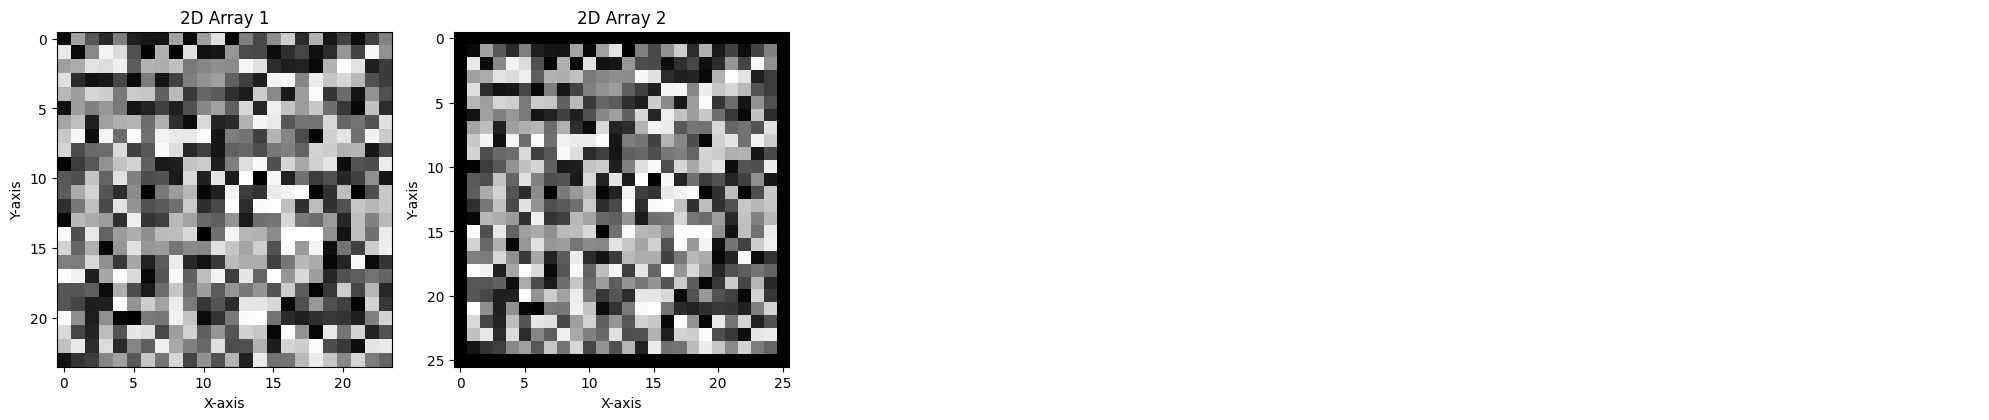

In [93]:
import numpy as np

array_25x25 = np.random.rand(24, 24)

padded_arr = pad_or_crop_to_shape(array_25x25, (26, 26))
print(padded_arr.shape)
visualize_2d_array([array_25x25, padded_arr])

### Extracting data from hexagons into np files for training with feature selections

In [49]:
#fetch all files in the folders: ['../data/data_layers/soil_grid', '../data/data_layers/worldClim', '../data/data_layers/landuse']
import os
# Define directories to search for raster files
def fetch_raster_files(include_files=None):
    directories = [
        '../data/data_layers/soil_grid',
        '../data/data_layers/worldClim',
        '../data/data_layers/landuse',
        #'../data/data_layers/predictors_100_QC'
        '../data/data_layers/predictors_100_QC_normalized',
    ]
    raster_files = []
    for directory in directories:
        for root, _, files in os.walk(directory):
            for file in files:
                if include_files is not None:
                    #if ends with .tif and there is no match in exclude_files
                    if file.endswith('.tif') and any(exclude in file for exclude in include_files):
                        raster_files.append(os.path.join(root, file))
                else:
                    if file.endswith('.tif'):
                        raster_files.append(os.path.join(root, file))
    return raster_files


#extract only the file directory name
#raster_files = fetch_raster_files(directories, include_files=['utilisation_territoire_2020'])

#get directory names from the file paths
#raster_file_dirs = [os.path.basename(file) for file in directories]


###  Normalizing data for training min/max scaling

In [16]:
def normalize_data(data):
    """
    Normalize the data to the range [0, 1] for each band.
    
    Parameters:
    ----------
    data : numpy.ndarray
        The input data array with shape (cells, bands, height, width).
    
    Returns:
    -------
    numpy.ndarray
        The normalized data array.
    """
    if data.ndim != 4:
        raise ValueError("Input data must be a 4D array with shape (cells, bands, height, width).")
    
    # Initialize an array to hold normalized data
    normalized_data = np.zeros_like(data)
    
    # Normalize each band independently
    for band in range(data.shape[1]):
        band_data = data[:, band, :, :]
        band_min = np.nanmin(band_data)
        band_max = np.nanmax(band_data)
        
        if band_max > band_min:
            normalized_data[:, band, :, :] = (band_data - band_min) / (band_max - band_min)
        else:
            normalized_data[:, band, :, :] = 0  # or np.nan if you prefer
    
    return normalized_data
    arr_norm = data.copy()
    for band in range(data.shape[1]):
        band_data = data[:, band, :, :]
        band_min = np.nanmin(band_data)
        band_max = np.nanmax(band_data)
        if band_max > band_min:
            arr_norm[:, band, :, :] = (band_data - band_min) / (band_max - band_min)
        else:
            arr_norm[:, band, :, :] = 0  # or np.nan if you prefer
    return arr_norm

In [308]:
#always extract all satelitte bands
h3_cells = [processed_species['h3_index'].values[0]]
expanded_cells = [expand_hexagon(h3_cell, 100) for h3_cell in h3_cells]
sat_bands = extract_all_bands_for_geom(expanded_cells)
arr_norm = normalize_data(sat_bands)
visualize_2d_array([arr_norm[0, 0]])  # Visualize the first band of the first cell

TypeError: cannot unpack non-iterable NoneType object

In [106]:
def get_max_shape(expanded_cells, raster_paths):
    test_no_resize = extract_all_bands_for_uni_band(
        geometries=expanded_cells[:10],
        raster_paths=raster_paths
    )

    max_shape = (0,0)
    for bands in test_no_resize:
        for cell in bands:
            max_shape = np.maximum(max_shape, cell.shape)
    return max_shape

In [248]:
parent_folders = [os.path.basename(os.path.dirname(f)) for f in raster_files]
file_df = pd.DataFrame({
    'file_path': raster_files,
    'parent_folder': parent_folders
})
#iterate trough parent_folder groups
for folder in file_df['parent_folder'].unique():
    group_file_paths = file_df[file_df['parent_folder'] == folder]['file_path'].values
    print(group_file_paths)
    print(f"Processing folder: {folder}")
    # Further processing for each group

['../data/data_layers/soil_grid/Leptosols.tif'
 '../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif'
 '../data/data_layers/soil_grid/Phaeozems.tif'
 '../data/data_layers/soil_grid/Vertisols.tif'
 '../data/data_layers/soil_grid/Podzols.tif'
 '../data/data_layers/soil_grid/Histosols.tif']
Processing folder: soil_grid
['../data/data_layers/worldClim/clipped_wc2.1_30s_bio_15.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_16.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_11.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_13.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_7.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_2.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_3.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_4.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_19.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_18.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_17.tif'
 '.

In [14]:
def expand_cell(h3_cells, expand_factor, to_square=False, to_crs='EPSG:4326'):
    """
    Expand a hexagonal cell to a square cell by a given factor.
    """
    expanded_cells = []
    for h3_cell in h3_cells:
        if to_square:
            expanded_cells.append(expand_hexagon_to_square(h3_cell,to_crs, expand_factor ))
        else:
            expanded_cells.append(expand_hexagon(h3_cell,to_crs, expand_factor))
    return expanded_cells

In [21]:
def prepare_data_with_feature_importance(data, input_raster_files = None, transform_to_squares=False, with_resize=True, no_sat = False):
    """
    Prepare data for feature importance analysis by extracting and resizing bands.
    Process all satelitte bands, environmental data from SoilGrids, WorldClim, and landuse data.
    Creates 3 different files: environment.npy, sat_bands.npy, and landuse.npy.
    Parameters:
    ----------
    feature_importance_df : pandas.DataFrame
        DataFrame containing feature importance information.
    raster_files : list
        List of raster file paths to extract data from.
    
    Returns:
    -------
    None
    """
    file_end = "_squares" if transform_to_squares else ""
    expanded_cells = data[['expanded_cells']].values.flatten().tolist()
    if(not no_sat):
        sat_bands = extract_all_bands_for_geom(expanded_cells, to_squares=transform_to_squares)
        
        sat_bands = normalize_data(sat_bands)  # Normalize the satellite bands

        print("Processed satellite bands shape:", sat_bands.shape)

        np.save(f'../data/misc/sat_bands{file_end}.npy', sat_bands)
        target_shape = sat_bands[0].shape
        print("Processed satellite bands shape:", target_shape)
    
    # Further processing for each group
    # Extract and resize bands for each raster file
    if not no_sat and with_resize:
        other_bands = extract_resize_for_other_data(
            geometries=expanded_cells,
            raster_paths=input_raster_files,
            target_shape=target_shape[1:]
        )
        other_bands = normalize_data(other_bands)  # Normalize the environmental bands
        
        np.save(f'../data/misc/environment{file_end}.npy', other_bands)
    #if no resize process each fodlers separately to not crop different data soures togheter
    else:
        parent_folders = [os.path.basename(os.path.dirname(f)) for f in input_raster_files]
        print("Parent folders:", parent_folders)
        file_df = pd.DataFrame({
            'file_path': input_raster_files,
            'parent_folder': parent_folders
        })
        for folder in file_df['parent_folder'].unique():
            group_file_paths = file_df[file_df['parent_folder'] == folder]['file_path'].values
            #max_shape = get_max_shape(expanded_cells, group_file_paths)
            other_bands = extract_resize_for_other_data(
                geometries=expanded_cells,
                raster_paths=group_file_paths,
                #target_shape=max_shape  # Skipping depth dimension for this method, only need height and width
            )
            # Save np array to file
            #the data from predictors_100_QC is already normalized
            #other_bands = normalize_data(other_bands)  # Normalize the environmental bands
            np.save(f'../data/misc/{folder}{file_end}.npy', other_bands)
            print(f"Processed {folder} bands shape:", other_bands.shape)
    if(not no_sat):
        landuse_band = extract_resize_for_other_data(
            geometries=expanded_cells,
            raster_paths=['../data/data_layers/landuse/utilisation_territoire_2020_clipped.tif'],
            target_shape=target_shape[1:]  # Skipping depth dimension for this method, only need height and width
        )
        # Save np array to file
        np.save(f'../data/misc/landuse{file_end}.npy', landuse_band)
        print("Processed landuse bands shape:", landuse_band.shape)


# # Extract and resize bands for each directory
# for dir in directories:
#     dir_name = os.path.basename(dir)
#     raster_paths = fetch_raster_files([dir])
#     other_bands = extract_resize_for_other_data(
#         geometries=expanded_cells,
#         #raster_paths=['../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif',],
#         raster_paths=raster_paths,
#         target_shape=target_shape[1:]#skipping depth dimensino for this method, only need height and width
#     )
#     print(f"Extracted and resized bands for {dir_name}: {other_bands.shape}")
#     #save np array to file
#     np.save(f'../data/misc/{dir_name}.npy', other_bands)

In [13]:
def remove_out_of_bounds(df):
    """
    Remove rows from the DataFrame where the geometry is out of bounds of the raster.
    """
    #path = '../data/data_layers/soil_grid/Acrisols.tif'
    path = '../data/data_layers/predictors_100_QC/alluvion.tif'
    with rasterio.open(path) as src:
        raster_bounds_poly = box(*src.bounds)
        print(f"crs: {src.crs}")

    # Convert expanded_cells to a GeoSeries before using .within()
    mask = gpd.GeoSeries(df['expanded_cells']).within(raster_bounds_poly)
    df = df[mask]

    return df.reset_index(drop=True)

In [17]:
expanded_cells = expand_cell(
    h3_cells=processed_species['h3_index'].values,
    expand_factor=100,
    to_square=True,  # Set to True if you want square cells
    to_crs='EPSG:6624'
)
if 'expanded_cells' in processed_species.columns:
    processed_species = processed_species.drop(columns=['expanded_cells'])
#merge expanded_cells into processed_species DataFrame as a new column
processed_species['expanded_cells'] = expanded_cells

processed_species_ok = remove_out_of_bounds(processed_species)
print(f"Removed {len(processed_species) - len(processed_species_ok)} out-of-bounds geometries.")


crs: EPSG:6624
Removed 58 out-of-bounds geometries.


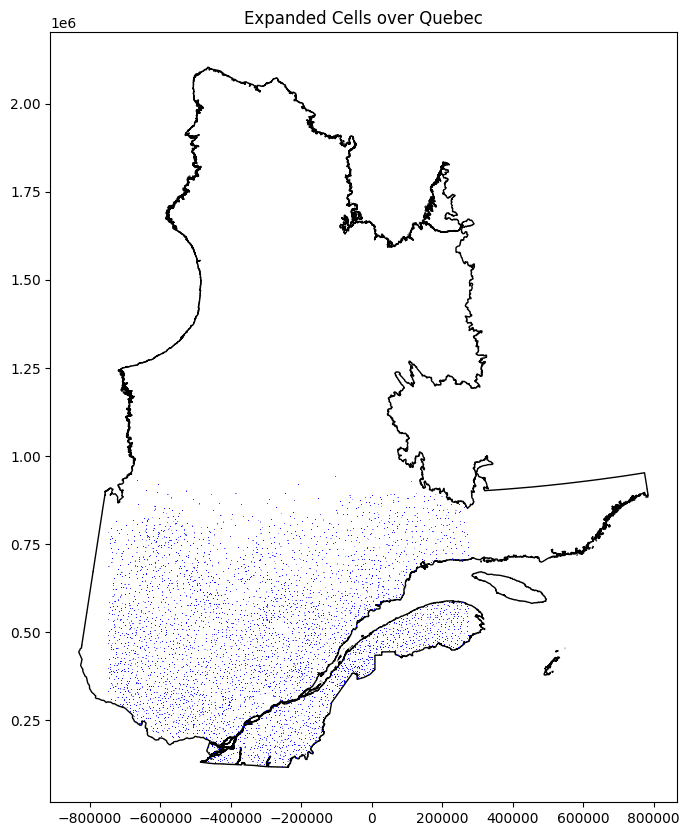

In [18]:
import matplotlib.pyplot as plt
import geopandas as gpd
gdf = gpd.read_file('../data/boundaries/lpr_000b16a_e/lpr_000b16a_e.shp')
quebec_gdf = gdf[gdf['PRENAME'] == 'Quebec']

# apply crs to the geodataframe
quebec_gdf = quebec_gdf.to_crs(epsg=6624)
# Ensure expanded_cells_gdf is a GeoDataFrame and set CRS to match quebec_gdf
expanded_cells_gdf = gpd.GeoDataFrame(geometry=processed_species_ok['expanded_cells'], crs=quebec_gdf.crs)
expanded_cells_gdf['h3_index'] = processed_species_ok['h3_index'].values
# Plot both on the same matplotlib axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Quebec boundary
quebec_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot the expanded cells
expanded_cells_gdf.plot(ax=ax, color='blue', alpha=0.4)

plt.title("Expanded Cells over Quebec")
# Remove plt.axis("off") to avoid ValueError: aspect must be finite and positive
plt.show()


In [20]:
# Ensure Quebec boundary is simplified (optional but helpful)
quebec_gdf = quebec_gdf.explode(index_parts=False).reset_index(drop=True)

# Spatial join using 'within' or 'intersects' (use 'intersects' if you want looser filtering)
filtered_cells = gpd.sjoin(expanded_cells_gdf, quebec_gdf, predicate="within", how="inner")

# Drop join column if not needed
filtered_cells = filtered_cells.drop(columns=["index_right"])

#only keep the rows in processed_species_ok that are in filtered_cells
processed_species_ok = processed_species_ok[processed_species_ok['h3_index'].isin(filtered_cells['h3_index'])].reset_index(drop=True)

processed_species_ok.to_csv('../data/data_layers/model_inputs/cell_data/processed_species_ok.csv', index=False)


In [108]:
cont_zonal_stats_path = '../data/data_layers/model_inputs/cell_data/continuous_zonal_stats_res_12_pred_100_QC_normalized.csv'
#cont_zonal_stats_path = '../data/misc/continuous_zonal_stats_res_12.csv'
feature_importance_df = get_feature_importance_for_species('ERP', cont_zonal_stats_path, cat_zonal_stats_path=None, remove_landuse=True, treshold=0.01)

#read the continuous zonal stats csv file
import pandas as pd
cont_zonal_stats_df = pd.read_csv(cont_zonal_stats_path)

#only keep rows that are in processed_species_ok
cont_zonal_stats_df = cont_zonal_stats_df[cont_zonal_stats_df['h3_index'].isin(processed_species_ok['h3_index'])].reset_index(drop=True)

# The feature_importance_df['feature_name'] likely contains base names without the '_value' suffix.
# We'll try to match columns ending with '_value' for each feature name.

# Get all columns in the DataFrame
all_columns = cont_zonal_stats_df.columns

# Try to match columns with '_value' suffix, fallback to exact match if not found
selected_columns = []
for feat in feature_importance_df['feature_name']:
	# Prefer columns ending with '_value'
	candidates = [col for col in all_columns if col == feat or col == f"{feat}_value"]
	if not candidates:
		# Try to find columns that start with the feature name (for safety)
		candidates = [col for col in all_columns if col.startswith(feat)]
	if candidates:
		selected_columns.append(candidates[0])
	else:
		print(f"Warning: Feature '{feat}' not found in DataFrame columns.")

# Keep only the selected columns
cont_zonal_stats_df_filtered = cont_zonal_stats_df[selected_columns]

cont_zonal_stats_df_filtered
# Save the DataFrame to a new CSV file
cont_zonal_stats_df_filtered.to_csv('../data/data_layers/model_inputs/cell_data/continuous_zonal_stats_res_12_pred_100_QC_normalized_filtered.csv', index=False)

length of importances: 66
length of selected_feature_names: 33


In [92]:
feature_importance_df

feature_name  importance
11  mean_daily_mean_air_temperatures_of_the_coldes...    0.238415
26                        mean_annual_air_temperature    0.126741
15                                          deciduous    0.098851
43                                         ruggedness    0.029652
48                                           geomflat    0.023735
27                                              roche    0.022098
65                                          glaciaire    0.019020
23                                         coniferous    0.016023
64  mean_monthly_precipitation_amount_of_the_colde...    0.014136
10                             tourbiere_minerotrophe    0.012659
30                                     glaciolacustre    0.012213
55  mean_daily_mean_air_temperatures_of_the_wettes...    0.011912
24                                              mixed    0.011801
53                                   tourbiere_boisee    0.011800
2   mean_daily_mean_air_temperatures_of_the_driest...    0.010995
28          precipitation_amount_of_the_wettest_month    0.010259
46                                      isothermality    0.010199
35  mean_daily_maximum_air_temperature_of_the_warm...    0.010038

In [ ]:
raster_files = fetch_raster_files(include_files=feature_importance_df['feature_name'].values)
# add the combined mask
raster_files.append('../data/data_layers/predictors_100_QC/combined_mask.tif')
env_data = prepare_data_with_feature_importance(processed_species_ok, raster_files, transform_to_squares=True, no_sat=True, with_resize=False)

Parent folders: ['predictors_100_QC']
Processing raster 1/1: ../data/data_layers/predictors_100_QC/combined_mask.tif
Minimum shape of extracted bands: (22, 22)
Maximum shape of extracted bands: (24, 24)
Found 43 cells with the minimal shape:
 - Band 0, Cell 620
 - Band 0, Cell 4517
 - Band 0, Cell 5022
 - Band 0, Cell 5685
 - Band 0, Cell 5990
 - Band 0, Cell 7005
 - Band 0, Cell 7032
 - Band 0, Cell 7051
 - Band 0, Cell 7362
 - Band 0, Cell 7366
Found 0 bands/cells with a shape smaller than 17 in any dimension:
Processed predictors_100_QC bands shape: (24528, 1, 22, 22)


(15, 18, 22, 22)


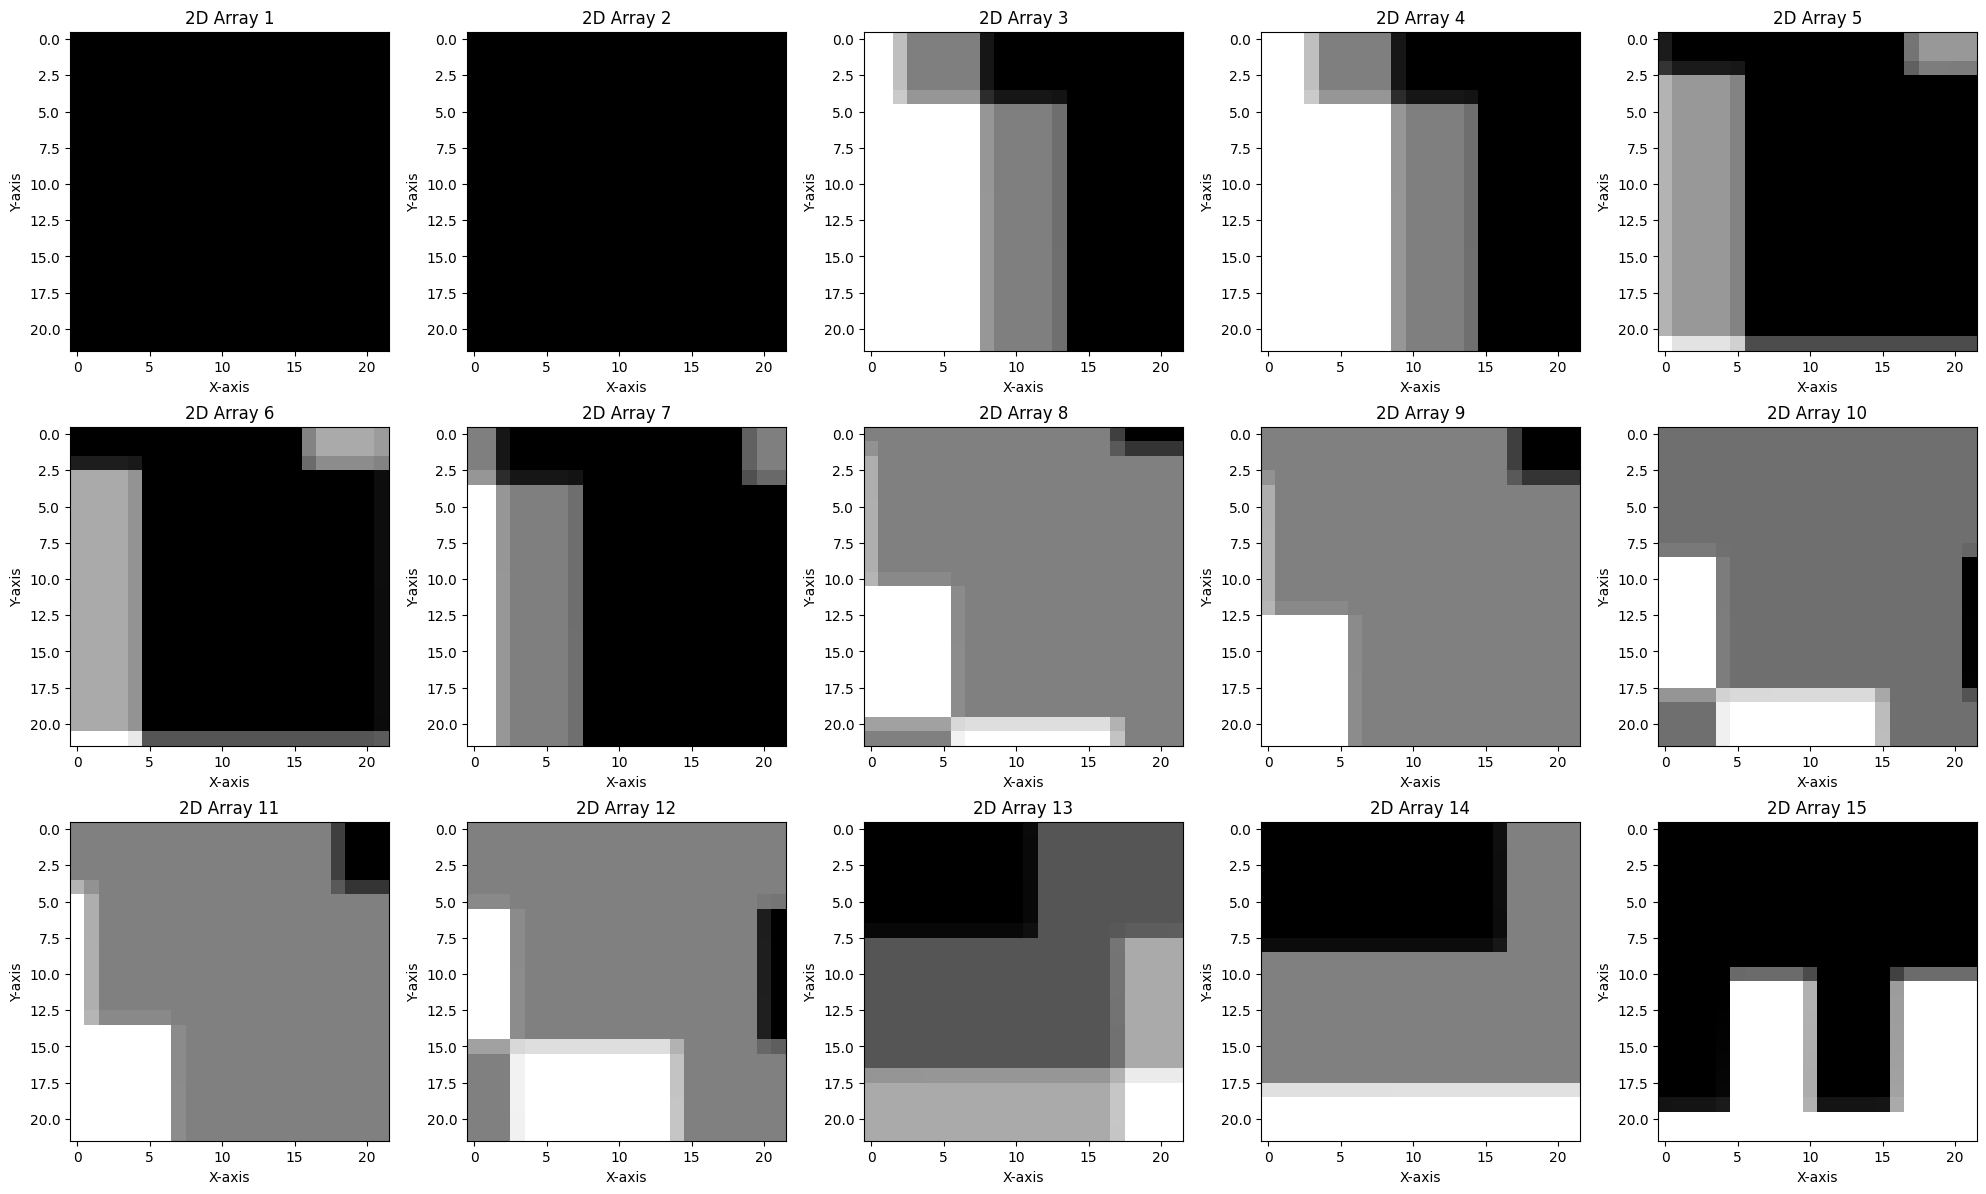

In [96]:
#read .npy files
import numpy as np

env_data = np.load('../data/misc/predictors_100_QC_normalized_squares.npy')[:15]
#env_data = np.load('../data/misc/soil_grid_squares.npy')
#env_data = np.load('../data/misc/worldClim.npy')
print(env_data.shape)
# Visualize the first band of all the cells
visualize_2d_array([env_data[i, 0] for i in range(env_data.shape[0])])

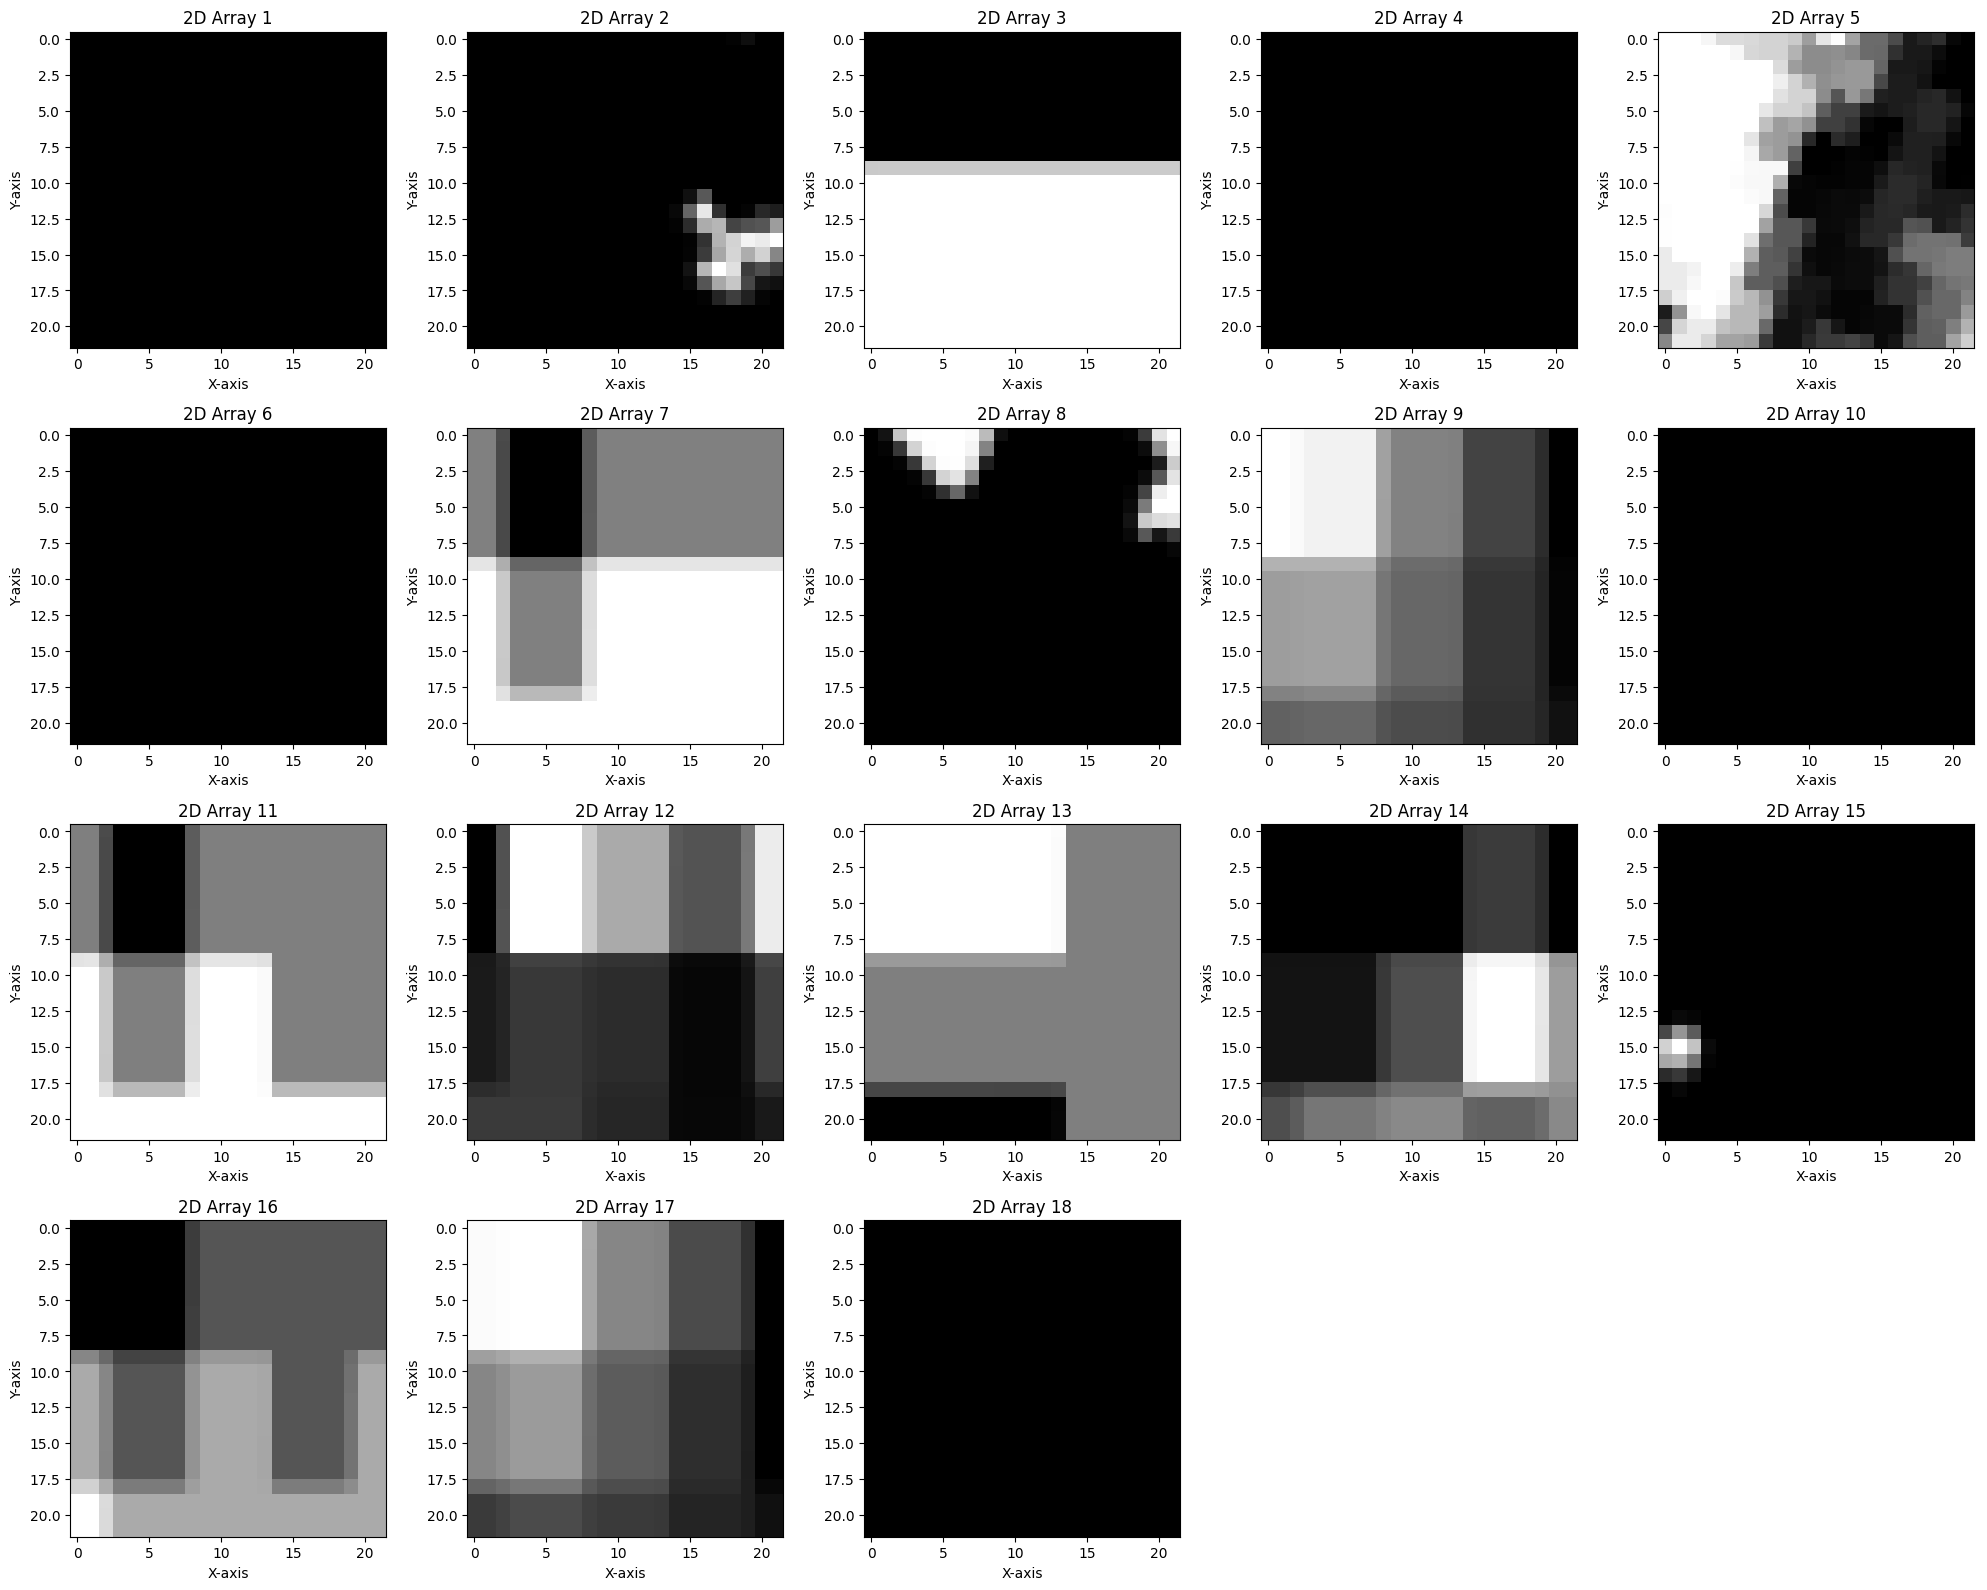

In [97]:
visualize_2d_array([env_data[1, i] for i in range(env_data.shape[1])])

In [ ]:
[env_data[0, 1]]


[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int16)]

### Figuring out how to stack bands 

POLYGON ((-75.01934286056813 47.04929490295433, -75.01949196676215 47.04927092138622, -75.01953577067272 47.04917341771896, -75.01943046890267 47.04909989576222, -75.01928136326327 47.049123877221945, -75.01923755883931 47.049221380746815, -75.01934286056813 47.04929490295433))


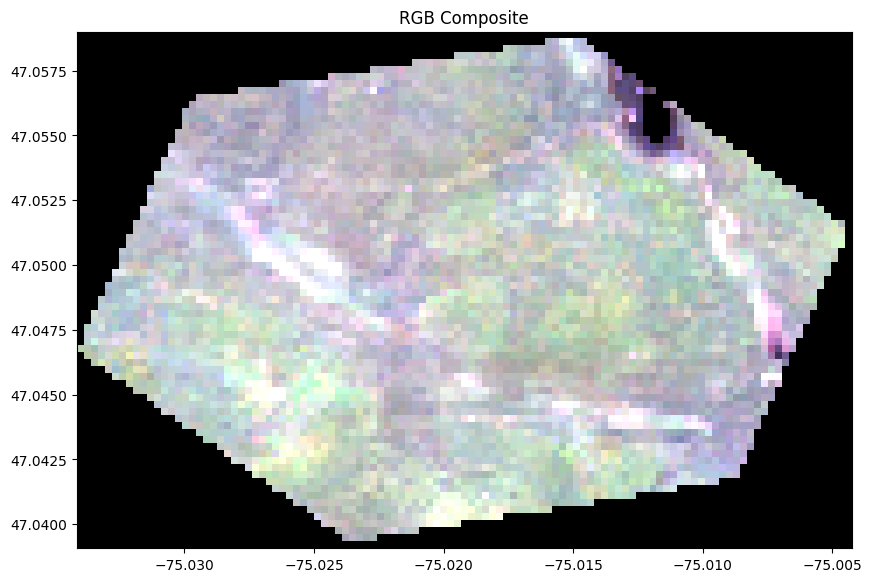

In [52]:
import matplotlib.pyplot as plt

geom = processed_species['geometry'].values[1000]
h3_cell = processed_species['h3_index'].values[1000]
expanded_geom = expand_hexagon(h3_cell, 100)  # Expand the hexagon by 10% of its size
#print(expanded_geom)
print(geom)
out_image_rgb, clipped_bounds_rgb = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif")
out_image_false_color, clipped_bounds_false_color = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_FalseColor.tif")
out_image_ndvi, clipped_bounds_ndvi = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_NDVI.tif")
out_image_swir, clipped_bounds_swir = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_SWIR.tif")
#out_image, clipped_bounds = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif")


# Plot the normalized data with color scale from 0 to 1
#vis_one_band_raster(out_image, clipped_bounds)
# Plot the RGB composite
vis_rgb_raster(out_image, clipped_bounds)

    # Define band combinations
    band_sets = {
        "RGB": ['B4', 'B3', 'B2'],
        "FalseColor": ['B8', 'B4', 'B3'],
        "SWIR": ['B11', 'B8'],
        "NDVI": ['NDVI'],
        "moisture": ['moisture']
    }

In [ ]:
B4 = out_image_rgb[0]
B3 = out_image_rgb[1]
B2 = out_image_rgb[2]
B8 = out_image_false_color[0]
B11 = out_image_swir[0]

# stackk all the bands
stacked_bands = np.stack([B4, B3, B2, B8, B11], axis=0)

In [57]:
stacked_bands.shape

(5, 74, 111)

In [78]:
# Calculate padding amounts (top/bottom)
pad_total = 111 - 74
pad_top = pad_total // 2
pad_bottom = pad_total - pad_top

def pad_band(band):
    # Pad height (axis=0), leave width (axis=1) unchanged
    padded_tile = np.pad(
        band,
        pad_width=((pad_top, pad_bottom), (0, 0)),  # Pad only height, no padding for width
        mode='constant',  # For zero-padding
        constant_values=0  # Or use `mode='reflect'`
    )
    return padded_tile

B2_padded = pad_band(B2)
B3_padded = pad_band(B3)
B4_padded = pad_band(B4)

stacked_bands_padded = np.stack([B4_padded, B3_padded, B2_padded], axis=0)

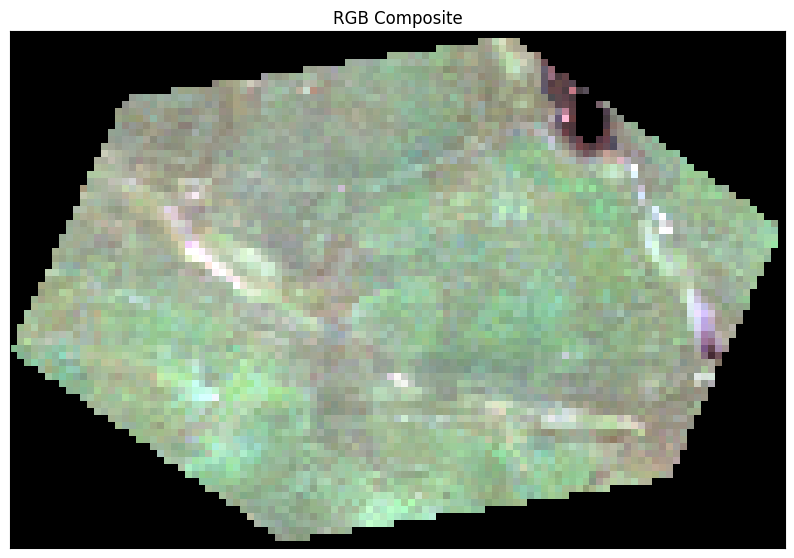

<Axes: title={'center': 'RGB Composite'}>

In [80]:
import earthpy.plot as ep

ep.plot_rgb(
    stacked_bands,
    rgb=(2, 1, 0),
    stretch=True,
    title="RGB Composite",
    figsize=(10, 10),
    str_clip= 0.2
)

### Data augmentation testing

In [195]:
stacked_bands.shape

(5, 74, 111)

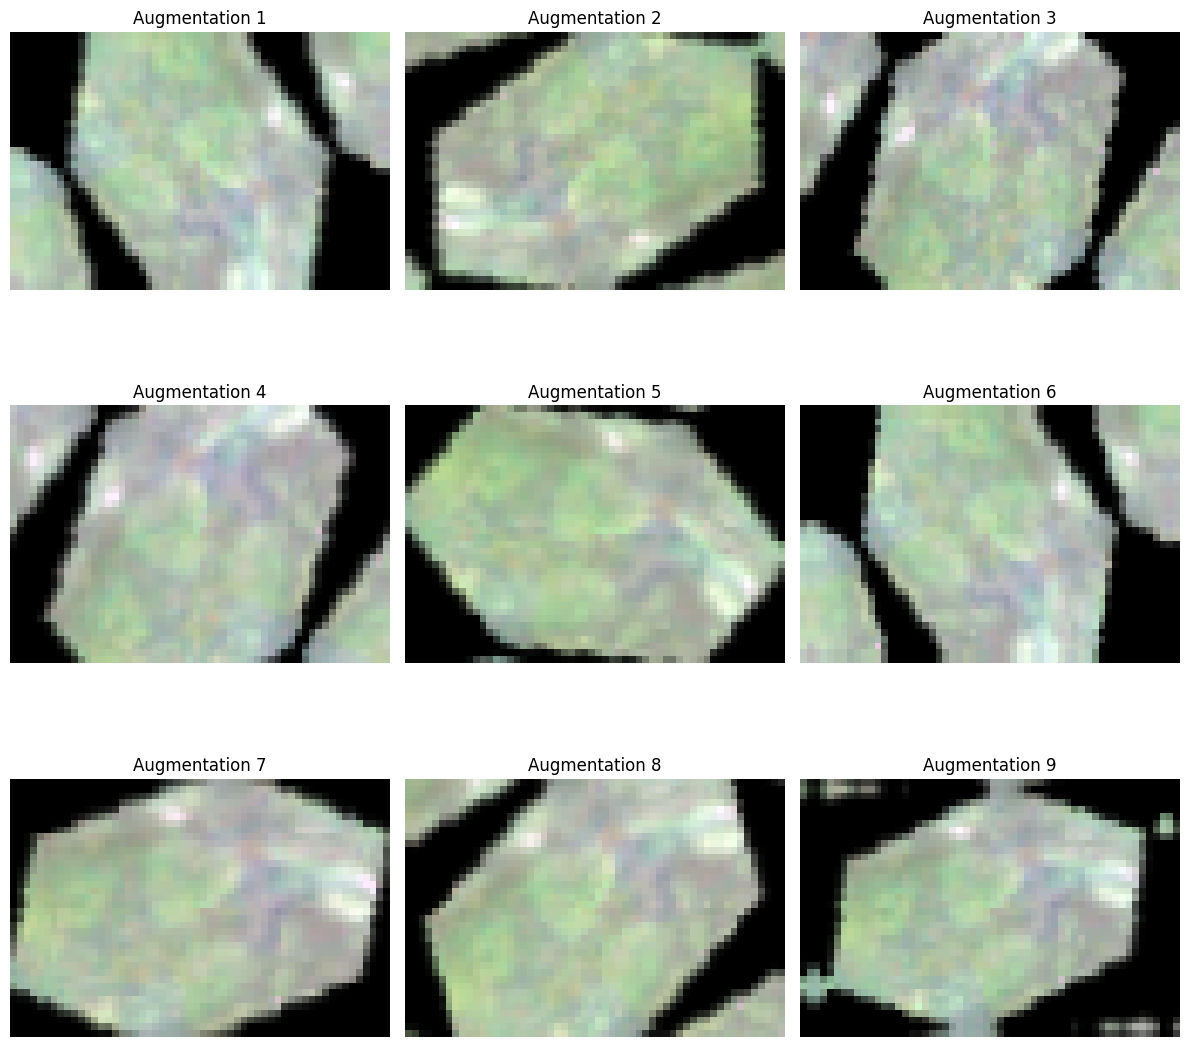

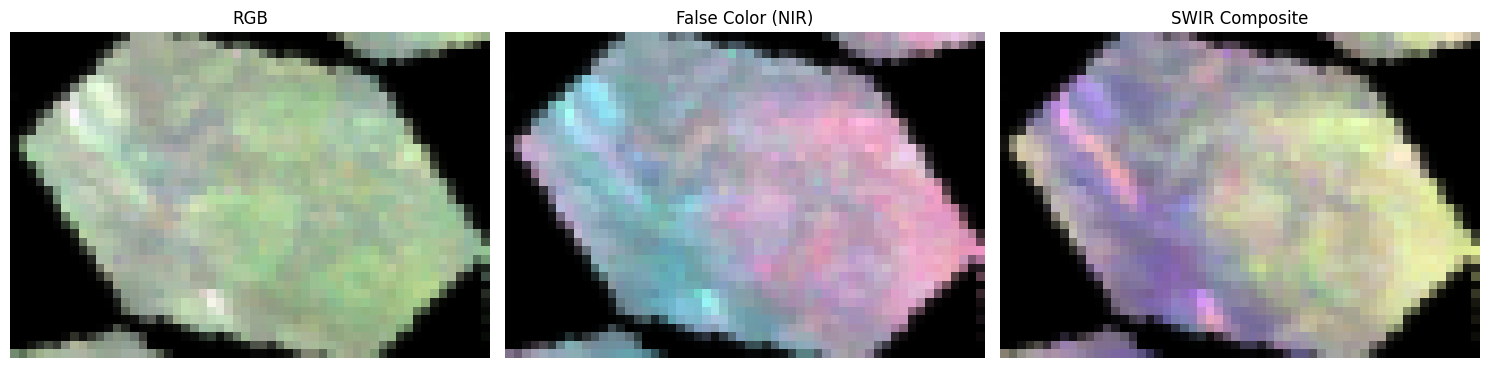

In [199]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Define augmentation sequence
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    # No intensity/brightness transformations since spectral values have physical meaning
])

# Function to visualize RGB composite from multispectral data
def visualize_rgb(image_array, band_indices=(0, 1, 2)):
    """
    Visualize RGB composite from bands in multispectral image
    
    Parameters:
    -----------
    image_array: Array with shape (bands, height, width) or (height, width, bands)
    band_indices: Tuple with indices for (R, G, B) bands
    """
    # Check if bands are in the first dimension
    if image_array.shape[0] < image_array.shape[-1]:
        # Convert from (bands, height, width) to (height, width, bands)
        image_array = np.transpose(image_array, (1, 2, 0))
    
    # Extract RGB bands
    rgb = image_array[:, :, band_indices]
    
    # Normalize for visualization
    rgb_norm = np.zeros_like(rgb, dtype=np.float32)
    for i in range(3):
        band = rgb[:, :, i]
        if np.max(band) > np.min(band):
            rgb_norm[:, :, i] = (band - np.min(band)) / (np.max(band) - np.min(band))
    
    return rgb_norm

# Rearrange to (height, width, bands) for Keras
#raster_data = np.transpose(stacked_bands, (1, 2, 0))

# Add batch dimension required by Keras
raster_batch = tf.convert_to_tensor(raster_data)
raster_batch = tf.expand_dims(raster_batch, 0)

# Apply augmentation and visualize results
plt.figure(figsize=(12, 12))
for i in range(9):
    # Generate a new augmented image for each plot
    augmented_image = data_augmentation(raster_batch, training=True)
    
    # Extract RGB bands for visualization
    rgb_display = visualize_rgb(augmented_image[0].numpy(), band_indices=(0, 1, 2))
    
    # Plot
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(rgb_display)
    plt.title(f"Augmentation {i+1}")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

# If you want to visualize other band combinations (like False Color or SWIR)
plt.figure(figsize=(15, 5))
augmented_image = data_augmentation(raster_batch, training=True)

# RGB
plt.subplot(1, 3, 1)
plt.imshow(visualize_rgb(augmented_image[0].numpy(), band_indices=(0, 1, 2)))
plt.title("RGB")
plt.axis("off")

# False Color (NIR, Red, Green)
plt.subplot(1, 3, 2)
plt.imshow(visualize_rgb(augmented_image[0].numpy(), band_indices=(3, 0, 1)))
plt.title("False Color (NIR)")
plt.axis("off")

# SWIR composite
plt.subplot(1, 3, 3)
plt.imshow(visualize_rgb(augmented_image[0].numpy(), band_indices=(4, 3, 0)))
plt.title("SWIR Composite")
plt.axis("off")

plt.tight_layout()
plt.show()

### Feature importance


only keep the raster to extract data for the CNN with a feature importance > 0.01

In [ ]:
# import gc
# h3_cells = processed_species['h3_index'].values
# expanded_cells = [expand_hexagon(h3_cell, 100) for h3_cell in h3_cells]
# extracted_bands_satelitte = extract_all_bands_for_geom(expanded_cells)
# print(f"Extracted {len(extracted_bands_satelitte)} hexagons with {len(extracted_bands_satelitte[0])} bands each.")
# #normalize shapes
# # Determine the target shape (e.g., the maximum shape among all arrays)
# target_shape = tuple(np.max([band.shape for band in extracted_bands_satelitte], axis=0))

# # Pad or crop all elements in extracted_bands to the target shape
# extracted_bands_satelitte = np.array([pad_or_crop_to_shape(band, target_shape) for band in extracted_bands_satelitte])
# print(f"Final shape of extracted bands: {extracted_bands_satelitte.shape}")
# extracted_bands_other = extract_resize_for_other_data(
#     geometries=expanded_cells,
#     raster_paths=raster_files,
#     target_shape=target_shape[1:]#skipping depth dimensino for this method, only need height and width
# )
# extracted_bands_combined = np.concatenate((extracted_bands_satelitte, extracted_bands_other), axis=1)
# print(f"Extracted {len(extracted_bands_other)} hexagons with {len(extracted_bands_other[0])} bands each.")
# #save the extracted bands to a numpy file


# extracted_bands_landuse = extract_resize_for_other_data(
#     geometries=expanded_cells,
#     raster_paths=['../data/data_layers/landuse/utilisation_territoire_2020_clipped.tif'],
#     target_shape=target_shape[1:]#skipping depth dimensino for this method, only need height and width
# )

Extracted 4619 hexagons with 5 bands each.
Final shape of extracted bands: (4619, 5, 74, 114)
Processing raster 1/24: ../data/data_layers/soil_grid/Leptosols.tif
Processing raster 2/24: ../data/data_layers/soil_grid/Phaeozems.tif
Processing raster 3/24: ../data/data_layers/soil_grid/Podzols.tif
Processing raster 4/24: ../data/data_layers/soil_grid/Cambisols.tif
Processing raster 5/24: ../data/data_layers/soil_grid/Solonetz.tif
Processing raster 6/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_15.tif
Processing raster 7/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_16.tif
Processing raster 8/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_11.tif
Processing raster 9/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_13.tif
Processing raster 10/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_7.tif
Processing raster 11/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_2.tif
Processing raster 12/24: ../data/data_layers/worldClim/clipped_wc2.1_30

### Old model

I tried to use all the data within the same model. I upsampled the climate and soil data to match with the high resolution satelitte images, and downsampled the landuse raster but i got very poor performance(50-60% on training)... Will try with the concat method to see if having multiple model specific for resolution works better. FEATURE FUSION CNN

## Trying late fusion models

### Exploring validation splits

In [148]:
processed_species_ok = gpd.read_file('../data/data_layers/model_inputs/cell_data/processed_species_ok.csv')


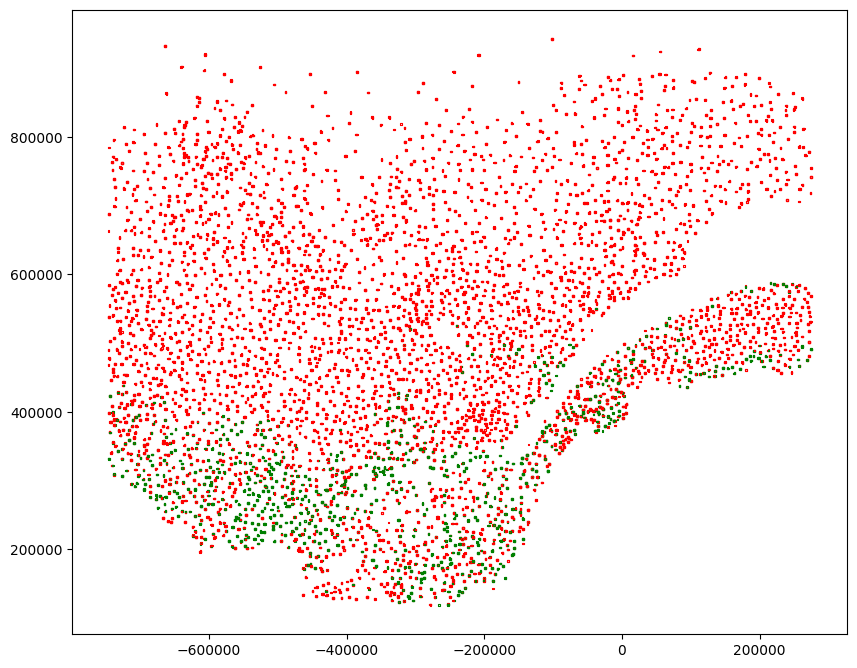

In [132]:
# Define edge colors based on ERP presence (1 = red, 0 = green)
edge_colors = gdf['ERP'].map({0: 'red', 1: 'green'})

# Plot with transparent fill and colored edges
ax = gdf.plot(
    facecolor='none',         # No fill, just edges
    edgecolor=edge_colors,
    linewidth=0.8,
    figsize=(10, 10)
)


--- Generating Splits ---

Searching for split with target difference ~0.0%
  Checking a random sample of 10000 combinations out of 53130 total.
  Found for target ~0.0%: Actual Diff: 0.0000, Train ERP Ratio: 0.1757, Val ERP Ratio: 0.1757

Searching for split with target difference +2.5%
  Checking a random sample of 10000 combinations out of 53130 total.
  Found for target +2.5%: Actual Diff: 0.0246, Train ERP Ratio: 0.1796, Val ERP Ratio: 0.1549

Searching for split with target difference -2.5%
  Checking a random sample of 10000 combinations out of 53130 total.
  Found for target -2.5%: Actual Diff: -0.0252, Train ERP Ratio: 0.1707, Val ERP Ratio: 0.1960

Searching for split with target difference +5.0%
  Checking a random sample of 10000 combinations out of 53130 total.
  Found for target +5.0%: Actual Diff: 0.0503, Train ERP Ratio: 0.1841, Val ERP Ratio: 0.1338

Searching for split with target difference -5.0%
  Checking a random sample of 10000 combinations out of 53130 total.
 

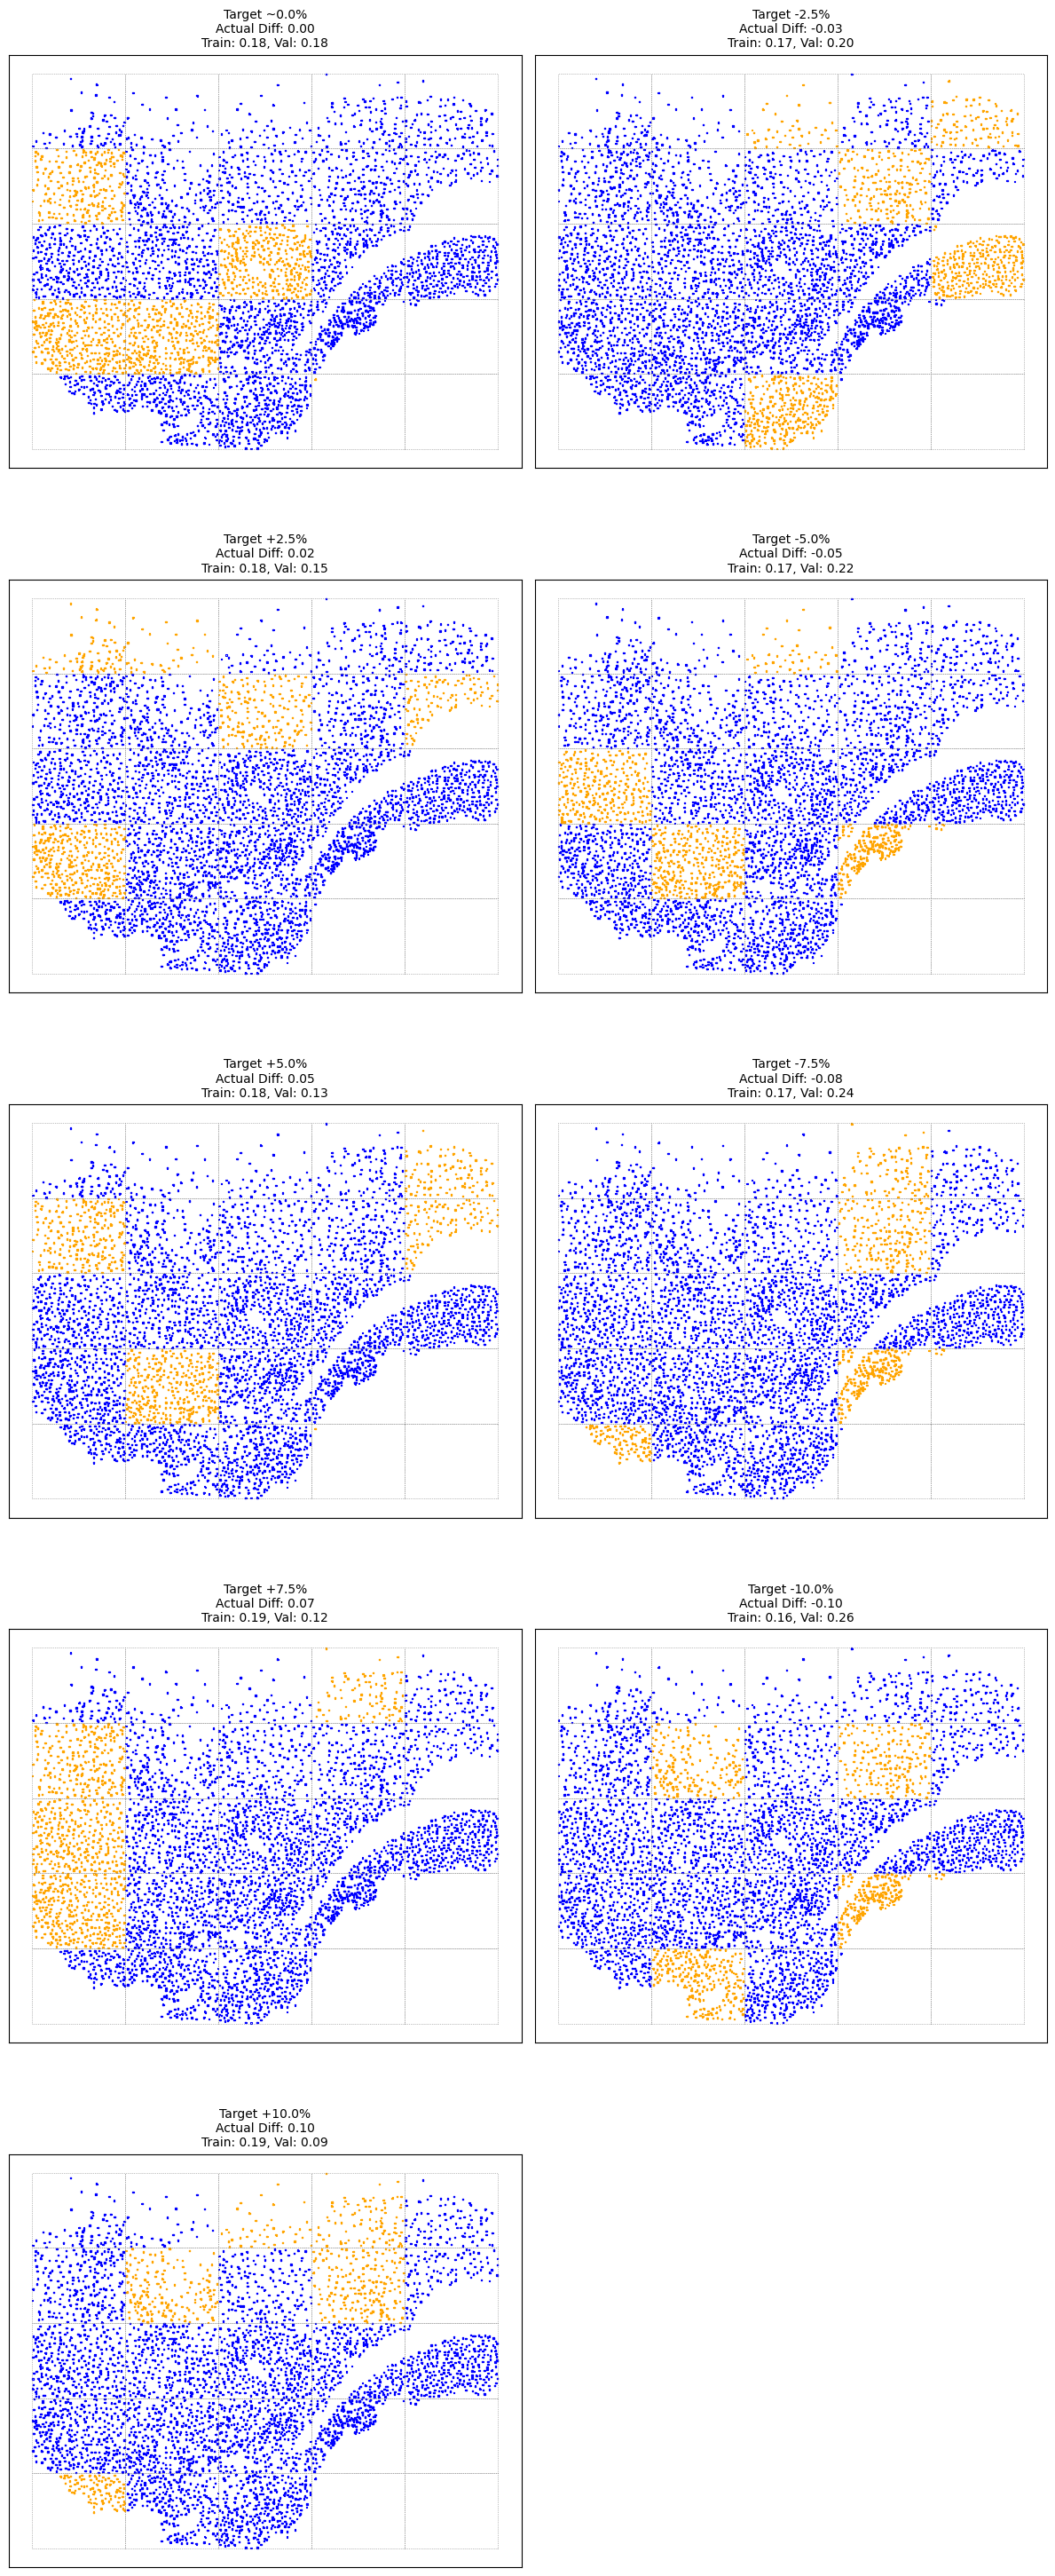


--- Final Chosen Split (Closest Ratio) ---
Training set size: 17369, Validation set size: 6625
Train ERP Ratio: 0.1757
Val ERP Ratio: 0.1757
Actual ERP Ratio Difference: 0.0000


In [150]:
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads as wkt_loads
from shapely.geometry import box
import matplotlib.pyplot as plt

# --- Configuration ---
NUM_VAL_PATCHES = 5
GRID_ROWS = 5
GRID_COLS = 5
# Target differences: (absolute_difference, sign)
# sign: 1 for (Train > Val), -1 for (Train < Val), 0 for closest to zero
TARGET_DIFFS_CONFIG = [
    (0.0, 0),    # Closest to 0 difference
    (0.025, 1),  # Train > Val by ~2.5%
    (0.025, -1), # Train < Val by ~2.5%
    (0.05, 1),   # Train > Val by ~5.0%
    (0.05, -1),  # Train < Val by ~5.0%
    (0.075, 1),  # Train > Val by ~7.5%
    (0.075, -1), # Train < Val by ~7.5%
    (0.10, 1),   # Train > Val by ~10.0%
    (0.10, -1)   # Train < Val by ~10.0%
]
MAX_COMBINATIONS_TO_CHECK = 10000 # Increase this if you have more patches and want to search more
RANDOM_SEED = 42


# Ensure expanded_cells are valid geometry objects
if not hasattr(processed_species_ok['expanded_cells'].iloc[0], 'geom_type'):
    processed_species_ok['expanded_cells'] = processed_species_ok['expanded_cells'].apply(wkt_loads)

gdf = gpd.GeoDataFrame(processed_species_ok, geometry='expanded_cells')

# Precompute ERP presence/absence for all cells
erp_labels = gdf['species_list'].apply(lambda x: 1 if 'ERP' in x else 0).values
gdf['ERP'] = erp_labels  # Add ERP as a column to gdf

# Compute bounding box
minx, miny, maxx, maxy = gdf.total_bounds

# Define grid size
n_rows = GRID_ROWS
n_cols = GRID_COLS

# Compute patch size
dx = (maxx - minx) / n_cols
dy = (maxy - miny) / n_rows

# Create list of patch polygons and tags
patches = []
patch_ids = []
for i in range(n_cols):
    for j in range(n_rows):
        x0 = minx + i * dx
        y0 = miny + j * dy
        x1 = x0 + dx
        y1 = y0 + dy
        patch = box(x0, y0, x1, y1)
        patches.append(patch)
        patch_ids.append(f"{i}_{j}")

# GeoDataFrame of patches
patch_gdf = gpd.GeoDataFrame({'patch_id': patch_ids, 'geometry': patches}, crs=gdf.crs)

# Spatial join to assign patch_id to each cell in gdf
# Ensure unique index for sjoin, if not already.
if not gdf.index.is_unique:
    gdf = gdf.reset_index(drop=True)
gdf = gpd.sjoin(gdf, patch_gdf, how='left', predicate='within')

# Handle cases where some cells might not fall into any patch after sjoin
initial_gdf_len = len(gdf)
gdf.dropna(subset=['patch_id'], inplace=True)
if len(gdf) < initial_gdf_len:
    print(f"Warning: {initial_gdf_len - len(gdf)} cells could not be assigned to a patch and were removed from gdf.")

# Recompute ERP presence/absence for all cells after dropping rows
erp_labels = gdf['species_list'].apply(lambda x: 1 if 'ERP' in x else 0).values
gdf['ERP'] = erp_labels  # Add ERP as a column to gdf

# Use patch_ids from patch_gdf
all_patch_ids = patch_gdf['patch_id'].values

# --- Function to find best patches for a given target difference and sign ---
def find_best_patches_for_ratio_diff(
    all_patch_ids, gdf, erp_labels, num_val_patches, target_abs_diff, sign,
    max_combinations=MAX_COMBINATIONS_TO_CHECK, seed=RANDOM_SEED
):
    """
    Finds a combination of validation patches that results in a train/val ERP ratio
    as close as possible to the target_abs_diff with the specified sign.

    Args:
        all_patch_ids (list): List of all available patch IDs.
        gdf (gpd.GeoDataFrame): GeoDataFrame with 'patch_id' and 'ERP' columns.
        erp_labels (np.ndarray): Array of ERP labels corresponding to gdf rows.
        num_val_patches (int): Number of patches to select for validation.
        target_abs_diff (float): The target *absolute* difference (e.g., 0.025).
        sign (int): +1 for (train > val), -1 for (train < val), 0 for closest to zero.
        max_combinations (int): Maximum number of combinations to check.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: (best_val_patch_ids, actual_train_val_diff, train_ratio, val_ratio)
               Returns (None, float('inf'), None, None) if no suitable combination is found.
    """
    best_overall_target_match_diff = float('inf')
    best_val_patch_ids = None
    best_train_ratio = None
    best_val_ratio = None
    best_actual_train_val_diff = None

    combinations = list(itertools.combinations(all_patch_ids, num_val_patches))
    
    total_combinations = len(combinations)
    if total_combinations > max_combinations:
        np.random.seed(seed)
        shuffled_indices = np.random.permutation(total_combinations)
        combinations = [combinations[i] for i in shuffled_indices[:max_combinations]]
        print(f"  Checking a random sample of {len(combinations)} combinations out of {total_combinations} total.")
    else:
        print(f"  Checking {total_combinations} total combinations.")

    for val_patch_ids in combinations:
        val_mask = gdf['patch_id'].isin(val_patch_ids)
        train_mask = ~val_mask

        if np.sum(train_mask) == 0 or np.sum(val_mask) == 0:
            continue

        y_train = erp_labels[train_mask.values]
        y_val = erp_labels[val_mask.values]

        if len(y_train) == 0 or len(y_val) == 0:
            continue

        train_ratio = np.sum(y_train) / len(y_train)
        val_ratio = np.sum(y_val) / len(y_val)
        
        actual_signed_diff = train_ratio - val_ratio

        # Determine the target value for the actual_signed_diff we are aiming for
        target_value_for_diff = target_abs_diff * sign if sign != 0 else 0.0
        
        # This is the value we want to minimize: how far our actual_signed_diff is from the target_value_for_diff
        match_diff = abs(actual_signed_diff - target_value_for_diff)

        # For non-zero target_abs_diff, we also need to ensure the sign is correct.
        # Add a small tolerance to prevent issues with floating point comparisons near zero.
        if sign == 1 and actual_signed_diff < -0.001: # We want positive diff (train > val), but got negative
            continue
        if sign == -1 and actual_signed_diff > 0.001: # We want negative diff (train < val), but got positive
            continue
        # If sign is 0, we don't apply these filters, as we're just seeking closest to 0.

        if match_diff < best_overall_target_match_diff:
            best_overall_target_match_diff = match_diff
            best_val_patch_ids = val_patch_ids
            best_train_ratio = train_ratio
            best_val_ratio = val_ratio
            best_actual_train_val_diff = actual_signed_diff # Store the actual signed difference

        if best_overall_target_match_diff < 0.0005: # Stricter tolerance for an "exact" match
            break

    return best_val_patch_ids, best_actual_train_val_diff, best_train_ratio, best_val_ratio

# --- Generate Splits for each Target Difference and Sign ---
# Stores results as { (target_abs_diff, sign): { ... } }
all_split_results = {}

print("\n--- Generating Splits ---")
for target_abs_diff, sign_val in TARGET_DIFFS_CONFIG:
    title_sign_char = ""
    if sign_val == 1:
        title_sign_char = "+"
    elif sign_val == -1:
        title_sign_char = "-"
    elif sign_val == 0:
        title_sign_char = "~" # For target 0, indicating 'approximately'

    print(f"\nSearching for split with target difference {title_sign_char}{target_abs_diff*100:.1f}%")
    val_patch_ids, actual_train_val_diff, train_ratio, val_ratio = \
        find_best_patches_for_ratio_diff(
            all_patch_ids, gdf, erp_labels, NUM_VAL_PATCHES, target_abs_diff,
            sign=sign_val,
            max_combinations=MAX_COMBINATIONS_TO_CHECK
        )

    if val_patch_ids:
        key = (target_abs_diff, sign_val)
        all_split_results[key] = {
            'val_patch_ids': val_patch_ids,
            'train_ratio': train_ratio,
            'val_ratio': val_ratio,
            'actual_train_val_diff': actual_train_val_diff # This is the signed actual diff
        }
        print(f"  Found for target {title_sign_char}{target_abs_diff*100:.1f}%: "
              f"Actual Diff: {actual_train_val_diff:.4f}, "
              f"Train ERP Ratio: {train_ratio:.4f}, Val ERP Ratio: {val_ratio:.4f}")
    else:
        print(f"  Could not find a suitable split for target {title_sign_char}{target_abs_diff*100:.1f}%.")

# --- Plotting the Results ---
print("\n--- Plotting Splits ---")
num_plots = len(all_split_results)

if num_plots == 0:
    print("No splits found to plot.")
else:
    ncols = 2 # Max 2 plots per row
    nrows = (num_plots + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), sharex=True, sharey=True)

    # Ensure axes is always a 2D array for consistent indexing
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1 or ncols == 1:
        axes = np.atleast_2d(axes)

    # Sort keys for consistent plotting order. Sort by target_abs_diff then by sign_val
    sorted_keys = sorted(all_split_results.keys(), key=lambda x: (x[0], x[1]))

    for ax_idx, key in enumerate(sorted_keys):
        target_abs_diff, sign_val = key
        result = all_split_results[key]

        row = ax_idx // ncols
        col = ax_idx % ncols
        ax = axes[row, col]
        
        current_val_patch_ids = result['val_patch_ids']
        
        gdf['plot_split'] = np.where(gdf['patch_id'].isin(current_val_patch_ids), 'val', 'train')
        
        edge_colors = gdf['plot_split'].map({'train': 'blue', 'val': 'orange'})

        # Plot cells
        gdf.plot(
            ax=ax,
            facecolor='none',
            edgecolor=edge_colors,
            linewidth=0.8
        )

        # Plot patch grid on top for visualization
        patch_gdf.plot(ax=ax, facecolor='none', edgecolor='gray', linestyle=':', linewidth=0.5)

        title_sign_char = ""
        if sign_val == 1:
            title_sign_char = "+"
        elif sign_val == -1:
            title_sign_char = "-"
        elif sign_val == 0:
            title_sign_char = "~"

        ax.set_title(f'Target {title_sign_char}{target_abs_diff*100:.1f}%\n'
                     f'Actual Diff: {result["actual_train_val_diff"]:.2f}\n'
                     f'Train: {result["train_ratio"]:.2f}, Val: {result["val_ratio"]:.2f}',
                     fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal', adjustable='box')

    # Remove any empty subplots
    for i in range(num_plots, nrows * ncols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

# --- Final Step: Select one split for training if desired ---
# Example: Using the split with the closest ratio (target_abs_diff = 0.0, sign = 0)
if (0.0, 0) in all_split_results:
    final_val_patch_ids = all_split_results[(0.0, 0)]['val_patch_ids']
    gdf['final_split'] = np.where(gdf['patch_id'].isin(final_val_patch_ids), 'val', 'train')

    training_indices = gdf[gdf['final_split'] == 'train'].index.values
    valid_indices = gdf[gdf['final_split'] == 'val'].index.values
    
    print("\n--- Final Chosen Split (Closest Ratio) ---")
    print(f"Training set size: {len(training_indices)}, Validation set size: {len(valid_indices)}")
    print(f"Train ERP Ratio: {all_split_results[(0.0, 0)]['train_ratio']:.4f}")
    print(f"Val ERP Ratio: {all_split_results[(0.0, 0)]['val_ratio']:.4f}")
    print(f"Actual ERP Ratio Difference: {all_split_results[(0.0, 0)]['actual_train_val_diff']:.4f}")

else:
    print("\nNo split with target 0.0% difference was found.")

In [ ]:
# Assuming all the previous code has been run and `all_split_results` is populated

print("\n--- Extracting Indices for All Generated Splits ---")

# You can store them in a list of dictionaries, where each dictionary represents a split
all_extracted_splits_indices = []

# Sort keys for consistent processing order (e.g., by absolute difference then by sign)
sorted_split_keys = sorted(all_split_results.keys(), key=lambda x: (x[0], x[1]))

for key in sorted_split_keys:
    target_abs_diff, sign_val = key
    split_info = all_split_results[key]

    current_val_patch_ids = split_info['val_patch_ids']

    # Determine train/val assignment for cells based on the current split's validation patches
    # Important: Re-create 'plot_split' or a similar temporary column each time
    # to avoid interference if you were plotting between iterations.
    gdf_temp_split = gdf.copy() # Use a copy to avoid modifying gdf directly if it's used elsewhere
    gdf_temp_split['current_split_assignment'] = np.where(gdf_temp_split['patch_id'].isin(current_val_patch_ids), 'val', 'train')

    # Get the indices for the training set for this specific split
    train_indices_for_this_split = gdf_temp_split[gdf_temp_split['current_split_assignment'] == 'train'].index.values

    # Get the indices for the validation set for this specific split
    val_indices_for_this_split = gdf_temp_split[gdf_temp_split['current_split_assignment'] == 'val'].index.values

    # Prepare a human-readable description for the current split
    sign_desc = ""
    if sign_val == 1:
        sign_desc = " (Train > Val)"
    elif sign_val == -1:
        sign_desc = " (Train < Val)"
    else:
        sign_desc = " (~Balanced)"

    split_description = f"Target {target_abs_diff*100:.1f}%{sign_desc}"

    # Store the extracted indices and metadata
    all_extracted_splits_indices.append({
        'description': split_description,
        'key': key, # Store the original key for easy lookup if needed
        'train_indices': train_indices_for_this_split,
        'val_indices': val_indices_for_this_split,
        'train_erp_ratio': split_info['train_ratio'],
        'val_erp_ratio': split_info['val_ratio'],
        'actual_train_val_diff': split_info['actual_train_val_diff']
    })

    print(f"\nSplit: {split_description}")
    print(f"  Train samples: {len(train_indices_for_this_split)}")
    print(f"  Val samples: {len(val_indices_for_this_split)}")
    print(f"  Train ERP Ratio: {split_info['train_ratio']:.4f}")
    print(f"  Val ERP Ratio: {split_info['val_ratio']:.4f}")
    print(f"  Actual Train-Val Diff: {split_info['actual_train_val_diff']:.4f}")


--- Extracting Indices for All Generated Splits ---

Split: Target 0.0% (~Balanced)
  Train samples: 17369
  Val samples: 6625
  Train ERP Ratio: 0.1757
  Val ERP Ratio: 0.1757
  Actual Train-Val Diff: 0.0000

Split: Target 2.5% (Train < Val)
  Train samples: 19253
  Val samples: 4741
  Train ERP Ratio: 0.1707
  Val ERP Ratio: 0.1960
  Actual Train-Val Diff: -0.0252

Split: Target 2.5% (Train > Val)
  Train samples: 20231
  Val samples: 3763
  Train ERP Ratio: 0.1796
  Val ERP Ratio: 0.1549
  Actual Train-Val Diff: 0.0246

Split: Target 5.0% (Train < Val)
  Train samples: 19145
  Val samples: 4849
  Train ERP Ratio: 0.1656
  Val ERP Ratio: 0.2157
  Actual Train-Val Diff: -0.0501

Split: Target 5.0% (Train > Val)
  Train samples: 19995
  Val samples: 3999
  Train ERP Ratio: 0.1841
  Val ERP Ratio: 0.1338
  Actual Train-Val Diff: 0.0503

Split: Target 7.5% (Train < Val)
  Train samples: 20739
  Val samples: 3255
  Train ERP Ratio: 0.1655
  Val ERP Ratio: 0.2409
  Actual Train-Val Diff: 

In [193]:
target = create_target_species_df('ERP', processed_species_ok)["ERP"].values

#ratio of positive samples in the target
n_pos = np.sum(target)
n_total = len(target)
pos_ratio = n_pos / n_total if n_total > 0 else 0
print(f"Target species 'ERP': {n_pos}/{n_total} positives ({pos_ratio:.4f})")

Target species 'ERP': 4301/24528 positives (0.1754)


### Data generator

In [ ]:
import numpy as np
import tensorflow as tf
import os
import math
from sklearn.model_selection import train_test_split # Assuming this is used for splitting data outside this class

# --- Augmentation Helper Functions ---
def apply_geometric_augmentation(image_list, seed=None):
    """
    Applies the same random geometric augmentation (flip, rotation) to a list of images.
    Each image in the list is a single sample (H, W, C).

    Args:
        image_list (list): A list of NumPy arrays, where each array is a single image (H, W, C).
        seed (int, optional): Random seed for reproducibility.

    Returns:
        list: A list of augmented NumPy arrays, same structure as input.
    """
    if not image_list:
        return []

    # Convert to TensorFlow tensors for augmentation
    tf_images = [tf.convert_to_tensor(img) for img in image_list]

    # Generate random parameters ONCE for this set of images (for a single sample)
    # Using a local random generator to ensure consistency if seed is provided
    rng = tf.random.Generator.from_seed(seed) if seed is not None else tf.random.get_global_generator()

    do_flip_lr = rng.uniform(()) > 0.5
    do_flip_ud = rng.uniform(()) > 0.5
    do_rotate = rng.uniform(()) > 0.5
    
    augmented_tf_images = []
    rot_k = rng.uniform((), maxval=4, dtype=tf.int32) if do_rotate else 0  # Random rotation in multiples of 90 degrees
    
    for img in tf_images:
        # Apply flip based on pre-generated decisions
        if do_flip_lr:
            img = tf.image.flip_left_right(img)
        if do_flip_ud:
            img = tf.image.flip_up_down(img)
        if do_rotate:
            img = tf.image.rot90(img, k=rot_k)
        
        augmented_tf_images.append(img)

    # Convert back to NumPy arrays
    return [img.numpy() for img in augmented_tf_images]

# --- Helper function to determine input shapes for each file ---
def get_file_input_metadata(all_file_paths):
    """
    Analyzes the file paths to determine the expected input shape (H, W, C)
    for each individual .npy file.

    Assumes .npy files are (num_cells, channels, height, width).
    """
    input_shapes_per_file = []
    
    for fpath in all_file_paths:
        # Load a small slice or just metadata (if possible) to get shape info
        # Using mmap_mode='r' for efficiency
        temp_mmap = np.load(fpath, mmap_mode='r')
        
        # Assume (num_cells, channels, height, width)
        file_channels = temp_mmap.shape[1]
        file_height = temp_mmap.shape[2]
        file_width = temp_mmap.shape[3]
        
        input_shapes_per_file.append((file_height, file_width, file_channels))
        
        # Closing mmap base to release file handle, important for many files
        if hasattr(temp_mmap, 'base') and hasattr(temp_mmap.base, 'close'):
            temp_mmap.base.close()
        
    print("\n--- Detected File Input Metadata ---")
    for i, shape in enumerate(input_shapes_per_file):
        print(f"  File {i+1} ('{os.path.basename(all_file_paths[i])}'): Input Shape (H, W, C) = {shape}")
    print("------------------------------------\n")

    return input_shapes_per_file


# --- MultiFileInputDataGenerator Class ---
class MultiFileInputDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, all_file_paths, zonal_stats, targets, batch_size, index_subset, is_training, shuffle=True):
        """
        Initializes the data generator where each file corresponds to a separate input.

        Args:
            all_file_paths (list): List of all .npy file paths for raster data.
            zonal_stats (np.array): Array of tabular data (zonal statistics) corresponding to the samples.
                                    Expected shape: (num_samples, num_features).
            targets (np.array): Array of target values corresponding to the data samples.
            batch_size (int): Number of samples per batch.
            index_subset (list or np.array): Global indices of the samples to be used by this generator.
            is_training (bool): Whether to apply data augmentation (True for training, False for validation/test).
            shuffle (bool): Whether to shuffle the data indices at the end of each epoch.
        """
        self.all_file_paths = all_file_paths
        self.zonal_stats = zonal_stats # Store tabular data
        self.targets = targets
        self.batch_size = batch_size
        self.index_subset = np.array(index_subset)
        self.shuffle = shuffle
        self.is_training = is_training
        self.seed = 42  # Optional seed for reproducibility in augmentation

        # Analyze data paths to determine individual file input shapes
        self.input_shapes_per_file = get_file_input_metadata(all_file_paths)
        print(f"Input shapes per file: {self.input_shapes_per_file}")

        # Memory-map all files
        self.file_mmaps = [np.load(f, mmap_mode='r') for f in all_file_paths]
        print(f"All files memory-mapped successfully ({len(self.file_mmaps)} files).")

        # Determine the shape of the tabular input
        # Assuming zonal_stats is (num_samples, num_tabular_features)
        if zonal_stats is not None and hasattr(zonal_stats, "shape") and len(zonal_stats.shape) > 1:
            self.tabular_input_shape = zonal_stats.shape[1:]
            print(f"Tabular data input shape: {self.tabular_input_shape}")
        else:
            self.tabular_input_shape = None
            print("Tabular data input shape: None")


        self.total_samples_for_generator = len(self.index_subset)
        self.current_epoch_shuffled_cell_indices = np.copy(self.index_subset)
        self.on_epoch_end() # Call once to set up initial shuffled indices

    def __len__(self):
        return math.ceil(self.total_samples_for_generator / self.batch_size)

    def __getitem__(self, index):
        start_idx_in_shuffled = index * self.batch_size
        end_idx_in_shuffled = min((index + 1) * self.batch_size, self.total_samples_for_generator)
        batch_specific_cell_indices = self.current_epoch_shuffled_cell_indices[start_idx_in_shuffled:end_idx_in_shuffled]
        
        # This will store the processed and augmented images, structured per sample
        # e.g., [[img_s1_f1, img_s1_f2, ...], [img_s2_f1, img_s2_f2, ...], ...]
        processed_and_augmented_images_per_sample = [] 
        batch_tabular_data = [] # To store tabular data for the batch

        # Loop through each sample in the current batch
        for sample_idx_in_full_dataset in batch_specific_cell_indices:
            current_sample_images_raw = [] # Holds all images for this single sample, before augmentation
            
            # Load and process data for this single sample from all raster files
            for i, file_mmap in enumerate(self.file_mmaps):
                # Load data for the current sample
                loaded_data_for_sample = file_mmap[sample_idx_in_full_dataset]
                
                # Assume (channels, height, width) from .npy files, convert to (height, width, channels)
                # Ensure it's 3D even if it's a single band (H, W, 1)
                if loaded_data_for_sample.ndim == 3: # (C, H, W)
                    loaded_data_for_sample = np.transpose(loaded_data_for_sample, (1, 2, 0))
                elif loaded_data_for_sample.ndim == 2: # (H, W) - assume 1 channel
                    loaded_data_for_sample = np.expand_dims(loaded_data_for_sample, axis=-1)
                
                # Data is assumed to be already cropped/padded in preprocessing, so no need here
                processed_img = loaded_data_for_sample
                current_sample_images_raw.append(processed_img.astype(np.float32))
            
            # Apply augmentation if in training mode
            if self.is_training:
                # Generate a unique seed for this sample's augmentation for reproducibility if global seed is set
                sample_specific_seed = None
                if self.seed is not None:
                    sample_specific_seed = self.seed + sample_idx_in_full_dataset 

                # Apply geometric augmentation consistently across all images of this sample
                augmented_geometric = apply_geometric_augmentation(current_sample_images_raw, seed=sample_specific_seed)

                processed_and_augmented_images_per_sample.append(augmented_geometric)
            else:
                processed_and_augmented_images_per_sample.append(current_sample_images_raw)

            # Retrieve tabular data for the current sample
            if self.zonal_stats is not None and len(self.zonal_stats) > 0:
                batch_tabular_data.append(self.zonal_stats[sample_idx_in_full_dataset])


        # Now, stack the processed_and_augmented_images_per_sample into batches for each raster file
        # processed_and_augmented_images_per_sample is like: [[img_s1_f1, img_s1_f2, ...], [img_s2_f1, img_s2_f2, ...], ...]
        # We want to transform it to: [ [img_s1_f1, img_s2_f1, ...], [img_s1_f2, img_s2_f2, ...] ]
        
        batch_inputs_list = []
        num_raster_files = len(self.file_mmaps)
        for i in range(num_raster_files): # For each raster file/branch
            # Collect all images for file 'i' from all samples in the batch
            images_for_this_file = [sample_data[i] for sample_data in processed_and_augmented_images_per_sample]
            batch_inputs_list.append(np.array(images_for_this_file))

        if self.zonal_stats is not None and len(self.zonal_stats) > 0:
            # Convert tabular data to a NumPy array for the batch
            batch_tabular_data_np = np.array(batch_tabular_data).astype(np.float32)
            
            # Append tabular data to the list of inputs
            batch_inputs_list.append(batch_tabular_data_np)

        batch_y = self.targets[batch_specific_cell_indices]
        
        # Return a tuple of inputs (one element per model input) and the targets
        return tuple(batch_inputs_list), batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            # Use numpy's random state for consistent shuffling if seed is provided
            rng = np.random.default_rng(self.seed) if self.seed is not None else np.random.default_rng()
            rng.shuffle(self.current_epoch_shuffled_cell_indices)

    def __del__(self):
        if hasattr(self, 'file_mmaps') and isinstance(self.file_mmaps, list):
            for i, mmap_array in enumerate(self.file_mmaps):
                if hasattr(mmap_array, 'base') and hasattr(mmap_array.base, 'close'):
                    try:
                        mmap_array.base.close()
                    except Exception as e:
                        print(f"Error closing mmap for file {self.all_file_paths[i]}: {e}")



/tmp/ipykernel_199518/2073906123.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipykernel_199518/2073906123.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


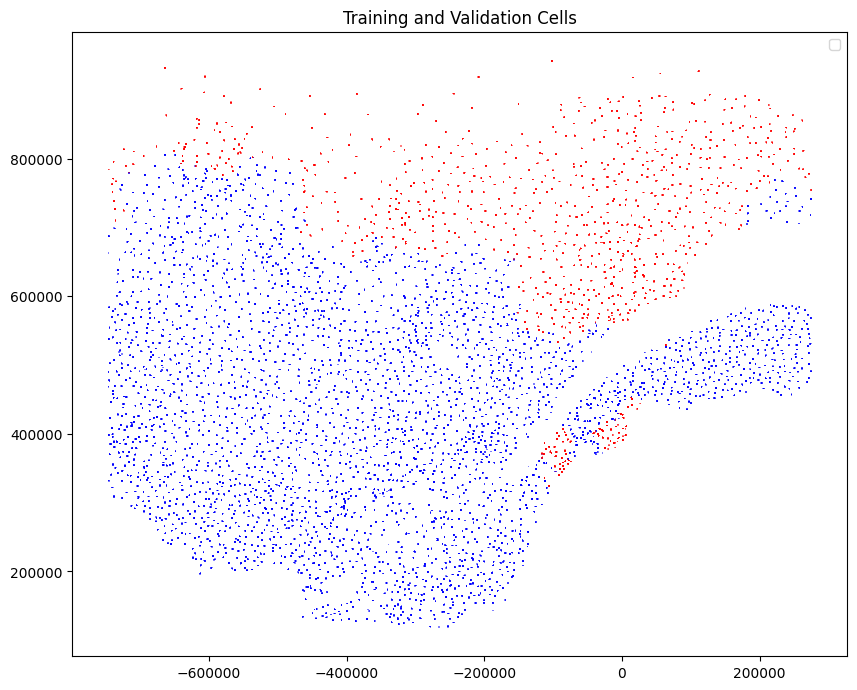

In [128]:
#data_files = ['../data/misc/sat_bands.npy']
y_train = create_target_species_df('ERP', processed_species_ok)["ERP"].values

subset_cut = int(len(y_train) * 0.8)
valid_indices = np.arange(0, len(y_train) - subset_cut)
training_indices = np.arange(len(y_train) - subset_cut, len(y_train))

#use expanded_cells column from processed_species_ok to display the training and validation data
expanded_cells_train = processed_species_ok['expanded_cells'].values[training_indices]
expanded_cells_valid = processed_species_ok['expanded_cells'].values[valid_indices]

#plot the training and validation cells
import geopandas as gpd
import matplotlib.pyplot as plt
# Convert expanded cells to GeoDataFrame
expanded_cells_train_gdf = gpd.GeoDataFrame(geometry=expanded_cells_train, crs='EPSG:6624')
expanded_cells_valid_gdf = gpd.GeoDataFrame(geometry=expanded_cells_valid, crs='EPSG:6624')
# Plot the training and validation cells
fig, ax = plt.subplots(figsize=(10, 10))
expanded_cells_train_gdf.plot(ax=ax, color='blue', alpha=0.5, label='Training Cells', markersize=200)
expanded_cells_valid_gdf.plot(ax=ax, color='red', alpha=0.5, label='Validation Cells', markersize=200)
plt.title("Training and Validation Cells")
plt.legend()
plt.show()


In [154]:
def init_generators(training_indices, valid_indices, processed_species_ok):
    # 3. Instantiate the generators
    BATCH_SIZE = 32
    #data_files = ['../data/misc/landuse.npy', '../data/misc/soil_grid.npy', '../data/misc/worldClim.npy', '../data/misc/sat_bands.npy']
    #data_files = ['../data/misc/sat_bands_squares.npy', '../data/misc/landuse_squares.npy', '../data/misc/soil_grid_squares.npy', '../data/misc/worldClim_squares.npy']
    data_files = [
        '../data/data_layers/model_inputs/cell_area_data/predictors_100_QC_normalized_squares.npy',
        #'../data/data_layers/model_inputs/cell_area_data/predictors_100_QC_squares.npy'
    ]
    zonal_stats_normalized = pd.read_csv('../data/data_layers/model_inputs/cell_data/continuous_zonal_stats_res_12_pred_100_QC_normalized_filtered.csv')
    #zonal_stats_normalized = zonal_stats_normalized.drop(columns=['h3_index', 'geometry'])
    #zonal_stats_normalized = pd.read_csv('../data/m

    #data_files = ['../data/misc/sat_bands.npy']
    y_train = create_target_species_df('ERP', processed_species_ok)["ERP"].values

    # subset_cut = int(len(y_train) * 0.8)
    # valid_indices = np.arange(0, len(y_train) - subset_cut)
    # training_indices = np.arange(len(y_train) - subset_cut, len(y_train))

    train_generator = MultiFileInputDataGenerator(
        all_file_paths=data_files,
        #zonal_stats= np.array([]),
        zonal_stats=zonal_stats_normalized.values,
        targets=y_train,
        batch_size=BATCH_SIZE,
        index_subset=training_indices,
        is_training=True,
        shuffle=True
    )
    validation_generator = MultiFileInputDataGenerator(
        all_file_paths=data_files,
        #zonal_stats=np.array([]), #zonal_stats_normalized,
        zonal_stats=zonal_stats_normalized.values,
        targets=y_train,
        batch_size=BATCH_SIZE,
        index_subset=valid_indices,
        is_training=False,
        shuffle=False
    )
    return train_generator, validation_generator

In [157]:
import pandas as pd

splits_df = pd.DataFrame(all_extracted_splits_indices)
splits_df

description          key  \
0     Target 0.0% (~Balanced)     (0.0, 0)   
1   Target 2.5% (Train < Val)  (0.025, -1)   
2   Target 2.5% (Train > Val)   (0.025, 1)   
3   Target 5.0% (Train < Val)   (0.05, -1)   
4   Target 5.0% (Train > Val)    (0.05, 1)   
5   Target 7.5% (Train < Val)  (0.075, -1)   
6   Target 7.5% (Train > Val)   (0.075, 1)   
7  Target 10.0% (Train < Val)    (0.1, -1)   
8  Target 10.0% (Train > Val)     (0.1, 1)   

                                       train_indices  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
5  [555, 556, 557, 558, 559, 560, 561, 562, 563, ...   
6  [79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9...   
7  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
8  [555, 556, 557, 558, 559, 560, 561, 562, 563, ...   

                                         val_indices  train_erp_ratio  \
0  [1454, 1455, 1456, 1457, 1458, 1508, 1509, 151...         0.175715   
1  [79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9...         0.170727   
2  [803, 804, 805, 806, 807, 808, 809, 810, 811, ...         0.179576   
3  [1244, 1245, 1247, 1248, 2424, 2425, 2426, 242...         0.165578   
4  [803, 804, 805, 806, 807, 808, 809, 810, 811, ...         0.184096   
5  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...         0.165485   
6  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...         0.191379   
7  [79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9...         0.156556   
8  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...         0.188667   

   val_erp_ratio  actual_train_val_diff  
0       0.175698               0.000017  
1       0.195950              -0.025224  
2       0.154930               0.024646  
3       0.215715              -0.050136  
4       0.133783               0.050313  
5       0.240860              -0.075375  
6       0.116427               0.074952  
7       0.256993              -0.100437  
8       0.088387               0.100280

In [ ]:
training_indices = splits_df['train_indices'].iloc[0]
validation_indices = splits_df['val_indices'].iloc[0]
train_generator, validation_generator = init_generators(training_indices, valid_indices, processed_species_ok)


--- Detected File Input Metadata ---
  File 1 ('predictors_100_QC_normalized_squares.npy'): Input Shape (H, W, C) = (22, 22, 18)
------------------------------------

Input shapes per file: [(22, 22, 18)]
All files memory-mapped successfully (1 files).
Tabular data input shape: (18,)

--- Detected File Input Metadata ---
  File 1 ('predictors_100_QC_normalized_squares.npy'): Input Shape (H, W, C) = (22, 22, 18)
------------------------------------

Input shapes per file: [(22, 22, 18)]
All files memory-mapped successfully (1 files).
Tabular data input shape: (18,)


In [35]:
inputs, targets = train_generator[0]  # or any index

In [162]:
len(inputs)

1

In [159]:
targets.shape

(32,)

In [158]:
inputs[0].shape

(32, 22, 22, 18)

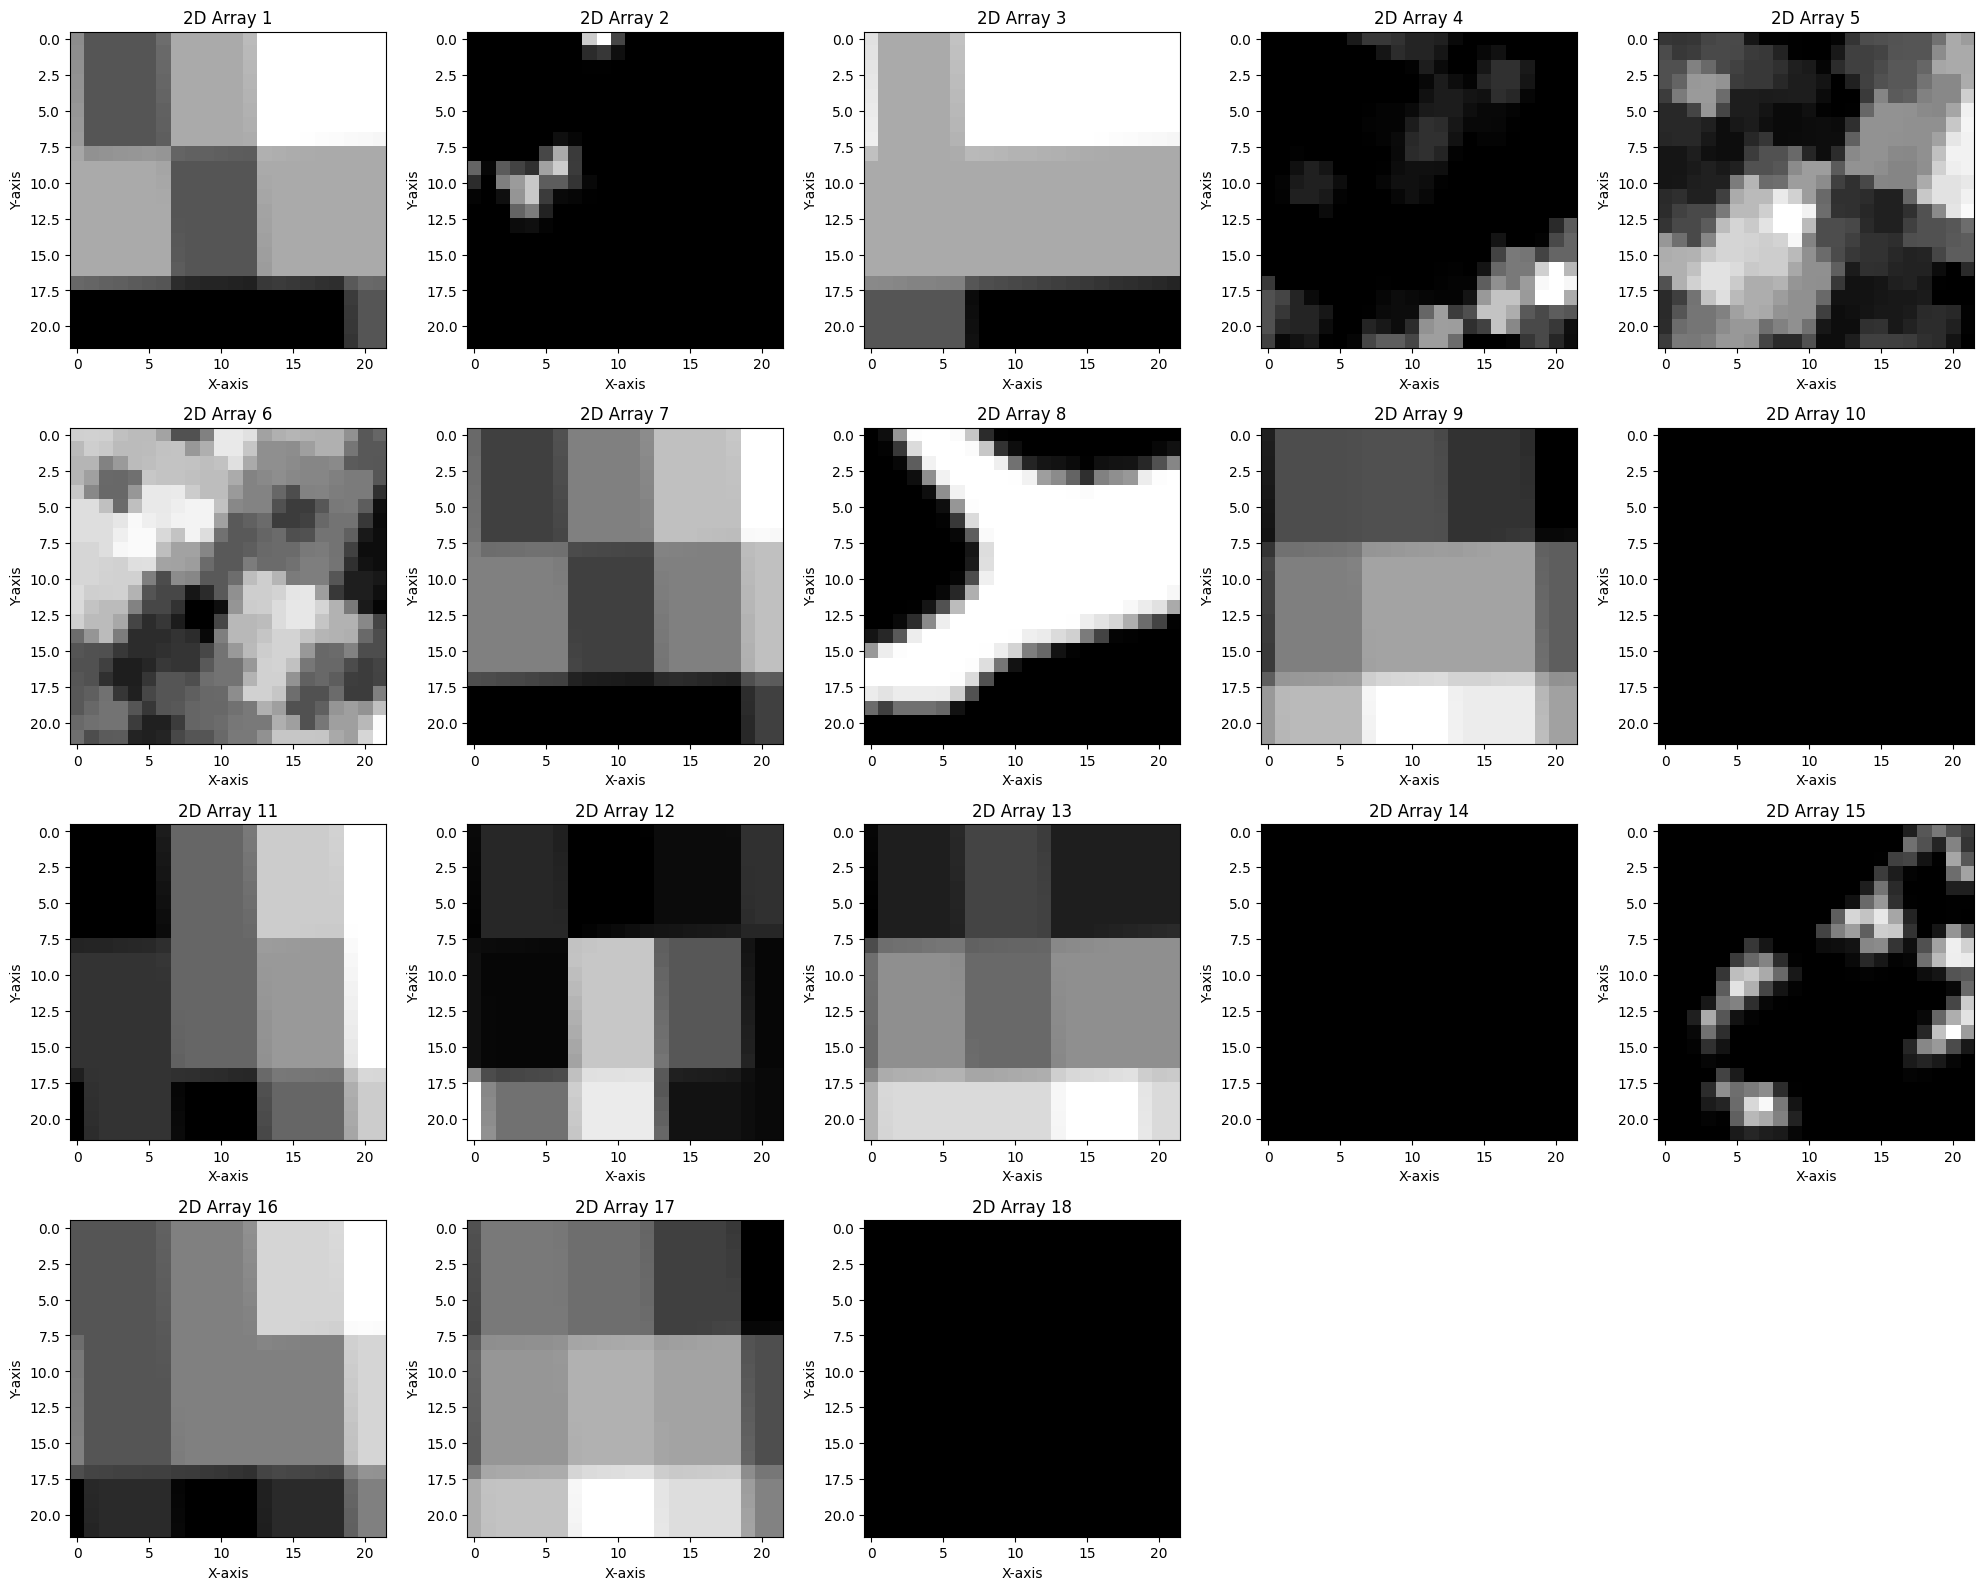

In [112]:
visualize_2d_array(inputs[0][6].transpose(2, 0, 1))

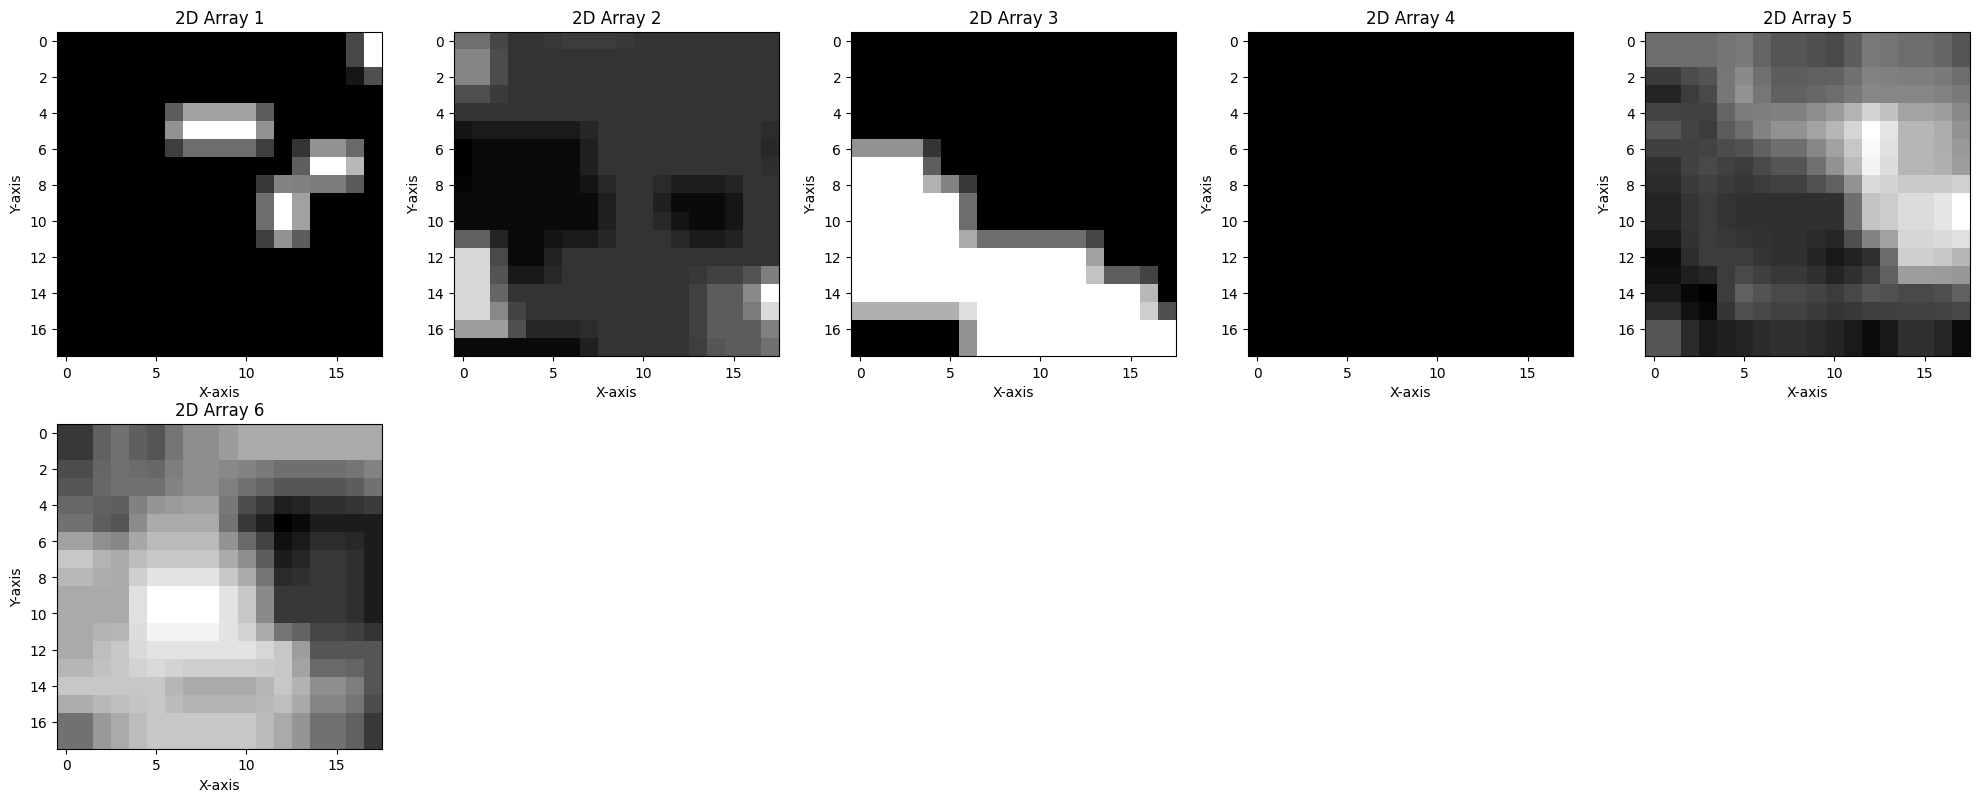

In [193]:
visualize_2d_array(inputs[2][0].transpose(2, 0, 1))

In [108]:
for i, meta in enumerate(metadata):
    print(f"Metadata for file {i}:")
    print(f"Metadata shape: {meta.shape}")
    print(meta)  # shape: (batch_size, 4)
    print("--------")

Metadata for file 0:
Metadata shape: (32, 1)
[[0.02152615]
 [0.01886872]
 [0.02023377]
 [0.02092556]
 [0.00448622]
 [0.01834717]
 [0.08255257]
 [0.01751762]
 [0.01751762]
 [0.00773542]
 [0.01571703]
 [0.00448649]
 [0.01684622]
 [0.01776092]
 [0.01680142]
 [0.02133244]
 [0.00961388]
 [0.01556389]
 [0.01693777]
 [0.01751762]
 [0.01657146]
 [0.01739555]
 [0.0168157 ]
 [0.02011283]
 [0.07130673]
 [0.0198168 ]
 [0.01559496]
 [0.02008118]
 [0.01754612]
 [0.00791038]
 [0.01559496]
 [0.14331493]]
--------
Metadata for file 1:
Metadata shape: (32, 6)
[[0.0000000e+00 9.9957359e-01 0.0000000e+00 0.0000000e+00 2.3529412e-01
  0.0000000e+00]
 [3.9215689e-03 9.9957359e-01 0.0000000e+00 0.0000000e+00 2.3685122e-01
  3.9215689e-03]
 [3.9215689e-03 9.9957359e-01 3.9215689e-03 0.0000000e+00 2.0392157e-01
  0.0000000e+00]
 [0.0000000e+00 9.9954313e-01 0.0000000e+00 0.0000000e+00 1.9607843e-01
  3.9215689e-03]
 [0.0000000e+00 9.9981725e-01 7.8431377e-03 0.0000000e+00 1.9607844e-02
  2.5490196e-02]
 [0.000

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, RandomFlip, RandomRotation, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers # Import layers explicitly for Activation
from keras import regularizers

# Import pre-trained models
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input

def residual_block(x, filters, kernel_size=(3, 3), stride=(1, 1), activation='relu'):
    """
    A basic residual block consisting of two convolutional layers with Batch Normalization
    and a shortcut connection.

    Args:
        x: Input tensor to the residual block.
        filters: Number of filters for the convolutional layers within the block.
        kernel_size: Kernel size for the convolutional layers (default: 3x3).
        stride: Stride for the first convolutional layer (default: 1x1).
                Used for downsampling within the block if needed.
        activation: Activation function to use after each convolution and after the final addition.

    Returns:
        tf.Tensor: Output tensor of the residual block.
    """
    # Store the input for the shortcut connection
    shortcut = x

    # Main path: First convolutional layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = layers.Activation(activation)(x) # Use layers.Activation for clarity

    # Main path: Second convolutional layer
    x = Conv2D(filters, kernel_size, padding='same',
                      kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Shortcut connection:
    # If the spatial dimensions change (due to stride) OR
    # if the number of filters changes, apply a 1x1 convolution to the shortcut.
    # This aligns the dimensions so it can be added to the main path's output.
    current_filters_in_shortcut = shortcut.shape[-1]
    if stride != (1, 1) or current_filters_in_shortcut != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same',
                                 kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add the shortcut connection to the main path output
    x = layers.add([x, shortcut])
    # Apply final activation after the addition
    x = layers.Activation(activation)(x)
    return x

def build_dynamic_multi_file_input_model(input_shapes_per_file, tabular_input_shape, output_dim=1, activation='linear', use_pretrained_model_for_image_index=None, pretrained_model_name='ResNet50', freeze_pretrained=True):
    """
    Builds a Keras model with a separate CNN branch for each input file.
    Can incorporate a pre-trained model for one of the image inputs.

    Args:
        input_shapes_per_file (list): A list of (H, W, C) input shapes, one for each file.
                                      Order must match the generator's file order.
        tabular_input_shape (tuple): Shape of the tabular data input.
        output_dim (int): Dimension of the final output.
        activation (str): Activation function for the final output layer.
        use_pretrained_model_for_image_index (int, optional): The index in input_shapes_per_file
                                                               for which to use a pre-trained model.
                                                               Set to None to use custom CNN for all.
        pretrained_model_name (str): Name of the pre-trained model to use ('ResNet50', 'VGG16').
        freeze_pretrained (bool): If True, the pre-trained model's layers will be frozen.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    input_layers = []
    feature_vectors = []

    for i, input_shape in enumerate(input_shapes_per_file):
        input_layer = Input(shape=input_shape, name=f'file_input_{i:02d}')
        input_layers.append(input_layer)

        x = input_layer

        if i == use_pretrained_model_for_image_index:
            print(f"Using pre-trained {pretrained_model_name} for input_shape: {input_shape}")
            if pretrained_model_name == 'ResNet50':
                # Preprocess input for ResNet50
                x = resnet_preprocess_input(x)
                base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
            elif pretrained_model_name == 'VGG16':
                # Preprocess input for VGG16
                x = vgg_preprocess_input(x)
                base_model = VGG16(weights='imagenet', include_top=False, input_tensor=x)
            else:
                raise ValueError("Unsupported pre-trained model name. Choose 'ResNet50' or 'VGG16'.")

            if freeze_pretrained:
                for layer in base_model.layers:
                    layer.trainable = False
                print(f"Frozen {pretrained_model_name} layers.")
            else:
                print(f"Fine-tuning {pretrained_model_name} layers.")

            x = base_model.output # Get the output of the base model
            x = GlobalAveragePooling2D()(x) # Add a Global Average Pooling layer to reduce dimensionality
            # You can add more dense layers here if needed after the pre-trained feature extraction
            # x = Dense(256, activation='relu')(x)
            # x = Dropout(0.5)(x)

        else:
            print(f"Using custom CNN layers for input_shape: {input_shape}")
            # Your existing custom CNN logic for other image inputs or if no pre-trained model is used
            x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', use_bias=True)(x)
            x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

            x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', use_bias=True)(x)
            x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

            
            
            if input_shape[0] > 70:
                print(f"Adding deeper layers with Residual Blocks for input_shape: {input_shape}")
                x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', use_bias=True)(x)
                x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

                x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', use_bias=True)(x)
                x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

                x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', use_bias=True)(x)
                x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

                x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', use_bias=True)(x)
                x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
            else:
                print(f"Using standard layers for input_shape: {input_shape}")

            x = Flatten(name=f'flatten_file_{i:02d}')(x)
        
        feature_vectors.append(x)

    # --- Tabular Data Branch ---
    if tabular_input_shape is not None:
        print(f"Adding tabular input branch with shape: {tabular_input_shape}")
        tabular_input = Input(shape=tabular_input_shape, name='tabular_input')
        input_layers.append(tabular_input)
        
        tabular_features = Dense(64)(tabular_input)
        tabular_features = BatchNormalization()(tabular_features)
        tabular_features = layers.Activation('relu')(tabular_features)
        tabular_features = Dropout(0.3)(tabular_features)

        tabular_features = Dense(128)(tabular_features)
        tabular_features = BatchNormalization()(tabular_features)
        tabular_features = layers.Activation('relu')(tabular_features)

        tabular_features = Dense(256)(tabular_features)
        tabular_features = BatchNormalization()(tabular_features)
        tabular_features = layers.Activation('relu')(tabular_features)
        
        tabular_features = Flatten(name='flatten_tabular')(tabular_features)

        feature_vectors.append(tabular_features)

    # Concatenate all feature vectors from different branches
    if len(feature_vectors) > 1:
        merged_features = concatenate(feature_vectors, name='concatenated_features')
    else:
        merged_features = feature_vectors[0]

    # Add final dense layers for fusion and prediction
    x = Dense(128)(merged_features)
    x = BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)

    # Final output layer
    output = Dense(output_dim, activation=activation, name='output_prediction')(x)

    model = Model(inputs=input_layers, outputs=output)
    return model

# Example Usage:
# Define your input shapes. Let's say the first input is satellite imagery.
# satellite_imagery_shape = (224, 224, 3) # Typical input size for pre-trained models (e.g., ResNet50 expects 224x224x3)
# environmental_raster_shape = (64, 64, 1)
# tabular_data_shape = (10,)

# input_shapes = [satellite_imagery_shape, environmental_raster_shape]

# # Build the model using ResNet50 for the first image input (index 0)
# model_with_resnet = build_dynamic_multi_file_input_model(
#     input_shapes_per_file=input_shapes,
#     tabular_input_shape=tabular_data_shape,
#     use_pretrained_model_for_image_index=0,  # Use pre-trained model for the first image input
#     pretrained_model_name='ResNet50',      # Specify ResNet50
#     freeze_pretrained=True                  # Freeze its layers
# )

# model_with_resnet.summary()

# # If you want to try VGG16 instead:
# model_with_vgg = build_dynamic_multi_file_input_model(
#     input_shapes_per_file=input_shapes,
#     tabular_input_shape=tabular_data_shape,
#     use_pretrained_model_for_image_index=0,
#     pretrained_model_name='VGG16',
#     freeze_pretrained=True
# )

# model_with_vgg.summary()

In [110]:
last_elements = [t[-1] for t in train_generator.input_shapes_per_file]
print(last_elements)

[1, 6, 20, 5]


In [38]:
model = build_dynamic_multi_file_input_model(
    input_shapes_per_file=train_generator.input_shapes_per_file,
    tabular_input_shape=train_generator.tabular_input_shape,
    output_dim=1,  # Binary classification
    activation='sigmoid',  # Sigmoid for binary classification
    #use_pretrained_model_for_image_index=0,  # Use pre-trained model for the first image input because satelitte is a index 0
    pretrained_model_name='ResNet50',  # Specify ResNet50
    freeze_pretrained=True  # Freeze its layers
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
model.summary()

Using custom CNN layers for input_shape: (22, 22, 18)
Using standard layers for input_shape: (22, 22, 18)
Adding tabular input branch with shape: (18,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,216 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      8,320 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ file_input_00       │ (None, 22, 22,    │          0 │ -                 │
│ (InputLayer)        │ 18)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 22, 22,    │      2,608 │ file_input_00[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 11, 11,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     33,024 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 11,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 6, 6, 32)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_file_00     │ (None, 1152)      │          0 │ max_pooling2d_1[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_tabular     │ (None, 256)       │          0 │ activation_2[0][… │
│ (Flatten)           │                   │            │                 

 Total params: 467,473 (1.78 MB)

 Trainable params: 464,273 (1.77 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [146]:
model = build_dynamic_multi_file_input_model(
    input_shapes_per_file=train_generator.input_shapes_per_file,
    tabular_input_shape=train_generator.tabular_input_shape,
    output_dim=1,  # Binary classification
    activation='sigmoid'  # Sigmoid for binary classification
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# train_generator = MultiFileInputDataGenerator(
#     all_file_paths=data_files,
#     targets=y_train,
#     batch_size=BATCH_SIZE,
#     index_subset=training_indices,
#     shuffle=True
# )
# validation_generator = MultiFileInputDataGenerator(
#     all_file_paths=data_files,
#     targets=y_train,
#     batch_size=BATCH_SIZE,
#     index_subset=valid_indices,
#     shuffle=False
# )

Adding deeper layers with Residual Blocks for input_shape: (107, 107, 5)
Adding deeper layers with Residual Blocks for input_shape: (107, 107, 1)
Using standard layers for input_shape: (34, 34, 6)
Using standard layers for input_shape: (5, 5, 20)


In [121]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define EarlyStopping callback
# Monitors 'val_loss' (or 'val_accuracy'), stops if no improvement for 'patience' epochs.
# 'restore_best_weights' ensures you get the model weights from the best performing epoch.
early_stopping = EarlyStopping(
    monitor='val_loss', # You can also use 'val_accuracy'
    patience=10,         # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True,
    verbose=1
)

# Define ReduceLROnPlateau callback
# Reduces learning rate when 'val_loss' has stopped improving.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', # You can also use 'val_accuracy'
    factor=0.5,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,         # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-6,        # Lower bound on the learning rate.
    verbose=1
)

# When compiling your model, make sure you're using an optimizer
# For example, Adam is a good general-purpose optimizer
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Adjust loss based on output_dim and activation

# Then, when you train your model:
# model.fit(
#     your_training_data,
#     your_training_labels,
#     epochs=300, # Or a large number, EarlyStopping will stop it
#     validation_data=(your_validation_data, your_validation_labels),
#     callbacks=[early_stopping, lr_scheduler] # Pass the callbacks here
# )

/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
581/581 ━━━━━━━━━━━━━━━━━━━━ 48s 79ms/step - accuracy: 0.8063 - loss: 0.4626 - val_accuracy: 0.8715 - val_loss: 0.2755
Epoch 2/15
581/581 ━━━━━━━━━━━━━━━━━━━━ 47s 80ms/step - accuracy: 0.8583 - loss: 0.2998 - val_accuracy: 0.8695 - val_loss: 0.2851
Epoch 3/15
581/581 ━━━━━━━━━━━━━━━━━━━━ 47s 81ms/step - accuracy: 0.8680 - loss: 0.2788 - val_accuracy: 0.8553 - val_loss: 0.2953
Epoch 4/15
581/581 ━━━━━━━━━━━━━━━━━━━━ 46s 80ms/step - accuracy: 0.8762 - loss: 0.2670 - val_accuracy: 0.8739 - val_loss: 0.2813
Epoch 5/15
581/581 ━━━━━━━━━━━━━━━━━━━━ 46s 79ms/step - accuracy: 0.8725 - loss: 0.2699 - val_accuracy: 0.6826 - val_loss: 0.7966
Epoch 6/15
581/581 ━━━━━━━━━━━━━━━━━━━━ 46s 79ms/step - accuracy: 0.8756 - loss: 0.2620 - val_accuracy: 0.8469 - val_loss: 0.4355
Epoch 7/15
581/581 ━━━━━━━━━━━━━━━━━━━━ 46s 80ms/step - accuracy: 0.8735 - loss: 0.2657 - val_accuracy: 0.8703 - val_loss: 0.2767
Epoch 8/15
581/581 ━━━━━━━━━━━━━━━━━━━━ 46s 80ms/step - accuracy: 0.8793 - loss: 0.2609 - 

Text(0.5, 1.0, 'Model accuracy')

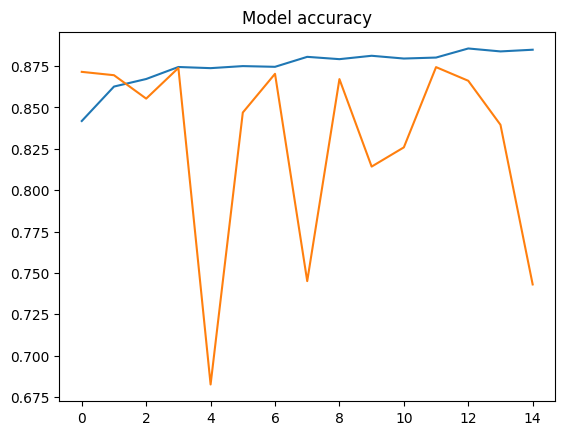

In [39]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15, # Adjust as needed
    verbose=1,
    #callbacks=[early_stopping, lr_scheduler]  # Pass the callbacks here
)
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')

In [41]:
#save the model from the best epoch
model.save('../model/multi_file_input_model_87.keras')


Text(0.5, 1.0, 'Model loss')

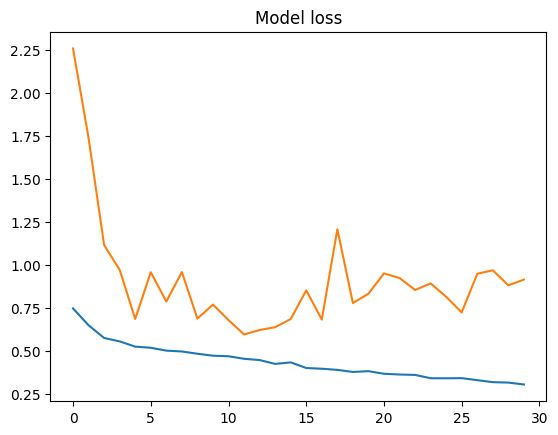

In [163]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')

Text(0.5, 1.0, 'Model accuracy')

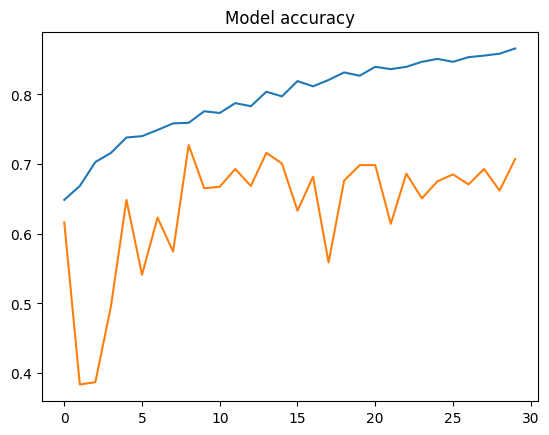

In [164]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')

In [174]:
confusion_generator = MultiFileInputDataGenerator(
    all_file_paths=data_files,
    zonal_stats=zonal_stats_normalized.values,
    targets=y_train,
    batch_size=y_train.shape[0],  # Use the entire dataset for confusion matrix
    index_subset=valid_indices,
    is_training=False,
    shuffle=False
)


--- Detected File Input Metadata ---
  File 1 ('sat_bands_squares.npy'): Input Shape (H, W, C) = (107, 107, 5)
  File 2 ('landuse_squares.npy'): Input Shape (H, W, C) = (107, 107, 1)
  File 3 ('soil_grid_squares.npy'): Input Shape (H, W, C) = (34, 34, 6)
  File 4 ('worldClim_squares.npy'): Input Shape (H, W, C) = (5, 5, 20)
------------------------------------

Input shapes per file: [(107, 107, 5), (107, 107, 1), (34, 34, 6), (5, 5, 20)]
All files memory-mapped successfully (4 files).
Tabular data input shape: (54,)


In [177]:
inputs, targets = confusion_generator[0]

In [178]:
targets.shape

(902,)

In [200]:
#count the number of unique values in targets
unique_values, counts = np.unique(targets, return_counts=True)
print("Unique values in targets:", unique_values)
print("Counts of unique values:", counts)

Unique values in targets: [0 1]
Counts of unique values: [346 556]


In [ ]:
from sklearn.metrics import confusion_matrix

# Predict
y_prediction = model.predict(inputs, verbose=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [201]:
# Convert probabilities to binary labels (threshold at 0.5)
y_pred_labels = (y_prediction > 0.5).astype(int).flatten()

# Create confusion matrix and normalize over predicted (columns)
result = confusion_matrix(targets, y_pred_labels, normalize='pred')
result

array([[0.72625698, 0.29875519],
       [0.27374302, 0.70124481]])

### Testing model robustness

In [161]:
train_generators = []
validation_generators = []
for split_info in all_extracted_splits_indices:
    key = split_info['key']
    train_indices_for_this_split = split_info['train_indices']
    val_indices_for_this_split = split_info['val_indices']
    
    # Create generators for each split
    train_gen, val_gen = init_generators(train_indices_for_this_split, val_indices_for_this_split, processed_species_ok)
    
    train_generators.append(train_gen)
    validation_generators.append(val_gen)


--- Detected File Input Metadata ---
  File 1 ('predictors_100_QC_normalized_squares.npy'): Input Shape (H, W, C) = (22, 22, 18)
------------------------------------

Input shapes per file: [(22, 22, 18)]
All files memory-mapped successfully (1 files).
Tabular data input shape: (18,)

--- Detected File Input Metadata ---
  File 1 ('predictors_100_QC_normalized_squares.npy'): Input Shape (H, W, C) = (22, 22, 18)
------------------------------------

Input shapes per file: [(22, 22, 18)]
All files memory-mapped successfully (1 files).
Tabular data input shape: (18,)

--- Detected File Input Metadata ---
  File 1 ('predictors_100_QC_normalized_squares.npy'): Input Shape (H, W, C) = (22, 22, 18)
------------------------------------

Input shapes per file: [(22, 22, 18)]
All files memory-mapped successfully (1 files).
Tabular data input shape: (18,)

--- Detected File Input Metadata ---
  File 1 ('predictors_100_QC_normalized_squares.npy'): Input Shape (H, W, C) = (22, 22, 18)
------------

In [162]:
def test_fusion_cnn(model, train_generator, validation_generator, epochs=10):
    """
    Test the fusion CNN model with the provided generators.
    
    Args:
        model: The Keras model to test.
        train_generator: The training data generator.
        validation_generator: The validation data generator.
        epochs: Number of epochs to train the model.
        
    Returns:
        history: Training history object containing loss and accuracy metrics.
    """
    # Compile the model if not already compiled
    if not model.optimizer:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1
    )
    
    return history

# Test the model with each split
all_histories = []
for i, (train_gen, val_gen) in enumerate(zip(train_generators, validation_generators)):
    print(f"Testing split {i+1}...")
    history = test_fusion_cnn(model, train_gen, val_gen, epochs=5)
    all_histories.append(history)

Testing split 1...


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.8819 - loss: 0.2426 - val_accuracy: 0.8802 - val_loss: 0.2859
Epoch 2/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.8815 - loss: 0.2361 - val_accuracy: 0.7980 - val_loss: 0.4068
Epoch 3/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.8905 - loss: 0.2344 - val_accuracy: 0.2871 - val_loss: 1.3857
Epoch 4/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.8925 - loss: 0.2303 - val_accuracy: 0.4709 - val_loss: 0.9383
Epoch 5/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.8934 - loss: 0.2260 - val_accuracy: 0.8361 - val_loss: 0.3512
Testing split 2...
Epoch 1/5
602/602 ━━━━━━━━━━━━━━━━━━━━ 49s 82ms/step - accuracy: 0.8896 - loss: 0.2376 - val_accuracy: 0.8783 - val_loss: 0.2894
Epoch 2/5
602/602 ━━━━━━━━━━━━━━━━━━━━ 49s 82ms/step - accuracy: 0.8892 - loss: 0.2369 - val_accuracy: 0.8680 - val_loss: 0.3127
Epoch 3/5
602/602 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.8879 - loss

In [164]:
import pandas as pd

# Collect stats from all_histories
stats = []
for i, history in enumerate(all_histories):
    hist = history.history
    stats.append({
        'split_index': i,
        'final_train_loss': hist['loss'][-1],
        'final_val_loss': hist['val_loss'][-1],
        'final_train_acc': hist['accuracy'][-1],
        'final_val_acc': hist['val_accuracy'][-1],
        'best_val_acc': max(hist['val_accuracy']),
        'best_val_acc_epoch': hist['val_accuracy'].index(max(hist['val_accuracy'])),
        'epochs': len(hist['loss'])
    })

stats_df = pd.DataFrame(stats)
# Add the actual_train_val_diff from all_extracted_splits_indices for each split
split_diffs = [split['actual_train_val_diff'] for split in all_extracted_splits_indices]
stats_df['split_ratio_diff'] = split_diffs
stats_df

split_index  final_train_loss  final_val_loss  final_train_acc  \
0            0          0.231791        0.351223         0.891934   
1            1          0.227745        0.356616         0.890147   
2            2          0.222869        0.514819         0.894518   
3            3          0.194803        1.430828         0.909898   
4            4          0.198303        1.203690         0.908027   
5            5          0.173255        1.549844         0.920681   
6            6          0.174434        0.382153         0.923174   
7            7          0.129835        1.184119         0.943609   
8            8          0.145404        0.121504         0.937350   

   final_val_acc  best_val_acc  best_val_acc_epoch  epochs  split_ratio_diff  
0       0.836075      0.880151                   0       5          0.000017  
1       0.838642      0.878296                   0       5         -0.025224  
2       0.767739      0.895562                   2       5          0.024646  
3       0.790885      0.856053                   0       5         -0.050136  
4       0.413353      0.899225                   3       5          0.050313  
5       0.761598      0.860215                   1       5         -0.075375  
6       0.806818      0.908094                   3       5          0.074952  
7       0.415865      0.852273                   3       5         -0.100437  
8       0.951613      0.953226                   3       5          0.100280

## Generating a full map!!!

### Filling an area with hexagons

In [50]:
from shapely.geometry import box

# Get the bounding box (minx, miny, maxx, maxy) of all geometries in processed_species_ok['expanded_cells']

# Convert expanded_cells to a GeoSeries if not already
expanded_cells_gs = gpd.GeoSeries(processed_species_ok['expanded_cells'], crs='EPSG:6624')
bbox = expanded_cells_gs.to_crs(epsg=4326).total_bounds  # returns [minx, miny, maxx, maxy]
print("Bounding box (minx, miny, maxx, maxy):", bbox)

Bounding box (minx, miny, maxx, maxy): [-79.1495867   45.00837953 -64.5604737   52.44980038]


<Axes: >

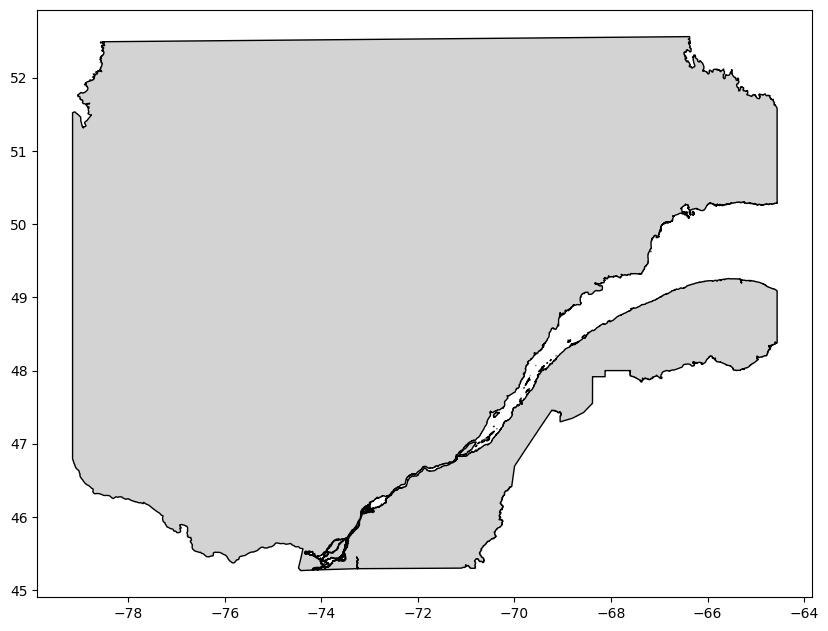

In [118]:
from h3 import LatLngPoly, LatLngMultiPoly

gdf = gpd.read_file('../data/boundaries/lpr_000b16a_e/lpr_000b16a_e.shp')
quebec_gdf = gdf[gdf['PRENAME'] == 'Quebec']

# Ensure bbox is in the same CRS as quebec_gdf before clipping
if hasattr(expanded_cells_gs, "crs") and expanded_cells_gs.crs is not None:
    bbox_geom = box(*bbox)
    bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs="EPSG:4326")
    # Reproject bbox to match quebec_gdf CRS
    bbox_gdf = bbox_gdf.to_crs(quebec_gdf.crs)
    bbox_proj = bbox_gdf.geometry.values[0]
    quebec_gdf = gpd.clip(quebec_gdf, bbox_proj)
else:
    # Fallback: try to clip directly (may fail if CRS mismatch)
    quebec_gdf = gpd.clip(quebec_gdf, box(*bbox))

# apply crs to the geodataframe
quebec_gdf = quebec_gdf.to_crs(epsg=4326)

# Function to convert MULTIPOLYGON to LatLngMultiPoly
def multipolygon_to_latlngmultipoly(multipolygon):
    latlngmultipoly = []
    for polygon in multipolygon.geoms:  # Iterate over individual polygons
        latlngpoly = []
        for coord in polygon.exterior.coords:
            latlngpoly.append([coord[1], coord[0]])  # Convert to [lat, lng]
        latlngmultipoly.append(latlngpoly)
    return latlngmultipoly

# Convert the quebec_gdf to LatLngMultiPoly
quebec_latlngmultipoly = multipolygon_to_latlngmultipoly(quebec_gdf.geometry.values[0])

# Ensure quebec_latlngmultipoly_obj is correctly defined
quebec_polys = [LatLngPoly(coords) for coords in quebec_latlngmultipoly]
quebec_latlngmultipoly_obj = LatLngMultiPoly(*quebec_polys)

#now add a square in the middle of quebec
# Calculate the center of the bounding box
center_x = (bbox[0] + bbox[2]) / 2
center_y = (bbox[1] + bbox[3]) / 2

# Create a square polygon in the middle of Quebec
square_size = 0.005  # Size of the square
square = box(center_x - square_size, center_y - square_size, center_x + square_size, center_y + square_size)
# Convert to GeoDataFrame
square_gdf = gpd.GeoDataFrame(geometry=[square], crs=quebec_gdf.crs)

# Plot the square on top of the Quebec map
ax = quebec_gdf.plot(figsize=(10, 10), color='lightgrey', edgecolor='black')
square_gdf.plot(ax=ax, color='red', alpha=0.5)

In [119]:
# Convert the square to LatLngMultiPoly
square_latlngpoly = []
for coord in square.exterior.coords:
    square_latlngpoly.append([coord[1], coord[0]])  # Convert to [lat, lng]
square_latlngmultipoly = LatLngMultiPoly(LatLngPoly(square_latlngpoly))

pred_h3_cells = h3.h3shape_to_cells(square_latlngmultipoly, 12)

pred_h3_cells = pd.DataFrame(pred_h3_cells, columns=['h3_cell'])

pred_h3_cells['geometry'] = pred_h3_cells.apply(add_geometry, axis=1)

pred_h3_cells = gpd.GeoDataFrame(pred_h3_cells, geometry='geometry')

#rename col h3_cell to h3_index
pred_h3_cells = pred_h3_cells.rename(columns={'h3_cell': 'h3_index'})

# Ensure the CRS is set correctly
pred_h3_cells.crs = 'EPSG:4326'

In [107]:
pred_h3_cells

h3_index                                           geometry
0      8c2ba0803c2cbff  POLYGON ((-71.86149 48.71201, -71.86165 48.711...
1      8c2ba08000d41ff  POLYGON ((-71.84748 48.7215, -71.84764 48.7214...
2      8c2ba08021001ff  POLYGON ((-71.87659 48.7263, -71.87675 48.7262...
3      8c2ba080381d3ff  POLYGON ((-71.85189 48.70826, -71.85205 48.708...
4      8c2ba08061581ff  POLYGON ((-71.85754 48.74268, -71.85769 48.742...
...                ...                                                ...
58855  8c2ba0806a755ff  POLYGON ((-71.84579 48.73911, -71.84595 48.739...
58856  8c2ba080382b9ff  POLYGON ((-71.84955 48.70856, -71.8497 48.7085...
58857  8c2ba08000e27ff  POLYGON ((-71.8455 48.72139, -71.84566 48.7213...
58858  8c2ba0802a1d5ff  POLYGON ((-71.86742 48.71986, -71.86758 48.719...
58859  8c2ba080210e7ff  POLYGON ((-71.87681 48.72536, -71.87697 48.725...

[58860 rows x 2 columns]

<Axes: >

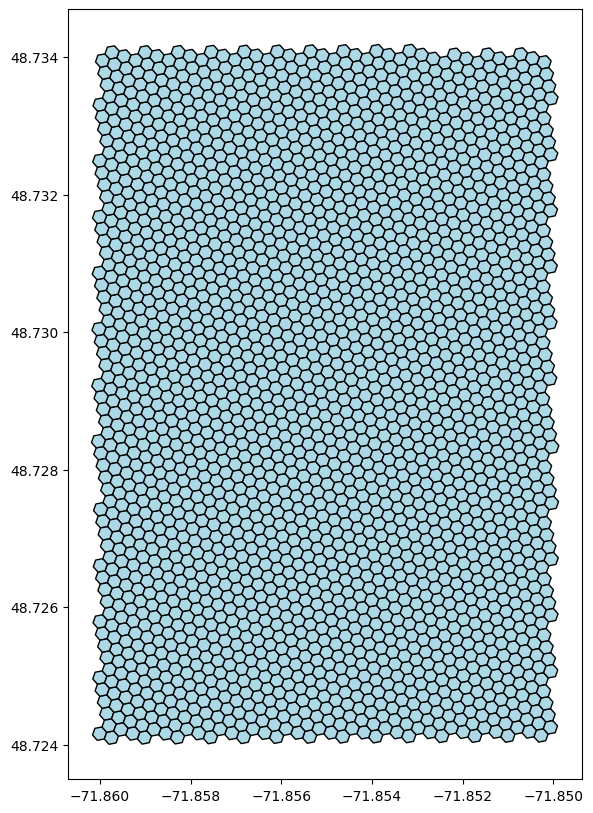

In [120]:
#display the h3 cells on a map
pred_h3_cells.plot(figsize=(10, 10), color='lightblue', edgecolor='black')

### Extracting zonal stats from hexagons

In [121]:
#get file names from columns
training_zonal_stats_normalized = pd.read_csv('../data/data_layers/model_inputs/cell_data/continuous_zonal_stats_res_12_pred_100_QC_normalized_filtered.csv')

filtered_file_names = training_zonal_stats_normalized.columns.values
#remove the _value suffix from the file names
filtered_file_names = [file_name.replace('_value', '') for file_name in filtered_file_names]
data_dir = "../data/data_layers/predictors_100_QC_normalized"
filtered_file_paths = [os.path.join(data_dir, file_name + '.tif') for file_name in filtered_file_names]

In [122]:
# Execute processing
continuous_results, categorical_results = process_rasters(
    proc_spec=pred_h3_cells.copy(),
    file_paths=filtered_file_paths,  # Include all file paths
    file_names=filtered_file_names,
    category_map=None
)
continuous_results
continuous_results.to_csv('../data/data_layers/model_inputs/cell_data/continuous_zonal_stats_res_12_pred_100_QC_for_pred.csv', index=False)


In [ ]:
expanded_cells = expand_cell(
    h3_cells=processed_species['h3_index'].values,
    expand_factor=100,
    to_square=True,  # Set to True if you want square cells
    to_crs='EPSG:6624'
)

NameError: name 'expand_cells_to_squares' is not defined

In [125]:
expanded_cells

[<POLYGON ((-5647.545 882170.614, -3330.332 882170.614, -3330.332 884487.827,...>,
 <POLYGON ((-5455.012 882188.735, -3137.807 882188.735, -3137.807 884505.94, ...>,
 <POLYGON ((253.005 888213.231, 2570.219 888213.231, 2570.219 890530.444, 253...>,
 <POLYGON ((92.515 888220.33, 2409.737 888220.33, 2409.737 890537.552, 92.515...>,
 <POLYGON ((980.775 888074.525, 3297.947 888074.525, 3297.947 890391.697, 980...>,
 <POLYGON ((1162.715 888039.849, 3479.877 888039.849, 3479.877 890357.01, 116...>,
 <POLYGON ((780.097 888116.687, 3097.28 888116.687, 3097.28 890433.871, 780.0...>,
 <POLYGON ((6775.791 863691.197, 9091.527 863691.197, 9091.527 866006.934, 67...>,
 <POLYGON ((6684.619 863841.45, 9000.367 863841.45, 9000.367 866157.198, 6684...>,
 <POLYGON ((6893.822 863473.291, 9209.543 863473.291, 9209.543 865789.011, 68...>,
 <POLYGON ((6633.609 863956.702, 8949.365 863956.702, 8949.365 866272.458, 66...>,
 <POLYGON ((7001.264 863202.673, 9316.967 863202.673, 9316.967 865518.375, 70...>,
 <PO

In [ ]:
env_data_for_pred = prepare_data_with_feature_importance(processed_species_ok, filtered_file_paths, transform_to_squares=True, no_sat=True, with_resize=False)